# Plots for the Teachable Robot Project

# Useful Functions

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = [15, 5]

In [151]:
data_dirs = [
    pathlib.Path('meta-mb-internal/data'),
    pathlib.Path('meta-mb-internal/eval_runs'),
    pathlib.Path('meta-mb-internal/old_data'),
    pathlib.Path('meta-mb-internal'),
]

def get_filenames(name):
    name = str(name)
    name_paths = []
    for data_dir in data_dirs:
        for exp_dir in data_dir.iterdir():
            if name in exp_dir.name:
                name_paths.append(exp_dir)
    return name_paths

def plot_curriculum(data_names, x_type, use_min_len=True, y='Curriculum Percent', smooth=1,
                   level_start=0, level_end=float('inf'), title=None):
    color = iter(cm.rainbow(np.linspace(0, 1, len(data_names))))
    legend = []
    legend_colors = []
    plots = []
    df_y_key = y
    df_level_key = 'Curriculum Step'
    if x_type == 'samples':
        x_label = 'Samples'
        df_x_key = 'Itr'
        title = 'Sample Efficiency' if title is None else title
    elif x_type == 'feedback':
        x_label = 'Num Feedback'
        df_x_key = 'Train/NumFeedbackTotal'
        title = 'Feedback Efficiency' if title is None else title
        
    for run_names, legend_name in data_names:
        try:
            data = [d for run_name in run_names for d in load_data(run_name)]

            cols = [df[df_y_key].ewm(span=smooth).mean().to_numpy() for df in data]
            c = next(color)
            for i, run in enumerate(cols):
                x_val = data[i][df_x_key].to_numpy()
                non_null_indices = ~np.isnan(x_val)
                levels = data[i][df_level_key].to_numpy()
                above_min_level = levels >= level_start
                below_max_level = levels <= level_end
                in_range = np.logical_and(above_min_level, below_max_level)
                good_indices = np.logical_and(in_range, non_null_indices)
                good_indices = np.argwhere(good_indices)[:, 0]
                
                print("Length", len(good_indices))
#                 print(run[good_indices])
                plt.plot(x_val[good_indices], run[good_indices], c=c)
            legend_line = mlines.Line2D([], [], color=c, label=legend_name)
            plots.append(legend_line)
        except Exception as e:
            print(e)
            print("couldn't plot " + legend_name)

    plt.title(title)
    plt.ylabel('Curriculum %')
    plt.ylim(0, 1.001)
    plt.xlabel(x_label)
    plt.legend(handles=plots)
    plt.show()


def load_data(name, file_name='progress.csv'):
    if type(name) is pathlib.PosixPath:
        name_paths = [name]
    else:
        name_paths = get_filenames(name)
    assert len(name_paths) > 0, "No files found with name " + name
    # check that they're all the same except the seed
    csv_datas = []
    for path in name_paths:
        assert path.name[:-1] == name_paths[0].name[:-1], f"Found multiple files with name {name}: {[path.name for path in name_paths]}"
        try:
            csv_name = path.joinpath(file_name)
            data = pd.read_csv(csv_name)
#             print("READ CSV!")
#             print(data.columns)
        except Exception as e:
            print(e)
            csv_name = path.joinpath('new_progress.csv')
            data = pd.read_csv(csv_name)
            
        # There used to be a bug where reward wasn't computed correctly
        if name in ['0729_PA', '0730']:
            gave_reward_indices = np.argwhere(~np.isnan(data['Train/num_feedback_reward'].to_numpy()))[:, 0]
            # Assume for each null run, we're collecting as much as in the last valid run
            num_advice = data['Train/num_feedback_advice'].fillna(method='ffill').to_numpy()
            total_advice = np.cumsum(num_advice)
            # Assume for each run where num_feedback_reward is not None we got one reward per sample
            num_reward = np.zeros_like(data['Train/num_feedback_reward'])
            num_reward[gave_reward_indices] = 800
            total_reward = np.cumsum(num_reward)
            data['Train/num_feedback_advice'] = num_advice
            data['Train/num_feedback_reward'] = num_reward
            data['Train/NumFeedbackReward'] = total_reward
            data['Train/NumFeedbackAdvice'] = total_advice
            data['Train/NumFeedbackTotal'] = total_advice + total_reward
#         elif 'Train/num_feedback_advice' in data.columns and 'Train/num_feedback_reward' in data.columns:
#             data['Train/num_feedback_reward'] = data['Train/num_feedback_reward'] * 0 + 800
#             data['Train/NumFeedbackAdvice'] = np.cumsum(data['Train/num_feedback_advice'])
#             data['Train/NumFeedbackReward'] = np.cumsum(data['Train/num_feedback_reward'])
#             timestep_feedback = data['Train/num_feedback_advice'] + data['Train/num_feedback_reward']
#             full_feedback = np.cumsum(timestep_feedback)
#             data['Train/NumFeedbackTotal'] = full_feedback
        # Remove whitespace in col names
        data.columns = [c.strip() for c in data.columns]
        csv_datas.append(data)
    return csv_datas


def plot_final_generalization(runs, title, metric='success_rate'):
    legend_list = []
    env_names = None
    env_dict = {}
    for run_names, legend_name in runs:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            if env_names is None:
                env_names = data[0]['env'].to_numpy()
                env_dict = {env_name: ([],[]) for env_name in env_names}
            success = [df[metric].to_numpy() for df in data]
            for i, (env_name, (mean_list, std_list)) in enumerate(env_dict.items()):
                mean_list.append(np.mean([s[i].item() for s in success]))
                std_list.append(np.std([s[i].item() for s in success]))
            legend_list.append(legend_name)
        except Exception as e:
            print("Error on ", run_names, e)
    print("ENV DICT", env_dict.keys())
    for env_name, (mean_list, std_list) in env_dict.items():
        plt.title(title + ' - ' + env_name + '; ' + metric, fontsize=20)
        color = 'green' if 'accuracy' in metric else None
        plt.bar(legend_list, mean_list, yerr=std_list, capsize=5, color=color)
        plt.xticks(rotation=80, fontsize=20)
        plt.ylim(0, 1)
        plt.show()

def plot_curriculum_generalization(runs, title, metric='success_rate'):
    for run_names, legend_name in runs:  # Currently plotting each one separately.
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            levels = sorted(np.unique(data[0]['policy']))
            print("LEVELS", levels)
            for level in levels:
                relevant_data = [df[df['policy'] == level] for df in data]
                x = relevant_data[0]['env']
                y_data = [df[metric].to_numpy() for df in relevant_data]
                y_mean = y_data[0]
                y_err = np.zeros_like(y_mean)
                y_mean = [np.mean([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                y_err = [np.std([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                plt.title(title + ' - ' + level)
                color = 'green' if 'accuracy' in metric else None
                plt.bar(x, y_mean, yerr=y_err, capsize=5, color=color)
                plt.xticks(rotation=90)
                plt.show()
        except Exception as e:
            print("Error on ", run_names, e)

        
def plot_leaderboard(methods):
    plot_values = []
    error_bars = []
    plot_names = []
    num_feedback_key = 'Train/NumFeedbackTotal'
    for run_names, legend_name, _ in methods:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name)
            if run_name in ['0577', '0578']:  # TODO: delete this later now that we've fixed how we count feedback
                pure_feedback_list = [df['Train/NumFeedbackAdvice'].to_numpy()[-2].item() for df in data]
                reward_list = [df['Train/NumFeedbackReward'].to_numpy()[-2].item() for df in data]
                path_length_list = [df['Train/PathLength'].to_numpy()[-2].item() for df in data]
                success_list = [df['Train/Success'].to_numpy()[-2].item() for df in data]
                num_feedback_list = [pure_feedback + reward_feedback / path_length * success_rate for reward_feedback, path_length, success_rate, pure_feedback in zip(reward_list, path_length_list, success_list, pure_feedback_list)]
            else:
                num_feedback_list = [df[num_feedback_key].to_numpy()[-2].item() for df in data]
            plot_values.append(np.mean(num_feedback_list))
            error_bars.append(np.std(num_feedback_list))
            plot_names.append(f'{run_name} - {legend_name}')
        except Exception as e:
            print(e)
            print("couldn't plot " + legend_name)
    plt.bar(plot_names, plot_values, yerr=error_bars, capsize=5)
    plt.xticks(rotation=45)
    plt.show()

# NOTE: this is just here temporarily to make the csvs parsable b/c of a bug.
# The bug is fixed now, so once the current runs become unnecessary (or have all been fixed) we can delete this
def fix_csv(filename):
    data_folder = get_filenames(filename)[0]
    correct_data = []
    csv = data_folder.joinpath('progress.csv')
    new_csv = data_folder.joinpath('new_progress.csv')
    print(csv)
    with open(csv, 'r') as f:
        for line in f.readlines():
            if 'BufferSize' in line:
                correct_data = []
            correct_data.append(line)
    with open(new_csv, 'w') as f:
        f.writelines(correct_data)

def plot_finetune_generalization(runs, title, metric='success_rate'):
    env_names = None
    env_dict = {}
    for run_names, legend_name in runs:
        try:
            data = []
            for run_name in run_names:
                env_data = {}
                name_paths = get_filenames(run_name)
                assert len(name_paths) == 1, ("Didn't find exactly 1 run name", name_paths)
                name_path = name_paths[0]
                for sub_path in name_path.iterdir():
                    if not 'checkpoint' in sub_path.name:
                        continue
                    data = load_data(sub_path, file_name='results.csv')[0]
                    env_name = data.iloc[0]['env']
                    success = data[metric].to_numpy()         
                    if not env_name in env_dict:
                        env_dict[env_name] = ([], [])
                    policy_list, data_list = env_dict[env_name]
                    policy_list.append(legend_name)
                    data_list.append(success)
        except Exception as e:
            print("Error on ", run_names, e)
    for env_name, (policy_list, data_list) in env_dict.items():
        plt.title(title + ' - ' + env_name + '; ' + metric, fontsize=20)
        for policy_data in data_list:
            plt.plot(np.arange(len(policy_data)), policy_data)
        plt.legend(policy_list)
        plt.ylim(0, 1.1)
        plt.show()

# <font color='green'>Claim 0: Feedback helps the agent learn more quickly (no distillation)</font>
## <font color='green'> [Status: working, probably good enough!] </font>


## <font color='green'>[STATUS] - Good enough, although there may be room for improvement</font>

This should be true, so long as the feedback contains any useful information.

### GOOD NEWS: All teachers outperform no teacher.

Subgoal can't get through the curriculum, but this is fine b/c we are able to ground Subgoals through bootstrapping (see claim 6).

### Next steps: It seems like self-distillation helps a LOT, so replace the current runs with self-distillation runs (and use whatever the current model-size/batch-size exps say is the best batch size). Also, don't use the 10-rule.

## <font color='green'>[MAIN] Comparing the Feedback Efficiency of Different Teachers (no bootstrapping or anything) </green>

No files found with name 0540
couldn't plot PA
No files found with name 0541
couldn't plot CC1
No files found with name 0543
couldn't plot CC2
No files found with name 0545
couldn't plot CC3
No files found with name 0722
couldn't plot SUB
No files found with name 0481
couldn't plot None


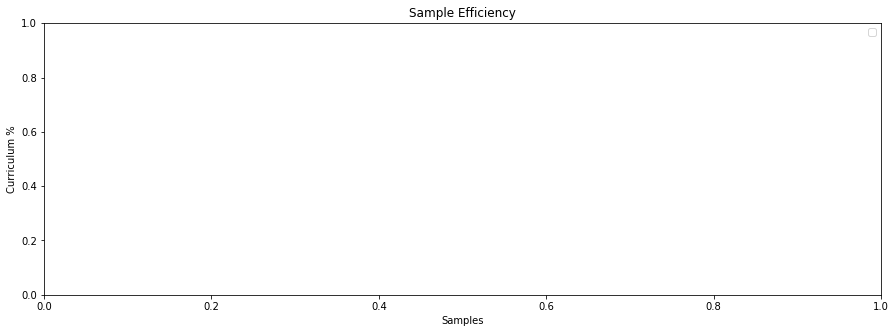

No files found with name 0540
couldn't plot PA
No files found with name 0541
couldn't plot CC1
No files found with name 0543
couldn't plot CC2
No files found with name 0545
couldn't plot CC3
No files found with name 0722
couldn't plot SUB
No files found with name 0481
couldn't plot None


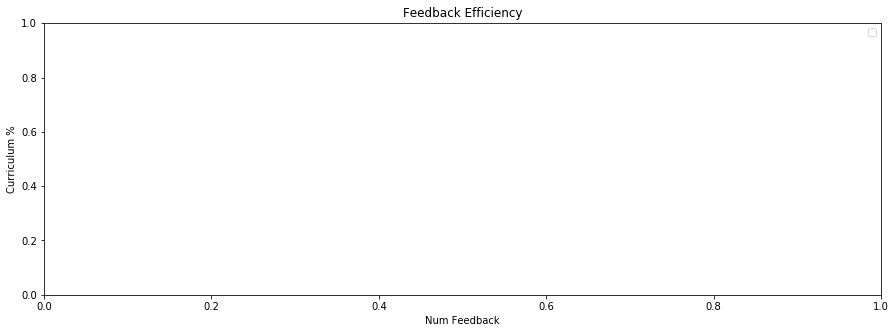

In [6]:
data_names = [
    (['0540'], 'PA'),
#     (['0577', '0578'], 'PA22'),
    (['0541', '0542'], 'CC1'),
    (['0543', '0544'], 'CC2'),
    (['0545', '0546'], 'CC3'),
    (['0722', '0723', '688'], 'SUB'),
#     (['0547', '0548'], 'SUB'),
    (['0481'], 'None'),
]

plot_curriculum(data_names, 'samples')

plot_curriculum(data_names, 'feedback')

No files found with name 0877
couldn't plot PA
No files found with name 0885
couldn't plot CC3
No files found with name 0895
couldn't plot PA->CC3
No files found with name 0887
couldn't plot SUB
No files found with name 0897
couldn't plot PA->SUB
No files found with name 0883
couldn't plot None


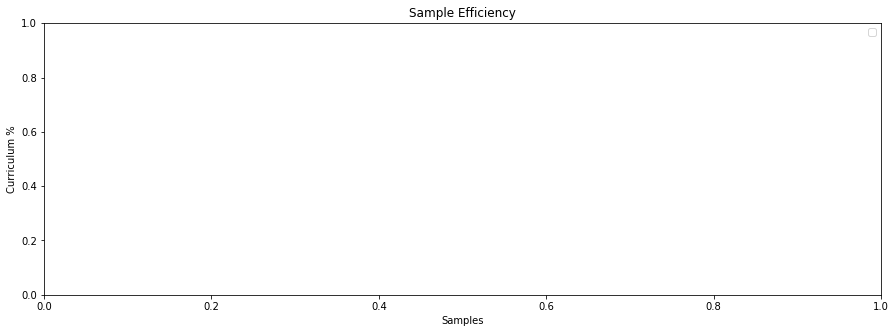

No files found with name 0877
couldn't plot PA
No files found with name 0885
couldn't plot CC3
No files found with name 0895
couldn't plot PA->CC3
No files found with name 0887
couldn't plot SUB
No files found with name 0897
couldn't plot PA->SUB
No files found with name 0883
couldn't plot None


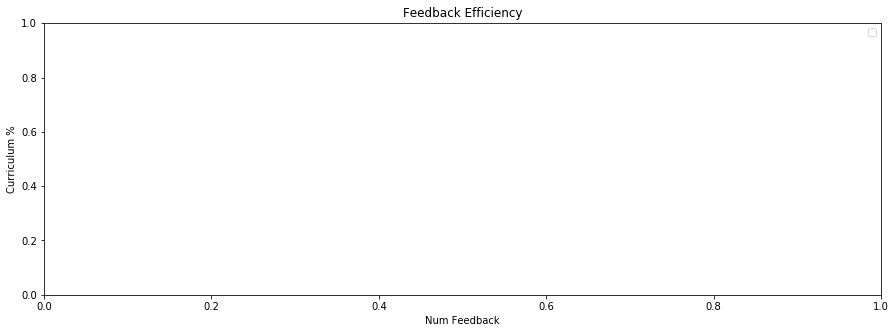

No files found with name 0877
couldn't plot PA
No files found with name 0885
couldn't plot CC3
No files found with name 0895
couldn't plot PA->CC3
No files found with name 0887
couldn't plot SUB
No files found with name 0897
couldn't plot PA->SUB


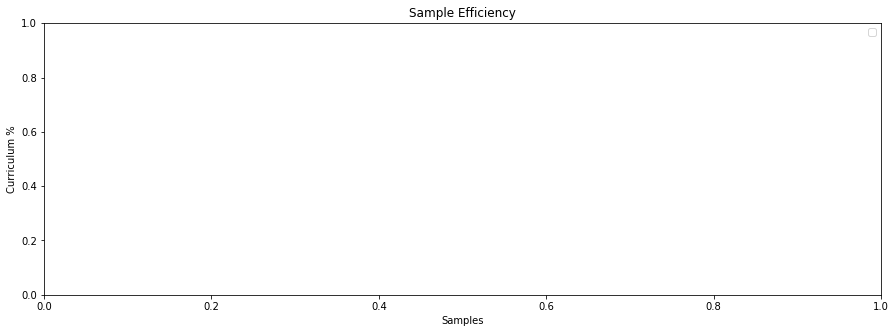

No files found with name 0877
couldn't plot PA
No files found with name 0885
couldn't plot CC3
No files found with name 0895
couldn't plot PA->CC3
No files found with name 0887
couldn't plot SUB
No files found with name 0897
couldn't plot PA->SUB


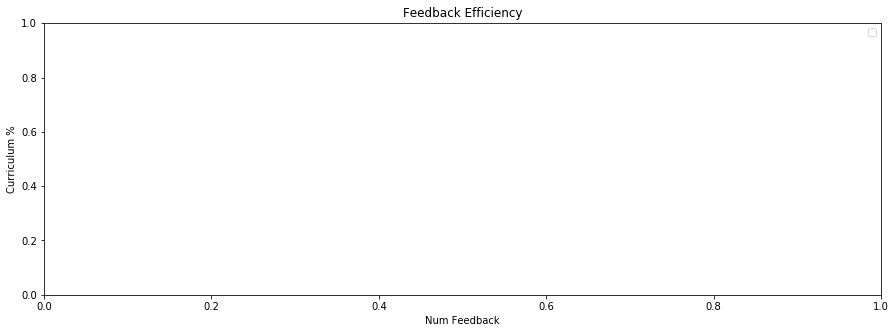

In [7]:
data_names = [ 
    (['0877', '0878'], 'PA'),
    (['0885', '0886'], 'CC3'),
    (['0895', '0896'], 'PA->CC3'),
    (['0887', '0888'], 'SUB'),
    (['0897', '0898'], 'PA->SUB'),
    (['0883', '0884'], 'None'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

# SAME, but no NONE
data_names = [ 
    (['0877', '0878'], 'PA'),
    (['0885', '0886'], 'CC3'),
    (['0895', '0896'], 'PA->CC3'),
    (['0887', '0888'], 'SUB'),
    (['0897', '0898'], 'PA->SUB'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

## <font color='green'>[HELPER] How close are we to the "best case" feedback efficiency (i.e. IL from oracle)</font>

Next steps: Once we re-run the RL runs with no 10-rule, replace them here.

If we're close, it's probably not worth trying to make the RL training process much more efficient.

(Is this the best case? I'm assuming IL > RL, but maybe not always true?)

No files found with name 0543
couldn't plot CC2
No files found with name 0656
couldn't plot CC2 Best


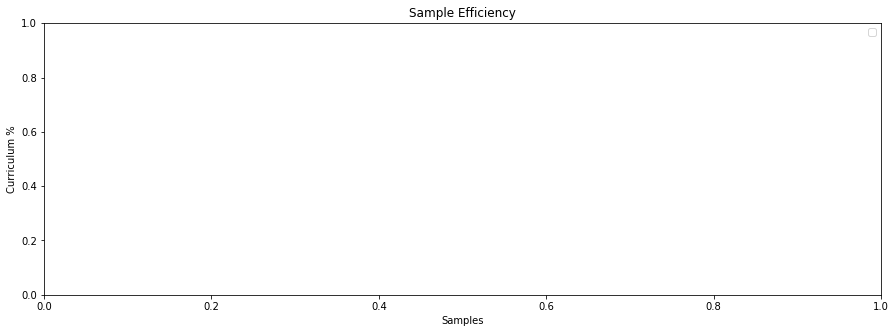

No files found with name 0545
couldn't plot CC3
No files found with name 658
couldn't plot CC3 Best


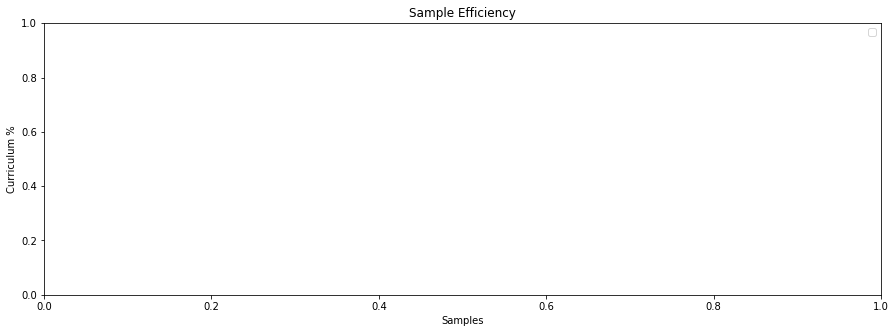

No files found with name 0547
couldn't plot SUB
No files found with name 0660
couldn't plot SUB Best


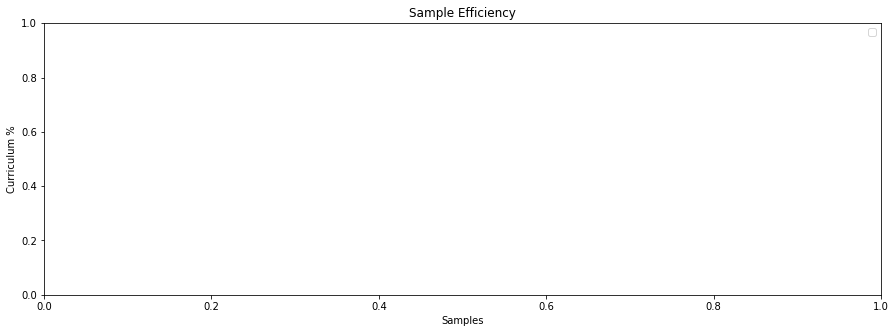

In [8]:
# NOTE: 'Best' runs didn't have the 10-rule, others did
data_names = [
    (['0543', '0544'], 'CC2'),
    (['0656'], 'CC2 Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0545', '0546'], 'CC3'),
    (['658'], 'CC3 Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0547', '0548'], 'SUB'),
    (['0660'], 'SUB Best'),
]
plot_curriculum(data_names, 'samples')

## <font color='green'> [HELPER] Does dropping instructions help? </font>

Understore_I means no instructions.

Conclusion: No real difference for most teachers. Possible improvmeent for SUB, but also may just be b/c we trained longer.

No files found with name 0539
couldn't plot PA
No files found with name 0597
couldn't plot PA_I
No files found with name 0543
couldn't plot CC2
No files found with name 0579
couldn't plot CC2_I
No files found with name 0545
couldn't plot CC3
No files found with name 0581
couldn't plot CC3_I


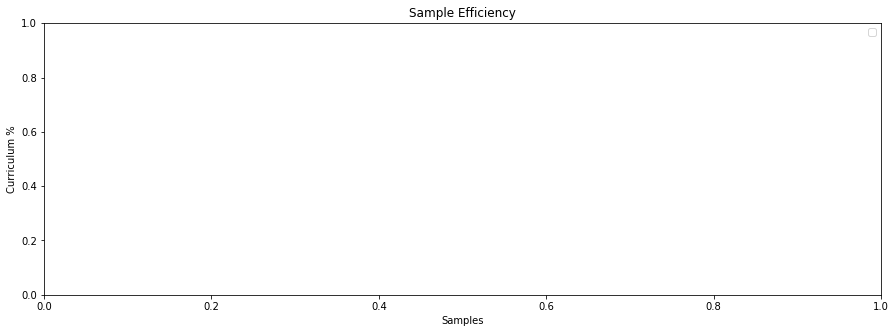

No files found with name 0547
couldn't plot SUB
No files found with name 0599
couldn't plot SUB_I


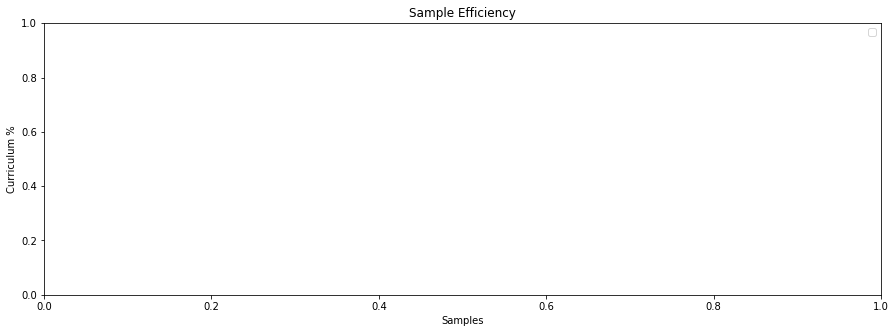

In [9]:
data_names = [
    (['0539', '0540'], 'PA'),
    (['0597', '0598'], 'PA_I'),
    (['0543', '0544'], 'CC2'),
    (['0579', '0580'], 'CC2_I'),
    (['0545', '0546'], 'CC3'),
    (['0581', '0582'], 'CC3_I'),
]

plot_curriculum(data_names, 'samples')


data_names = [
    (['0547', '0548'], 'SUB'),
    (['0599', '0600'], 'SUB_I'),
]

plot_curriculum(data_names, 'samples')

# <font color='blue'> Claim 1: Feedback helps the agent learn more quickly (distillation) </font>
## <font color='blue'> [Status: hard teachers get stuck, and no teachers outperform PA yet!] </font>



## <font color='blue'>[STATUS] - Need to work on sample-efficiency.</font>


If this isn't true for certain higher-level teachers that's fine, so long as we are able to show that the problem is grounding, but once grounded it does work better.

### GOOD NEWS: All agents trained with feedback outperform no teacher.

### BAD NEWS: Agents trained with complex teachers have a hard time completing the curriculum.

## <font color='blue'>[MAIN] Feedback Efficiency of Different Teachers </font>

No files found with name 0627
couldn't plot PA
No files found with name 0666
couldn't plot PA->CC3
No files found with name 0825
couldn't plot PA->CC3 NEW
No files found with name 0668
couldn't plot PA->SUB
Length 5341
Length 6183
No files found with name 0481
couldn't plot None
No files found with name 0623
couldn't plot Supervised


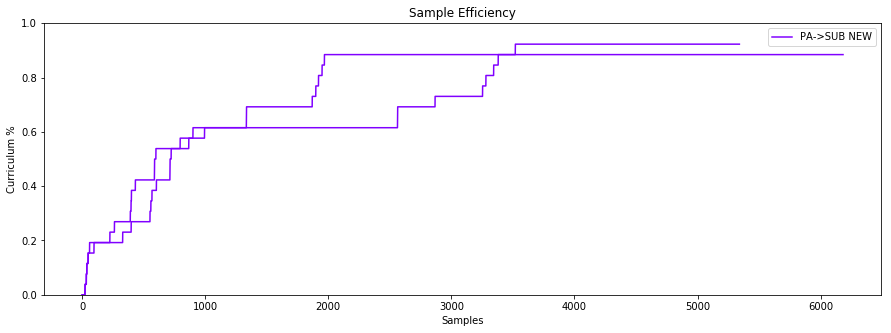

No files found with name 0627
couldn't plot PA
No files found with name 0666
couldn't plot PA->CC3
No files found with name 0825
couldn't plot PA->CC3 NEW
No files found with name 0668
couldn't plot PA->SUB
Length 5341
Length 6183
No files found with name 0481
couldn't plot None
No files found with name 0623
couldn't plot Supervised


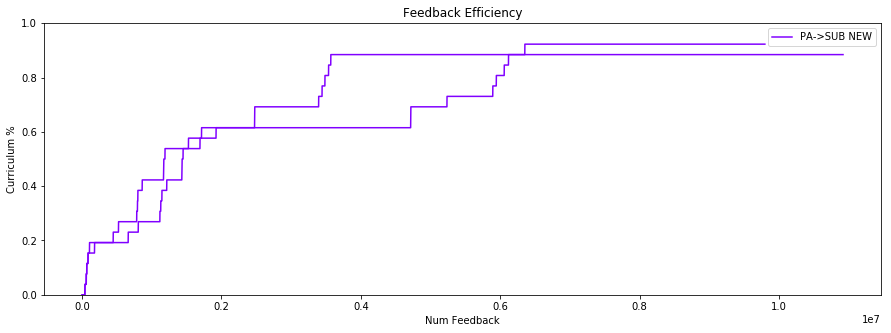

No files found with name 0627
couldn't plot PA
No files found with name 0666
couldn't plot PA->CC3
No files found with name 0825
couldn't plot PA->CC3 NEW
No files found with name 0668
couldn't plot PA->SUB
Length 5341
Length 6183


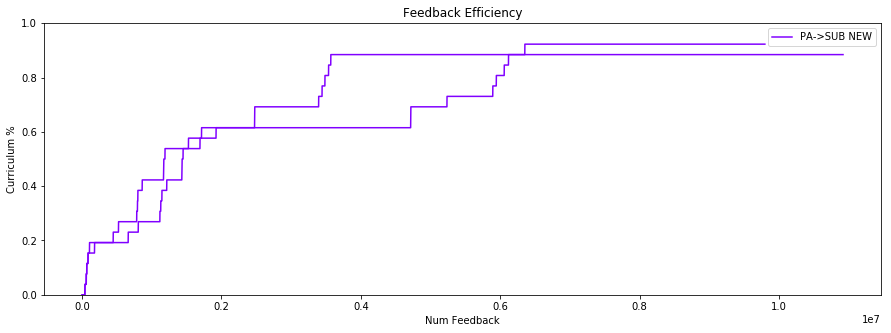

In [10]:
# OLD ENTROPY -seems to do better with .001
data_names = [  # TODO: re-run these 
    (['0627', '0628'], 'PA'),
#     (['0753', '0754'], 'PA2'),
#     (['0629', '0630'], 'CC1'),
#     (['0631', '0632'], 'CC2'),
#     (['0633', '0634'], 'CC3'),
    (['0666', '0667'], 'PA->CC3'),
    (['0825', '0826'], 'PA->CC3 NEW'),
#     (['0635', '0636'], 'SUB'),
    (['0668', '0669'], 'PA->SUB'),
    (['827', '828'], 'PA->SUB NEW'),
#     (['0664'], 'SUB BIG'),
    (['0481'], 'None'),
    (['0623', '0624'], 'Supervised'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')
data_names = data_names[:-2]
# Same as before, but no None so it rescales
plot_curriculum(data_names, 'feedback')
# TODO: plot TotalNumFeedback during collection so we get it even when doing supervised runs

No files found with name 0627
couldn't plot PA
No files found with name T1252
couldn't plot Oracle-> CC3 1252
No files found with name 0481
couldn't plot None
No files found with name 0623
couldn't plot Supervised


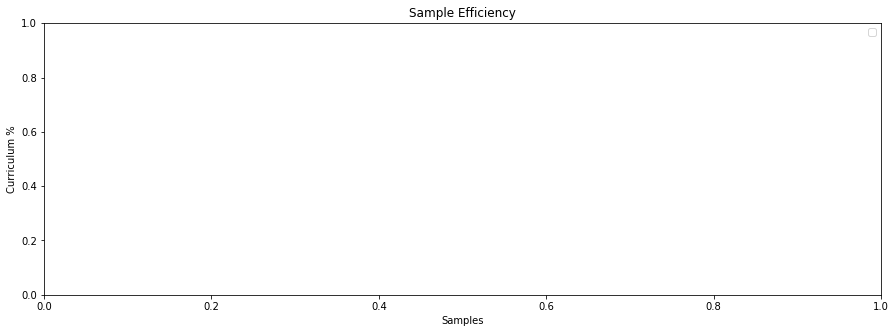

No files found with name 0627
couldn't plot PA
No files found with name T1252
couldn't plot Oracle-> CC3 1252
No files found with name 0481
couldn't plot None
No files found with name 0623
couldn't plot Supervised


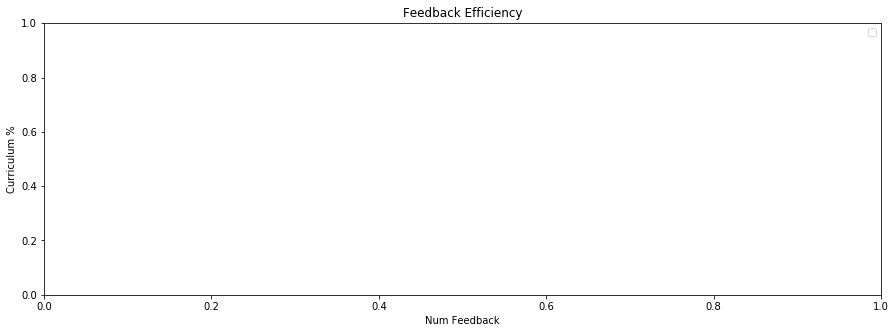

No files found with name 0627
couldn't plot PA
No files found with name T1252
couldn't plot Oracle-> CC3 1252


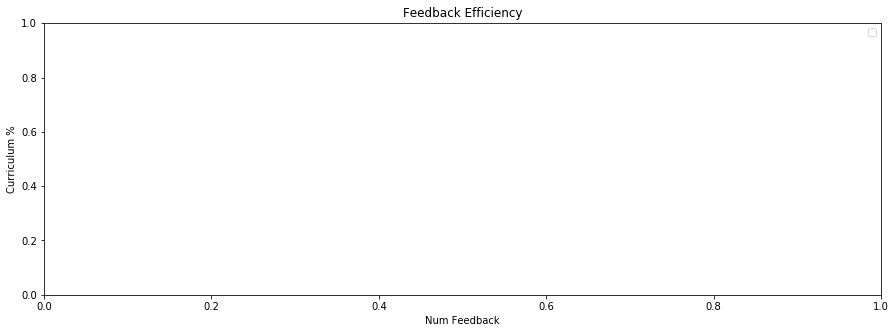

In [11]:
# OLD ENTROPY -seems to do better with .001
data_names = [  # TODO: re-run these 
    (['0627', '0628'], 'PA'),
#     (['0666', '0667'], 'PA->CC3'),
#     (['0825', '0826'], 'PA->CC3 NEW'),
    (['T1252',], 'Oracle-> CC3 1252'),
#     (['T1254',], 'Oracle-> CC3 1254'),
#     (['T1255',], 'Oracle-> CC3 1255'),
#     (['T1256',], 'Oracle-> CC3 1256'),
    (['0481'], 'None'),
    (['0623', '0624'], 'Supervised'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')
data_names = data_names[:-2]
# Same as before, but no None so it rescales
plot_curriculum(data_names, 'feedback')
# TODO: plot TotalNumFeedback during collection so we get it even when doing supervised runs

Length 2261
Length 2417
No files found with name 0889
couldn't plot CC3
Length 3954
Length 4051
No files found with name 0891
couldn't plot SUB
Length 8933
Length 8532
No files found with name 0883
couldn't plot None
No files found with name 0623
couldn't plot Supervised


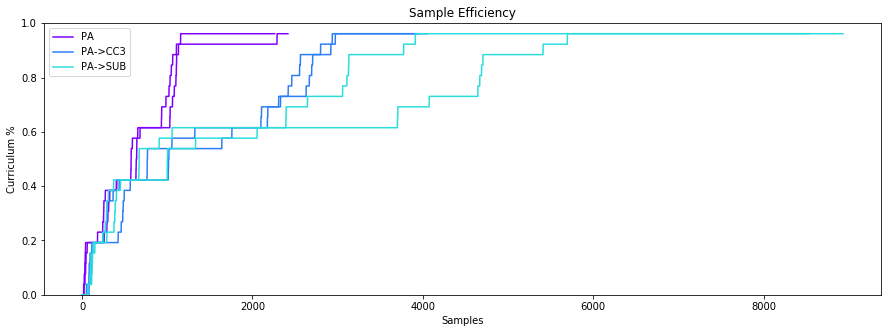

Length 2261
Length 2417
No files found with name 0889
couldn't plot CC3
Length 3954
Length 4051
No files found with name 0891
couldn't plot SUB
Length 8933
Length 8532
No files found with name 0883
couldn't plot None
No files found with name 0623
couldn't plot Supervised


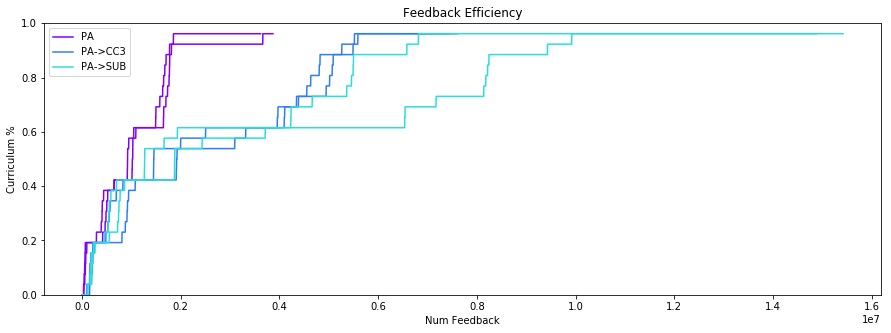

Length 2261
Length 2417
No files found with name 0889
couldn't plot CC3
Length 3954
Length 4051
No files found with name 0891
couldn't plot SUB
Length 8933
Length 8532


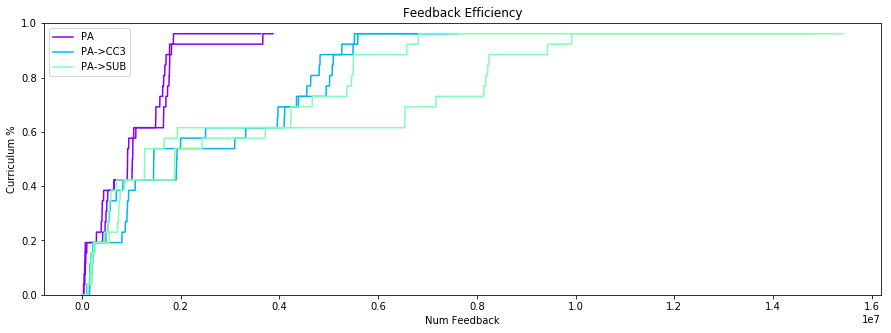

In [12]:
data_names = [  # TODO: re-run these 
    (['867', '868'], 'PA'),
    (['0889', '0890'], 'CC3'),
    (['869', '870'], 'PA->CC3'),
    (['0891', '0892'], 'SUB'),
    (['871', '872'], 'PA->SUB'),
    (['0883', '0884'], 'None'),
    (['0623', '0624'], 'Supervised'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')
data_names = data_names[:-2]
# Same as before, but no None so it rescales
plot_curriculum(data_names, 'feedback')
# TODO: plot TotalNumFeedback during collection so we get it even when doing supervised runs

No files found with name 0825
couldn't plot PA->CC3 NEW3
Length 5385
Length 4667


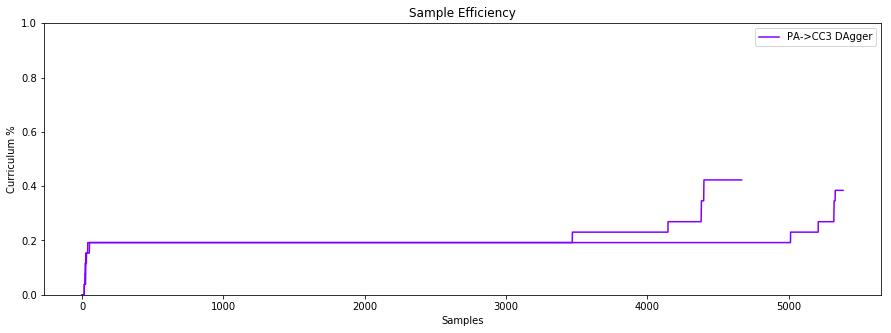

Length 5341
Length 6183
Length 5753
Length 3971


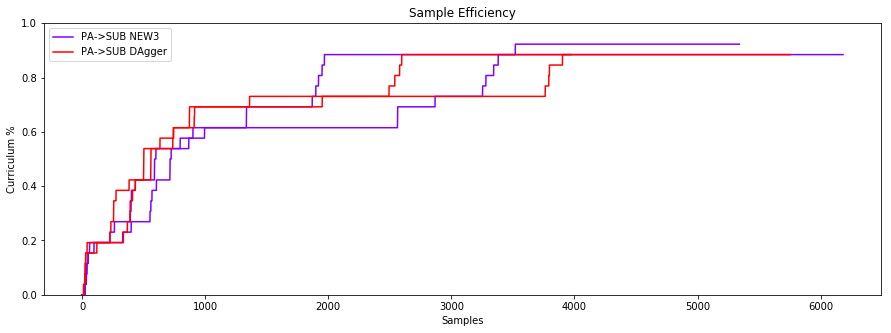

In [13]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['084_', '842'], 'PA->CC3 DAgger'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['827', '828'], 'PA->SUB NEW3'),
    (['843', '844'], 'PA->SUB DAgger'), #844
]
plot_curriculum(data_names, 'samples')


Length 946
Length 1193
No files found with name 0627
couldn't plot PA
No files found with name 0753
couldn't plot PA NEW


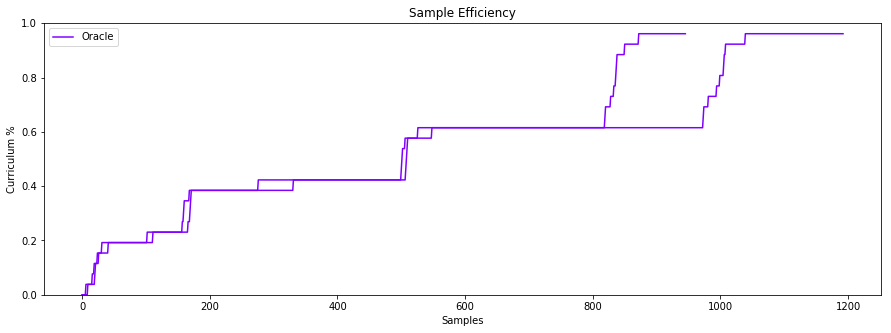

Length 946
Length 1193
No files found with name 0627
couldn't plot PA
No files found with name 0753
couldn't plot PA NEW


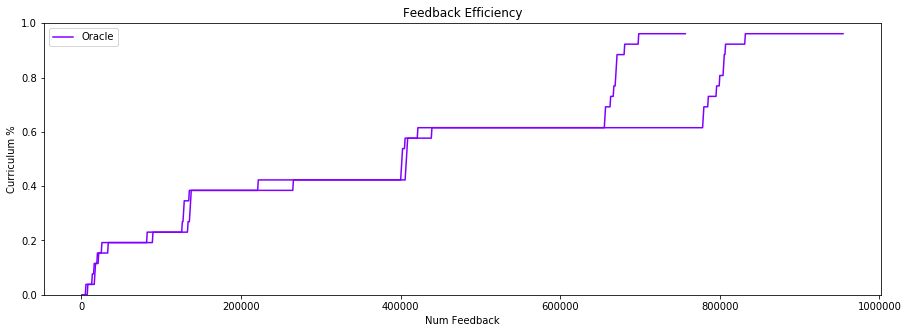

In [14]:
# HOW CLOSE IS PA DISTILL TO ORACLE DISTILL?
data_names = [  # TODO: re-run these 
    (['799', '800'], 'Oracle'),
    (['0627', '0628'], 'PA'),
    (['0753', '0754'], 'PA NEW'),
#     (['0787', '0788'], 'PA NEW2'),
#     (['0759', '0760'], 'PA PRETRAINED'),
#     (['0793', '0794'], 'PA PRETRAINED2'),
#     (['801', '802'], 'PA Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')



## <font color='blue'>[HELPER] How close are we to the "best case" feedback efficiency (i.e. distill from pretrained model)</font>

No files found with name 0779
couldn't plot PA (note: hparams don't match)
No files found with name 0655
couldn't plot PA Best


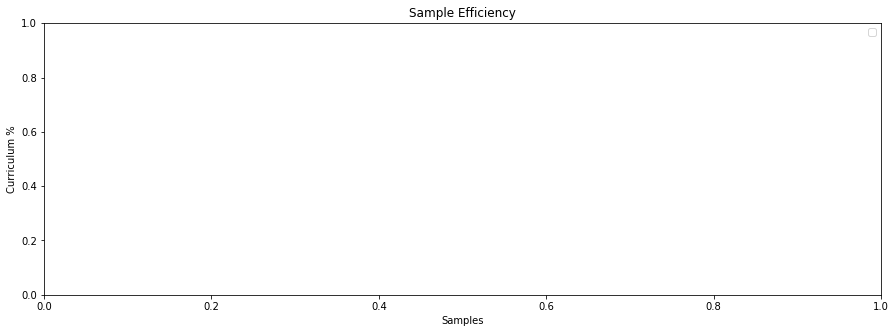

Length 2070
Length 2521
No files found with name 659
couldn't plot CC3 Best


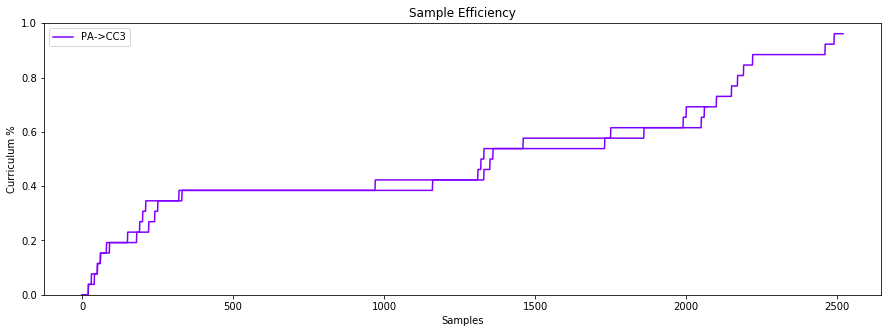

Length 9601
Length 7210
No files found with name 661
couldn't plot SUB Best


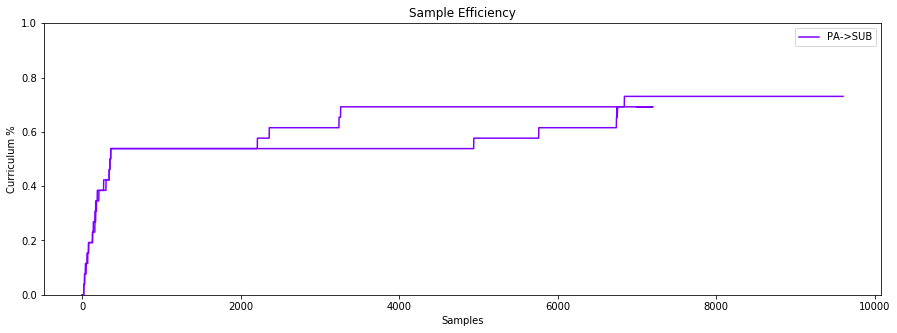

In [15]:
# NO DISTILLATION TO NO TEACHER (collect oracle, distill to teacher)
data_names = [
    (['0779', '0780'], "PA (note: hparams don't match)"),
    (['0655'], 'PA Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['639', '640'], 'PA->CC3'),
    (['659'], 'CC3 Best'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['641', '642'], 'PA->SUB'),
    (['661'], 'SUB Best'),
]
plot_curriculum(data_names, 'samples')

No files found with name 0654
couldn't plot PA Best
No files found with name 0654
couldn't plot PA Best
No files found with name 0623
couldn't plot Oracle


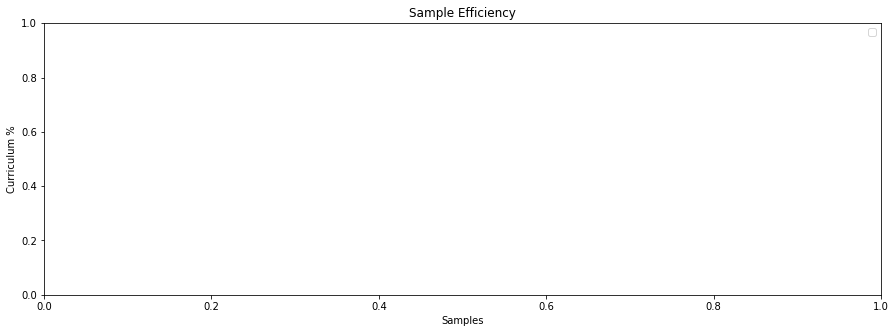

No files found with name 0631
couldn't plot CC2
No files found with name 0656
couldn't plot CC2 Best
No files found with name 0623
couldn't plot Oracle


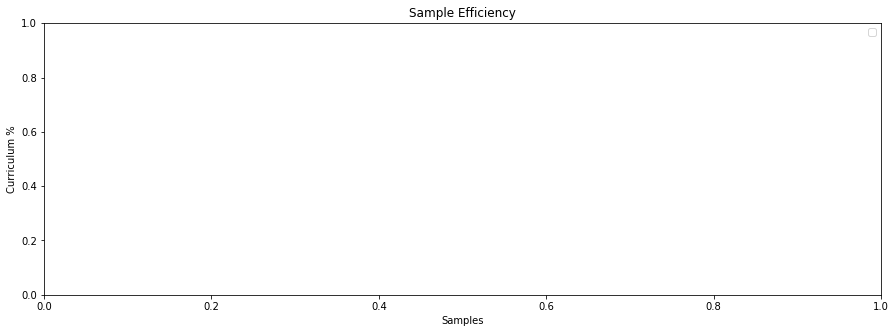

No files found with name 0666
couldn't plot PA->CC3
No files found with name 658
couldn't plot CC3 Best
No files found with name 0623
couldn't plot Oracle


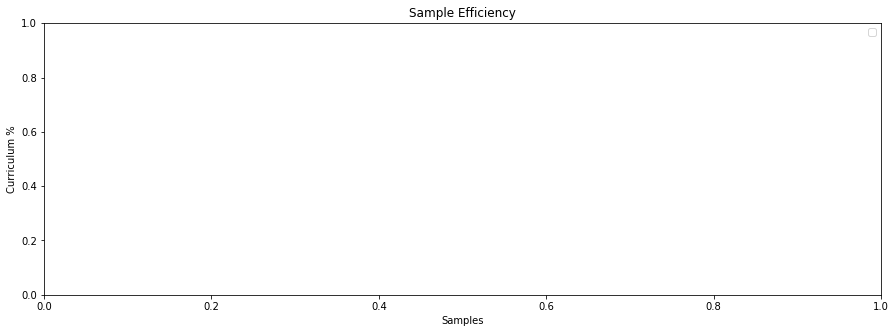

No files found with name 0668
couldn't plot PA->SUB
No files found with name 0660
couldn't plot SUB Best
No files found with name 0623
couldn't plot Oracle


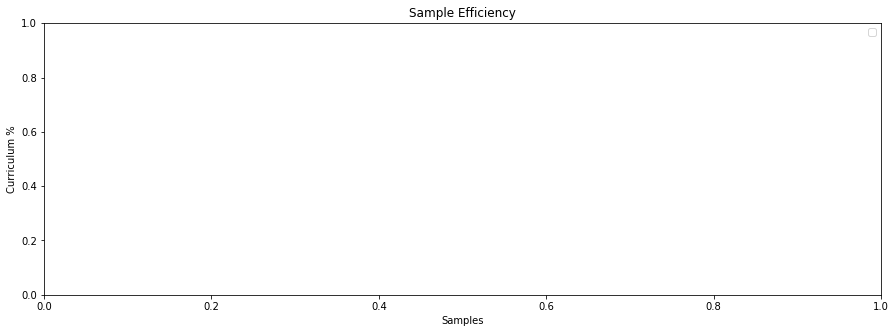

In [16]:
# YES DISTILLATION (collect with pretrained model, distill to no teacher)
# NOTE: HPARAMs are out of date
    
data_names = [
    (['0654'], 'PA Best'),
    (['0654'], 'PA Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0631', '0632'], 'CC2'),
    (['0656'], 'CC2 Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0666', '0667'], 'PA->CC3'),
    (['658'], 'CC3 Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0668', '0669'], 'PA->SUB'),
    (['0660'], 'SUB Best'),
    (['0623', '0624'], 'Oracle'),
]
plot_curriculum(data_names, 'samples')

# <font color='purple'> Claim 2: Policies conditioned on feedback can generalize zero-shot to performing new tasks (no distillation). </font> <font color='red'> [TODO: plot generalization results for the recent exps] </font>

## <font color='purple'> [Status: Easy teachers generalize zero-shot, but hard teachers don't.] </font>

## <font color='purple'>[STATUS] - Easy teachers generalize zero-shot, but hard teachers don't. </font>

(The new levels should not have any new feedback vocabulary.)

### GOOD NEWS: all the teachers outperform not having a teacher
### BAD NEWS: the higher-level teachers are way worse than the easy teacher... we should find a way to learn those better.


## <font color='purple'>[MAIN] Feedback Efficiency of Different Teachers </font>

CURRENT PROBLEMS

PA - Teacher itself is failing??

CC1 - Beautiful and awesome. Unclear why it doesn't run into the same problems as PA

CC2 - can't open doors??

CC3 - wanders randomly

CC4 - wanders randomly/spins in circles

SUB - spins in circles

NONE - A bit of wandering, but also doesn't want to open doors.

TODO: check existing door levels in the train set. Maybe it just forgot them and we need curriculum smoothing?



## Comparing Across Teachers

In [17]:
runs = [
    (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_635_NOFINETUNE', 'EVAL_636_NOFINETUNE'], 'PA -> SUB'),
    (['EVAL_668_NOFINETUNE', 'EVAL_669_NOFINETUNE'], 'PA -> SUB Distill'),
]
plot_final_generalization(runs, 'Eval with Teacher - SUB') # kangaroo

Error on  ['EVAL_547', 'EVAL_548'] No files found with name EVAL_547
Error on  ['EVAL_635_NOFINETUNE', 'EVAL_636_NOFINETUNE'] No files found with name EVAL_635_NOFINETUNE
Error on  ['EVAL_668_NOFINETUNE', 'EVAL_669_NOFINETUNE'] No files found with name EVAL_668_NOFINETUNE
ENV DICT dict_keys([])


In [18]:
runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
    (['EVAL_541', 'EVAL_542'], 'CC1'),
    (['EVAL_543', 'EVAL_544'], 'CC2'),
    (['EVAL_545', 'EVAL_546'], 'CC3'),
#     (['0722', '0723', '688'], 'SUB'),
    (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_NONE_LOWD'], 'NONE'),
    (['EVAL_557', 'EVAL_558'], 'CC2_D'),
    (['EVAL_559', 'EVAL_560'], 'CC3_D'),
    (['EVAL_561', 'EVAL_562'], 'SUB_D'),
    (['EVAL_563', 'EVAL_564'], 'CC2_S'),
    (['EVAL_565'], 'CC3_S'),
    (['EVAL_568'], 'SUB_S'),
]

plot_final_generalization(runs, 'Eval with Teacher')

Error on  ['EVAL_539', 'EVAL_540'] No files found with name EVAL_539
Error on  ['EVAL_541', 'EVAL_542'] No files found with name EVAL_541
Error on  ['EVAL_543', 'EVAL_544'] No files found with name EVAL_543
Error on  ['EVAL_545', 'EVAL_546'] No files found with name EVAL_545
Error on  ['EVAL_547', 'EVAL_548'] No files found with name EVAL_547
Error on  ['EVAL_NONE_LOWD'] No files found with name EVAL_NONE_LOWD
Error on  ['EVAL_557', 'EVAL_558'] No files found with name EVAL_557
Error on  ['EVAL_559', 'EVAL_560'] No files found with name EVAL_559
Error on  ['EVAL_561', 'EVAL_562'] No files found with name EVAL_561
Error on  ['EVAL_563', 'EVAL_564'] No files found with name EVAL_563
Error on  ['EVAL_565'] No files found with name EVAL_565
Error on  ['EVAL_568'] No files found with name EVAL_568
ENV DICT dict_keys([])


In [19]:
# WITH DISTILLATION
runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
#     (['EVAL_541', 'EVAL_542'], 'CC1'),
#     (['EVAL_543', 'EVAL_544'], 'CC2'),
#     (['EVAL_545', 'EVAL_546'], 'CC3'),
#     (['0722', '0723', '688'], 'SUB'),
#     (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_NONE_LOWD'], 'NONE'),
    (['EVAL_557', 'EVAL_558'], 'CC2_D'),
    (['EVAL_559', 'EVAL_560'], 'CC3_D'),
    (['EVAL_561', 'EVAL_562'], 'SUB_D'),
    (['EVAL_563', 'EVAL_564'], 'CC2_S'),
    (['EVAL_565'], 'CC3_S'),
    (['EVAL_568'], 'SUB_S'),
]

plot_final_generalization(runs, 'Eval with Teacher')

Error on  ['EVAL_539', 'EVAL_540'] No files found with name EVAL_539
Error on  ['EVAL_NONE_LOWD'] No files found with name EVAL_NONE_LOWD
Error on  ['EVAL_557', 'EVAL_558'] No files found with name EVAL_557
Error on  ['EVAL_559', 'EVAL_560'] No files found with name EVAL_559
Error on  ['EVAL_561', 'EVAL_562'] No files found with name EVAL_561
Error on  ['EVAL_563', 'EVAL_564'] No files found with name EVAL_563
Error on  ['EVAL_565'] No files found with name EVAL_565
Error on  ['EVAL_568'] No files found with name EVAL_568
ENV DICT dict_keys([])


In [20]:
runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
    (['EVAL_577'], 'PA - Sparse'),
    (['EVAL_627_NOFINETUNE'], 'PA - Distill'),
#     (['0706'], 'PA - Self-Distill'),
#     (['0677', '0678'], 'PA - No 10 Rule'),
    (['EVAL_655'], 'PA - BCS'),
    (['EVAL_627_FINETUNE'], 'PA - Distill (Finetune, eval no teacher)'),
#     (['692', '693'], 'PA - Big Batch No Distill'),
#     (['698', '699'], 'PA - Big Batch Distill'),
]
plot_final_generalization(runs, 'Eval with Teacher')

Error on  ['EVAL_539', 'EVAL_540'] No files found with name EVAL_539
Error on  ['EVAL_577'] No files found with name EVAL_577
Error on  ['EVAL_627_NOFINETUNE'] No files found with name EVAL_627_NOFINETUNE
Error on  ['EVAL_655'] No files found with name EVAL_655
Error on  ['EVAL_627_FINETUNE'] No files found with name EVAL_627_FINETUNE
ENV DICT dict_keys([])


In [21]:
plt.rcParams['figure.figsize'] = [15, 5]
runs = [
    (['EVAL_885_NOFINETUNE', 'EVAL_886_NOFINETUNE'], 'CC3'),
    (['EVAL_895_NOFINETUNE', 'EVAL_896_NOFINETUNE'], 'PA -> CC3'),
    (['EVAL_821_NOFINETUNE', 'EVAL_822_NOFINETUNE'], 'PA -> CC3 Distill'),
    (['EVAL_889_NOFINETUNE', 'EVAL_890_NOFINETUNE'], 'CC3 Distill'),
    (['EVAL_659_NOFINETUNE'], 'Distill to CC3 from Oracle'),
    (['EVAL_851_NOFINETUNE'], 'Distill to CC3 from Pretrained PA'),
    (['EVAL_873_NOFINETUNE', 'EVAL_874_NOFINETUNE'], 'Pa -> CC3 High Accuracy'),
    (['EVAL_869_NOFINETUNE', 'EVAL_870_NOFINETUNE'], 'PA -> CC3 More Distillation'),
    (['EVAL_863_NOFINETUNE', 'EVAL_864_NOFINETUNE'], 'PA -> CC3 Less Biased Distribution'),
    
    
    
    (['EVAL_1252_NOFINETUNE'], 'Oracle -> CC3 1252'),
    (['EVAL_1254_NOFINETUNE'], 'Oracle -> CC3 1254'),
    (['EVAL_1255_NOFINETUNE'], 'Oracle -> CC3 1255'),
    (['EVAL_1256_NOFINETUNE'], 'Oracle -> CC3 1256'),
]
plot_final_generalization(runs, 'Eval with Teacher - CC3')

Error on  ['EVAL_885_NOFINETUNE', 'EVAL_886_NOFINETUNE'] No files found with name EVAL_885_NOFINETUNE
Error on  ['EVAL_895_NOFINETUNE', 'EVAL_896_NOFINETUNE'] No files found with name EVAL_895_NOFINETUNE
Error on  ['EVAL_821_NOFINETUNE', 'EVAL_822_NOFINETUNE'] No files found with name EVAL_821_NOFINETUNE
Error on  ['EVAL_889_NOFINETUNE', 'EVAL_890_NOFINETUNE'] No files found with name EVAL_889_NOFINETUNE
Error on  ['EVAL_659_NOFINETUNE'] No files found with name EVAL_659_NOFINETUNE
Error on  ['EVAL_851_NOFINETUNE'] No files found with name EVAL_851_NOFINETUNE
Error on  ['EVAL_873_NOFINETUNE', 'EVAL_874_NOFINETUNE'] No files found with name EVAL_873_NOFINETUNE
Error on  ['EVAL_869_NOFINETUNE', 'EVAL_870_NOFINETUNE'] No files found with name EVAL_869_NOFINETUNE
Error on  ['EVAL_863_NOFINETUNE', 'EVAL_864_NOFINETUNE'] No files found with name EVAL_863_NOFINETUNE
Error on  ['EVAL_1252_NOFINETUNE'] No files found with name EVAL_1252_NOFINETUNE
Error on  ['EVAL_1254_NOFINETUNE'] No files fou

## Grounding CC3 Well

### Does distilling to no teacher matter? [no difference]

In [22]:

plt.rcParams['figure.figsize'] = [5, 5]
runs = [
#     (['EVAL_1333_NOFINETUNE_INSTRS'], 'No distill to None Instr'),
    (['EVAL_1333_NOFINETUNE_NOINSTR'], 'No distill to no teacher'),
#     (['EVAL_1330_NOFINETUNE_INSTR'], 'Distill to None Instr'),
    (['EVAL_1330_NOFINETUNE_NOINSTR'], 'Distill to no teacher'),
    
]
plot_final_generalization(runs, 'Does distilling to no teacher matter?')
print("=" * 100)
plot_final_generalization(runs, 'Does distilling to no teacher matter?', ' stoch_accuracy')

Error on  ['EVAL_1333_NOFINETUNE_NOINSTR'] No files found with name EVAL_1333_NOFINETUNE_NOINSTR
Error on  ['EVAL_1330_NOFINETUNE_NOINSTR'] No files found with name EVAL_1330_NOFINETUNE_NOINSTR
ENV DICT dict_keys([])
Error on  ['EVAL_1333_NOFINETUNE_NOINSTR'] No files found with name EVAL_1333_NOFINETUNE_NOINSTR
Error on  ['EVAL_1330_NOFINETUNE_NOINSTR'] No files found with name EVAL_1330_NOFINETUNE_NOINSTR
ENV DICT dict_keys([])


### Does providing the teacher at eval time matter? [helps significantly]

In [23]:

plt.rcParams['figure.figsize'] = [8, 5]
runs = [
    (['EVAL_1361_NOFINETUNE_INSTRS_SIMPLE'], 'CC3 Teacher'),
    (['EVAL_1361_NOFINETUNE_NOTEACHER'], 'NoTeacher'),
    
]
plot_final_generalization(runs, 'Eval with Teacher - CC3')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - CC3', ' stoch_accuracy')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - CC3', ' followed_cc3 ')

Error on  ['EVAL_1361_NOFINETUNE_INSTRS_SIMPLE'] No files found with name EVAL_1361_NOFINETUNE_INSTRS_SIMPLE
Error on  ['EVAL_1361_NOFINETUNE_NOTEACHER'] No files found with name EVAL_1361_NOFINETUNE_NOTEACHER
ENV DICT dict_keys([])
Error on  ['EVAL_1361_NOFINETUNE_INSTRS_SIMPLE'] No files found with name EVAL_1361_NOFINETUNE_INSTRS_SIMPLE
Error on  ['EVAL_1361_NOFINETUNE_NOTEACHER'] No files found with name EVAL_1361_NOFINETUNE_NOTEACHER
ENV DICT dict_keys([])
Error on  ['EVAL_1361_NOFINETUNE_INSTRS_SIMPLE'] No files found with name EVAL_1361_NOFINETUNE_INSTRS_SIMPLE
Error on  ['EVAL_1361_NOFINETUNE_NOTEACHER'] No files found with name EVAL_1361_NOFINETUNE_NOTEACHER
ENV DICT dict_keys([])


### Does rolling out with stochastic or argmax sampling matter? [stoch is marginally better]

In [24]:
runs = [
    (['EVAL_1361_NOFINETUNE_INSTRS_L22_24_STOCH'], '1361 INSTRS L22 24'),
    (['EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_STOCH'], '1361 NOINSTRS L22 24'),
    (['EVAL_1361_NOFINETUNE_INSTRS_L22_24_DET'], '1361 INSTRS L22 24 DET'),
    (['EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_DET'], '1361 NOINSTRS L22 24 DET'),
]
plot_final_generalization(runs, 'Eval with Teacher - CC3')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - CC3', ' stoch_accuracy')

Error on  ['EVAL_1361_NOFINETUNE_INSTRS_L22_24_STOCH'] No files found with name EVAL_1361_NOFINETUNE_INSTRS_L22_24_STOCH
Error on  ['EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_STOCH'] No files found with name EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_STOCH
Error on  ['EVAL_1361_NOFINETUNE_INSTRS_L22_24_DET'] No files found with name EVAL_1361_NOFINETUNE_INSTRS_L22_24_DET
Error on  ['EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_DET'] No files found with name EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_DET
ENV DICT dict_keys([])
Error on  ['EVAL_1361_NOFINETUNE_INSTRS_L22_24_STOCH'] No files found with name EVAL_1361_NOFINETUNE_INSTRS_L22_24_STOCH
Error on  ['EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_STOCH'] No files found with name EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_STOCH
Error on  ['EVAL_1361_NOFINETUNE_INSTRS_L22_24_DET'] No files found with name EVAL_1361_NOFINETUNE_INSTRS_L22_24_DET
Error on  ['EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_DET'] No files found with name EVAL_1361_NOFINETUNE_NOINSTRS_L22_24_DET
ENV DICT 

### Does providing the instructions at eval time matter? [hiding instrs helps]

In [25]:
runs = [
    (['EVAL_1359_NOFINETUNE_INSTRS'], '1359 INSTRS'),
    (['EVAL_1359_NOFINETUNE_NOINSTRS'], '1359 NOINSTRS'),
#     (['EVAL_1359_NOFINETUNE_NOTEACHER'], '1359 NOTEACHER'),
    (['EVAL_1361_NOFINETUNE_INSTRS_SIMPLE'], '1361 INSTRS'),
    (['EVAL_1361_NOFINETUNE_NOINSTRS_SIMPLE'], '1361 NOINSTRS'),
#     (['EVAL_1361_NOFINETUNE_NOTEACHER'], '1361 NOTEACHER'),
]
plot_final_generalization(runs, 'Eval with Teacher - CC3')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - CC3', ' stoch_accuracy')

Error on  ['EVAL_1359_NOFINETUNE_INSTRS'] No files found with name EVAL_1359_NOFINETUNE_INSTRS
Error on  ['EVAL_1359_NOFINETUNE_NOINSTRS'] No files found with name EVAL_1359_NOFINETUNE_NOINSTRS
Error on  ['EVAL_1361_NOFINETUNE_INSTRS_SIMPLE'] No files found with name EVAL_1361_NOFINETUNE_INSTRS_SIMPLE
Error on  ['EVAL_1361_NOFINETUNE_NOINSTRS_SIMPLE'] No files found with name EVAL_1361_NOFINETUNE_NOINSTRS_SIMPLE
ENV DICT dict_keys([])
Error on  ['EVAL_1359_NOFINETUNE_INSTRS'] No files found with name EVAL_1359_NOFINETUNE_INSTRS
Error on  ['EVAL_1359_NOFINETUNE_NOINSTRS'] No files found with name EVAL_1359_NOFINETUNE_NOINSTRS
Error on  ['EVAL_1361_NOFINETUNE_INSTRS_SIMPLE'] No files found with name EVAL_1361_NOFINETUNE_INSTRS_SIMPLE
Error on  ['EVAL_1361_NOFINETUNE_NOINSTRS_SIMPLE'] No files found with name EVAL_1361_NOFINETUNE_NOINSTRS_SIMPLE
ENV DICT dict_keys([])


### Does finetuning help? [no???]

In [26]:
runs = [
#     (['T1372'], 'Unlock finetune'),
    (['T1438'], '1390 Oracle -> PA3'),
    (['T1439'], '1419 Oracle -> PA3 10 distillation steps'),
    (['T1440'], '1420 Oracle -> PA3 20+ itrs per level'),
    (['T1441'], '1421 Oracle -> PA3 10+ itrs per level'),
]
plot_final_generalization(runs, 'Eval with Teacher - PA3')
print("=" * 1000)
plot_final_generalization(runs, 'Eval with Teacher - PA3', ' stoch_accuracy')

Error on  ['T1438'] No files found with name T1438
Error on  ['T1439'] No files found with name T1439
Error on  ['T1440'] No files found with name T1440
Error on  ['T1441'] No files found with name T1441
ENV DICT dict_keys([])
Error on  ['T1438'] No files found with name T1438
Error on  ['T1439'] No files found with name T1439
Error on  ['T1440'] No files found with name T1440
Error on  ['T1441'] No files found with name T1441
ENV DICT dict_keys([])


In [27]:
runs = [
#     (['EVAL_1361_FINETUNE_10ITRS_INSTRS'], '1361 INSTRS'),
#     (['EVAL_1361_FINETUNE_10ITRS_NOINSTRS_FNI'], '1361 NO INSTRS'),
#     (['EVAL_1361_FINETUNE_10ITRS_NOINSTRS_GOODLOG'], '1361 NO INSTRS GOODLOG'),
    (['T1372'], 'Unlock finetune'),
#     (['T1373'], 'Open finetune'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - CC3')
# print("=" * 1000)
plot_finetune_generalization(runs, 'Eval with Teacher - CC3', ' stoch_accuracy')
# print("=" * 1000)
plot_finetune_generalization(runs, 'Eval with Teacher - CC3', ' followed_cc3')

legend name Unlock finetune
run name T1372
Error on  ['T1372'] ("Didn't find exactly 1 run name", [])
COLELCTED! dict_keys([])
legend name Unlock finetune
run name T1372
Error on  ['T1372'] ("Didn't find exactly 1 run name", [])
COLELCTED! dict_keys([])
legend name Unlock finetune
run name T1372
Error on  ['T1372'] ("Didn't find exactly 1 run name", [])
COLELCTED! dict_keys([])


### <font color='magenta'> 0-shot PA accuracy </font>
### <font color='orange'> TODO: Add dicts; TODO: try no instrs on level trained with RL dropout </font>

CONLCUSION: PA acc/success are GREAT when instrs are present, less good when instrs are hidden.

ENV DICT dict_keys(['Level_Unlock', 'Level_Open'])


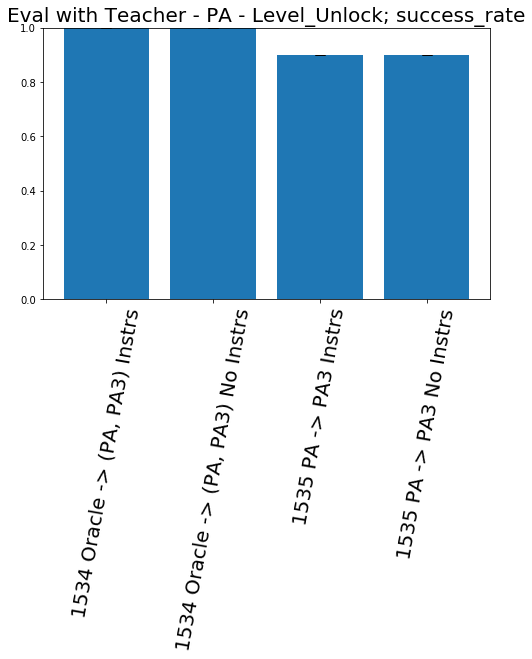

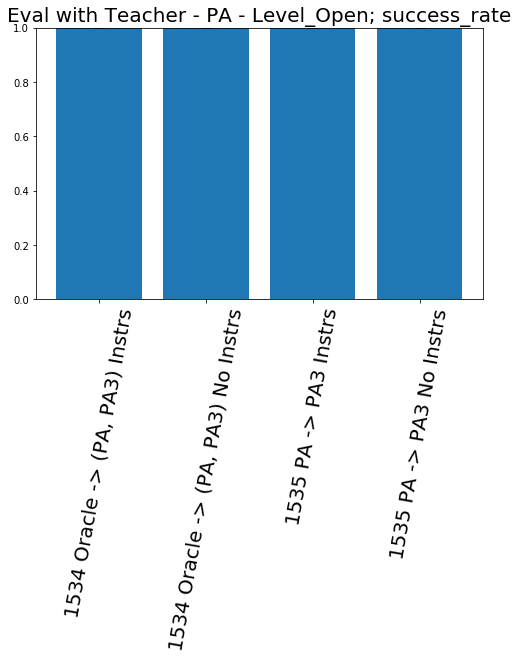

ENV DICT dict_keys(['Level_Unlock', 'Level_Open'])


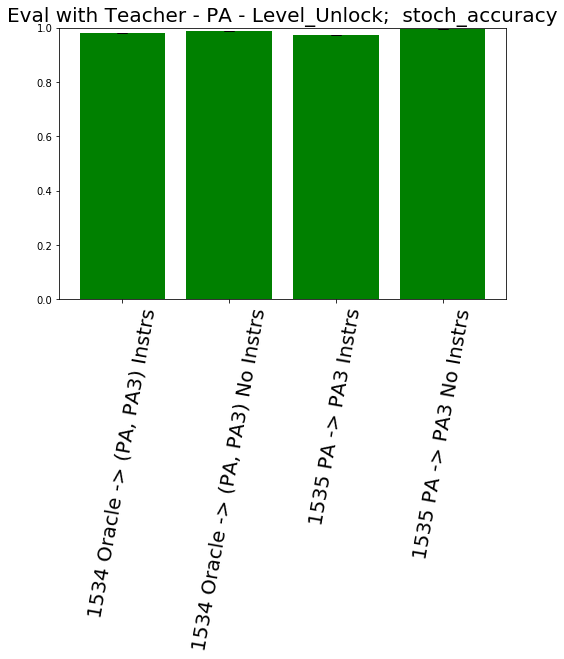

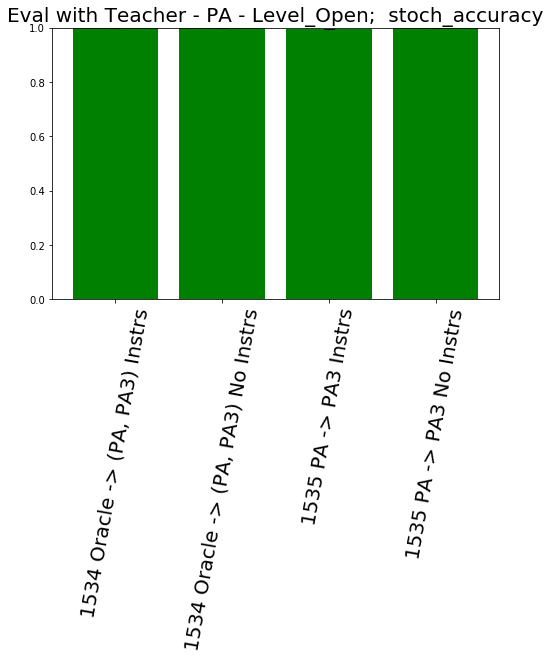

In [126]:
runs = [
#     (['T1498B'], '1419 Oracle -> (PA, PA3)'),
#     (['T1499B'], '1467 PA -> PA3'),
    (['T1536'], '1534 Oracle -> (PA, PA3) Instrs'),
    (['T1538'], '1534 Oracle -> (PA, PA3) No Instrs'),
    (['T1537'], '1535 PA -> PA3 Instrs'),
    (['T1539'], '1535 PA -> PA3 No Instrs'),
]
plot_final_generalization(runs, 'Eval with Teacher - PA')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - PA', ' stoch_accuracy')
# print("/" * 1000)

# runs = [
#     (['T1498_'], '1419 Oracle -> (PA, PA3)'),
#     (['T1499_'], '1467 PA -> PA3'),
# ]
# plot_final_generalization(runs, 'Eval with Teacher - PA')
# print("=" * 100)
# plot_final_generalization(runs, 'Eval with Teacher - PA', ' stoch_accuracy')

### <font color='magenta'> 0-shot PA3 accuracy </font>
### <font color='orange'> TODO: Add dicts </font>
### <font color='orange'> TODO: Try on new model w RL dropout </font>
### <font color='orange'> TODO: Why isn't ID PA acc better? Try training more, training from large dataset. </font>

CONLCUSION: We can ground PA3 well from oracle (.9+ acc OOD, perfect success). From PA, we get .6 OOD and .85 ID, not enough to reliably succeed OOD.

ENV DICT dict_keys(['Level_Unlock', 'Level_Open'])


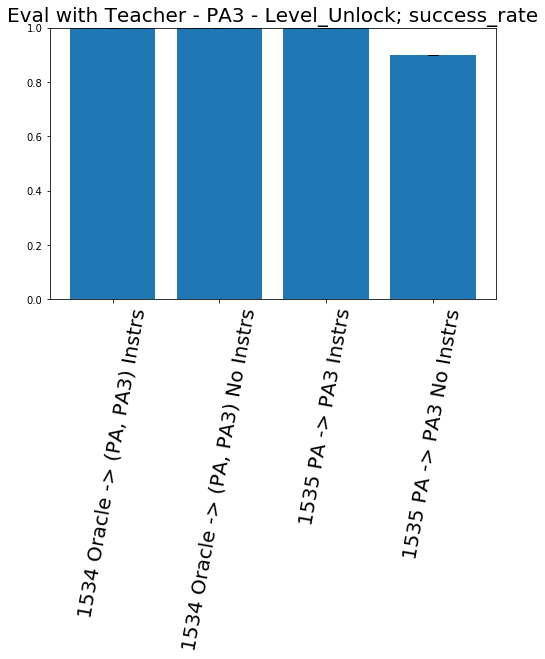

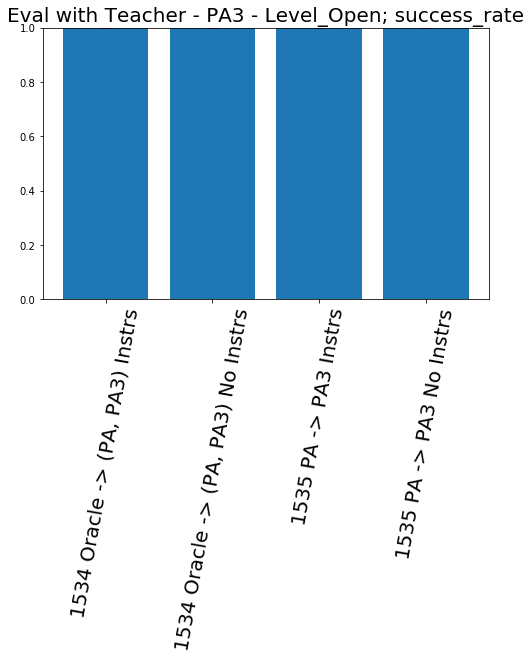

ENV DICT dict_keys(['Level_Unlock', 'Level_Open'])


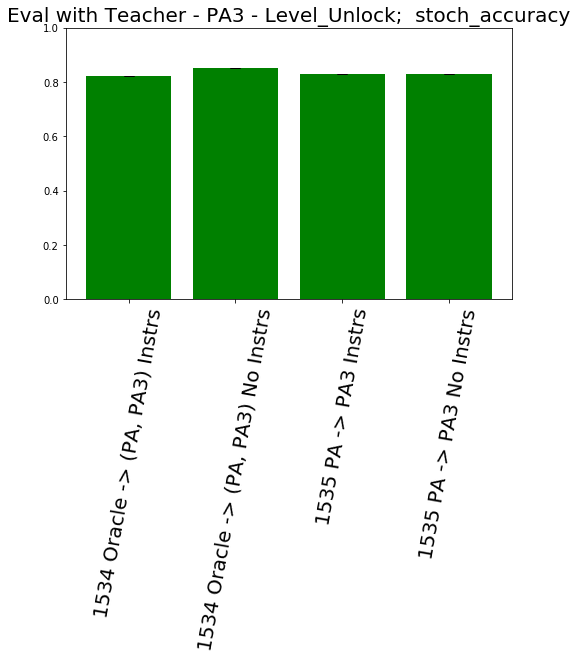

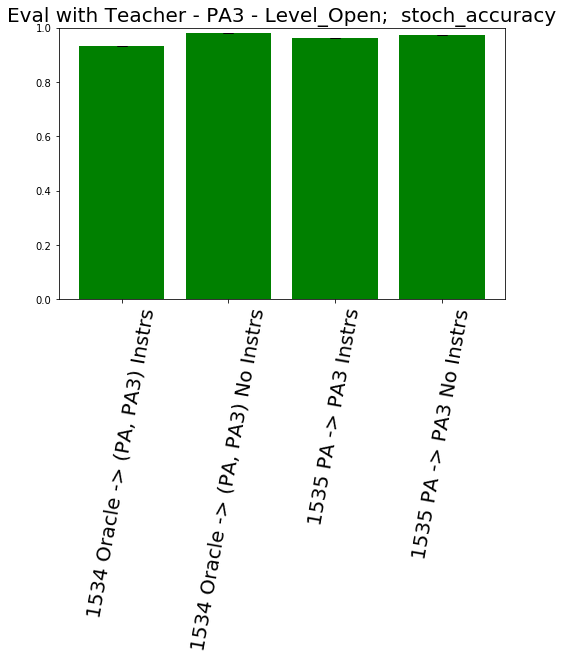

In [125]:
runs = [
#     (['T1501B'], '1467 PA -> PA3 Instrs'),
#     (['T1500B'], '1467 PA -> PA3 No Instrs'),
#     (['T1503B'], '1419 Oracle -> PA3 Instrs'),
#     (['T1502B'], '1419 Oracle -> PA3 No Instrs'),
    (['T1540'], '1534 Oracle -> (PA, PA3) Instrs'),
    (['T1542'], '1534 Oracle -> (PA, PA3) No Instrs'),
    (['T1541'], '1535 PA -> PA3 Instrs'),
    (['T1543'], '1535 PA -> PA3 No Instrs'),
]
plot_final_generalization(runs, 'Eval with Teacher - PA3')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - PA3', ' stoch_accuracy')

# print("/" * 1000)

# runs = [
#     (['T1501_'], '1467 PA -> PA3 Instrs'),
#     (['T1500_'], '1467 PA -> PA3 No Instrs'),
#     (['T1503_'], '1419 Oracle -> PA3 Instrs'),
#     (['T1502_'], '1419 Oracle -> PA3 No Instrs'),
# ]
# plot_final_generalization(runs, 'Eval with Teacher - PA3')
# print("=" * 100)
# plot_final_generalization(runs, 'Eval with Teacher - PA3', ' stoch_accuracy')

### <font color='magenta'> 0-shot None accuracy </font>
### <font color='orange'> TODO: Add dicts </font>
### <font color='orange'> TODO: Add models which have been trained with distill to None </font>

CONLCUSION: Really bad, as expected. Instrs help.

ENV DICT dict_keys(['Level_Unlock', 'Level_Open'])


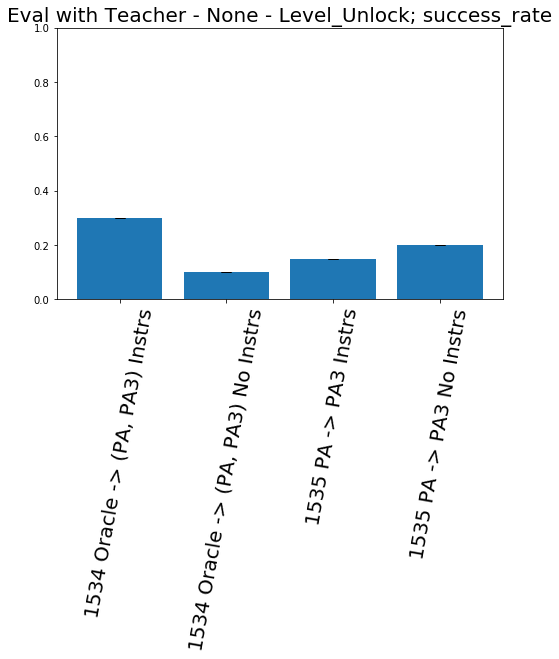

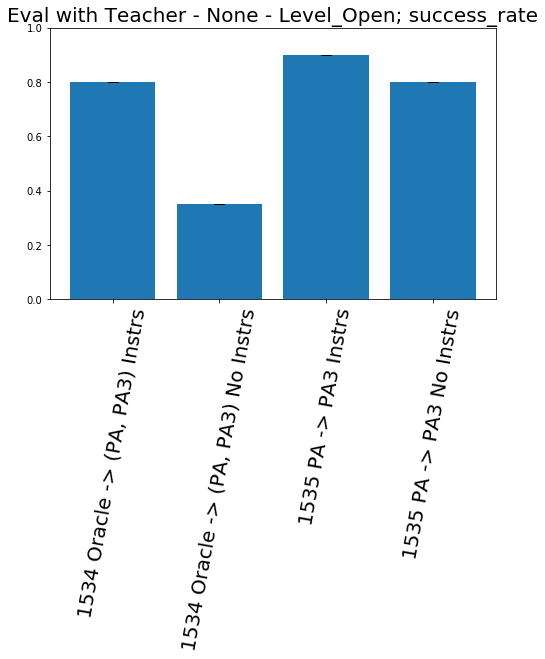

ENV DICT dict_keys(['Level_Unlock', 'Level_Open'])


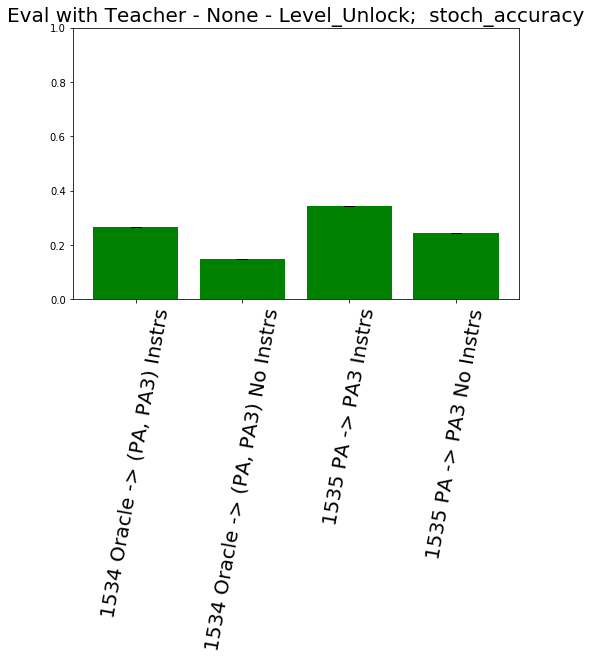

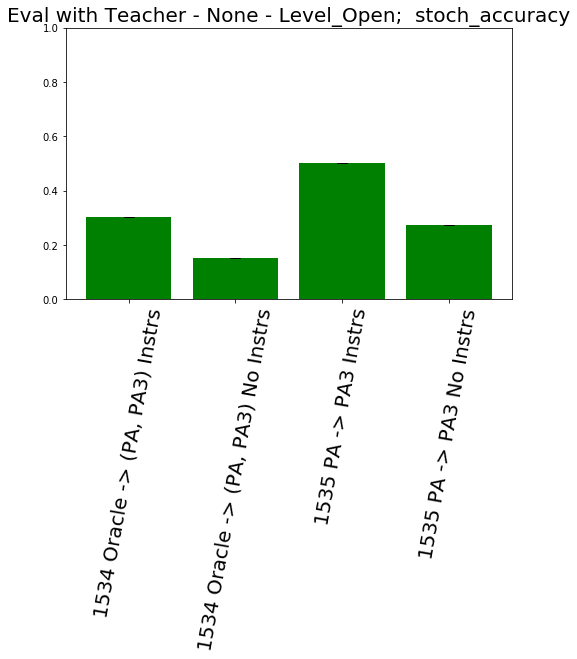

In [129]:
runs = [
#     (['T1510B'], '1467 PA -> PA3 Instrs'),
#     (['T1511B'], '1467 PA -> PA3 No Instrs'),
#     (['T1508B'], '1419 Oracle -> PA3 Instrs'),
#     (['T1509B'], '1419 Oracle -> PA3 No Instrs'),
    (['T1544'], '1534 Oracle -> (PA, PA3) Instrs'),
    (['T1546'], '1534 Oracle -> (PA, PA3) No Instrs'),
    (['T1545'], '1535 PA -> PA3 Instrs'),
    (['T1547'], '1535 PA -> PA3 No Instrs'),
]
plot_final_generalization(runs, 'Eval with Teacher - None')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - None', ' stoch_accuracy')

# print("/" * 1000)

# runs = [
#     (['T1510_'], '1467 PA -> PA3 Instrs'),
#     (['T1511_'], '1467 PA -> PA3 No Instrs'),
#     (['T1508_'], '1419 Oracle -> PA3 Instrs'),
#     (['T1509_'], '1419 Oracle -> PA3 No Instrs'),
# ]
# plot_final_generalization(runs, 'Eval with Teacher - None')
# print("=" * 100)
# plot_final_generalization(runs, 'Eval with Teacher - None', ' stoch_accuracy')

### <font color='orange'> Finetune PA3 accuracy </font>
CONLCUSION: Finetuning doesn't seem to help much in distilling from oracle. In PA -> PA3, it seems to help, but maybe only the first itr?

RL training PA3 seems bad, possibly b/c we've never done it before.

ENV DICT dict_keys(['Level_Unlock'])


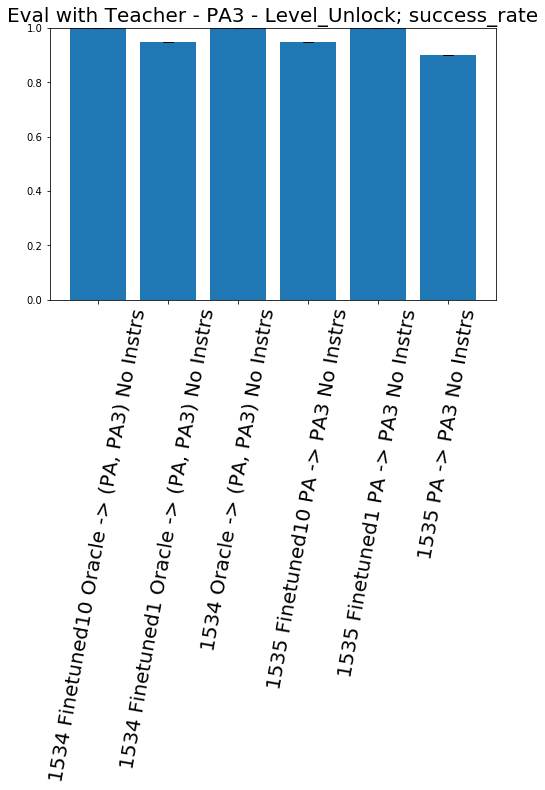

ENV DICT dict_keys(['Level_Unlock'])


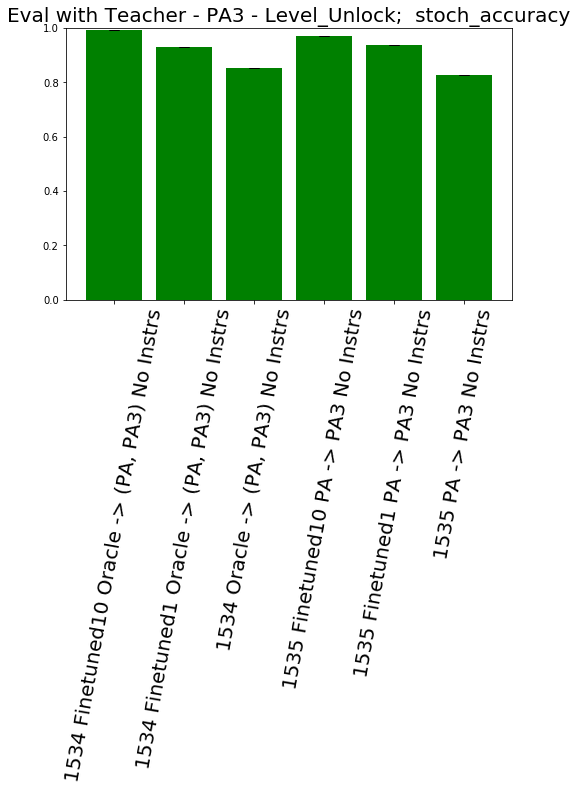

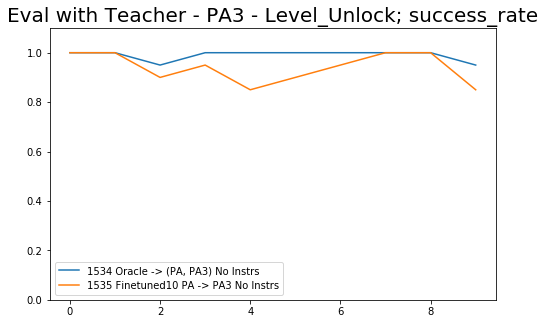

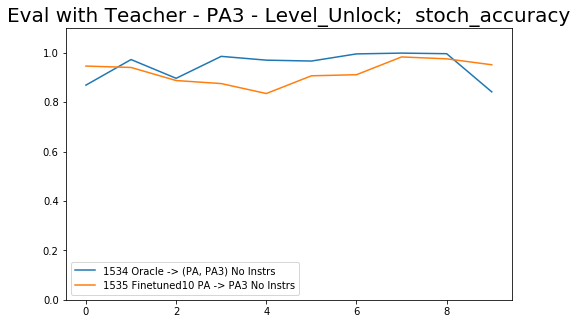

In [138]:
runs = [
    (['T1548'], '1534 Finetuned10 Oracle -> (PA, PA3) No Instrs'),
    (['T1560'], '1534 Finetuned1 Oracle -> (PA, PA3) No Instrs'),
    (['T1542'], '1534 Oracle -> (PA, PA3) No Instrs'),
    (['T1549'], '1535 Finetuned10 PA -> PA3 No Instrs'),
    (['T1561'], '1535 Finetuned1 PA -> PA3 No Instrs'),
    (['T1543'], '1535 PA -> PA3 No Instrs'),
]
plot_final_generalization(runs, 'Eval with Teacher - PA3')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - PA3', ' stoch_accuracy')


runs = [
    (['T1548'], '1534 Oracle -> (PA, PA3) No Instrs'),
    (['T1549'], '1535 Finetuned10 PA -> PA3 No Instrs'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - PA3')
print("=" * 100)
plot_finetune_generalization(runs, 'Eval with Teacher - PA3', ' stoch_accuracy')


### <font color='orange'> 0-shot PA, distill to None </font>
CONCLUSION: Hard to say b/c this model was never trained with None. At the moment, it seems to do better than no finetuning, but doesn't improve past the first few itrs.

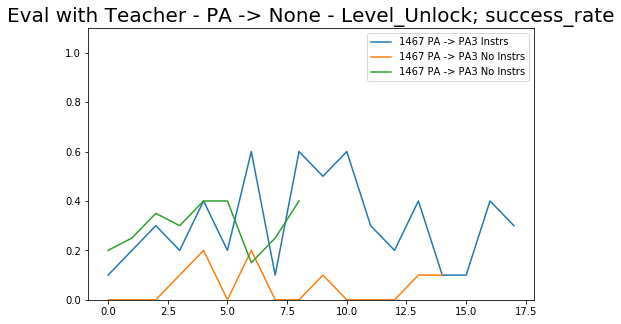

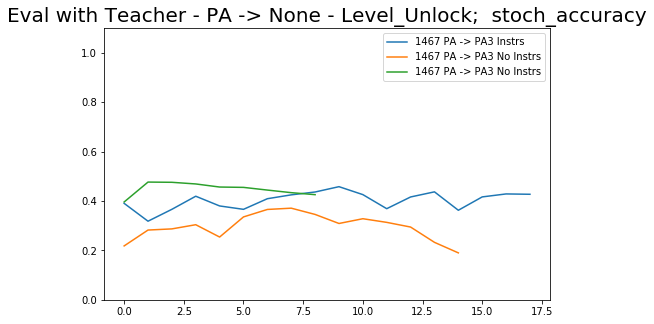

In [140]:
runs = [
    (['T1520'], '1467 PA -> PA3 Instrs'),
    (['T1521'], '1467 PA -> PA3 No Instrs'),
    (['T1559'], '1467 PA -> PA3 No Instrs'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - PA -> None')
print("=" * 100)
plot_finetune_generalization(runs, 'Eval with Teacher - PA -> None', ' stoch_accuracy')

### <font color='orange'> 0-shot PA3, distill to None </font>
CONCLUSION: Hard to say b/c this model was never trained with None. At the moment, it seems to do better than no finetuning, but doesn't improve past the first few itrs.

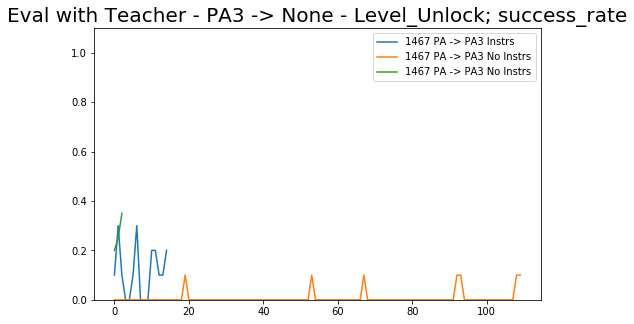

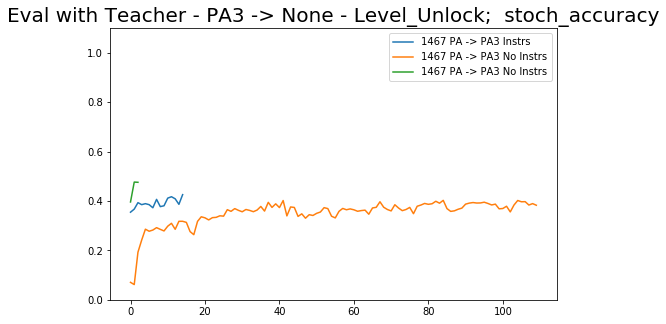

In [137]:
runs = [
    (['T1524'], '1467 PA -> PA3 Instrs'),
    (['T1525'], '1467 PA -> PA3 No Instrs'),
    (['T1559'], '1467 PA -> PA3 No Instrs'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - PA3 -> None')
plot_finetune_generalization(runs, 'Eval with Teacher - PA3 -> None', ' stoch_accuracy')

### <font color='orange'> Finetune PA3, distill to None </font>
CONCLUSION: Hard to say b/c this model was never trained with None. No improvement, it seems?

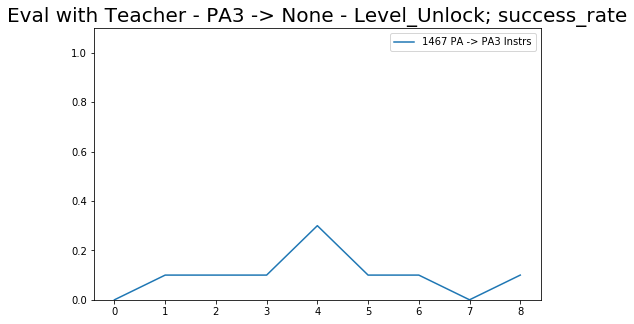

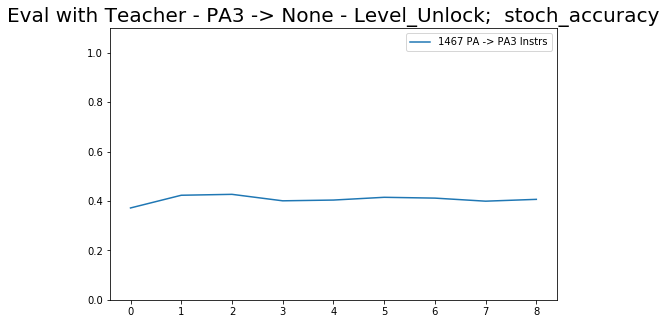

In [101]:
runs = [
    (['T1528'], '1467 PA -> PA3 Instrs'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - PA3 -> None')
plot_finetune_generalization(runs, 'Eval with Teacher - PA3 -> None', ' stoch_accuracy')

### <font color='orange'> Oracle, distill to None </font>
CONCLUSION: Hard to say b/c this model was never trained with None. No improvement, it seems?

Error on  ['T1567'] index 0 is out of bounds for axis 0 with size 0
Error on  ['T1564'] index 0 is out of bounds for axis 0 with size 0
ENV DICT dict_keys(['Level_Unlock'])


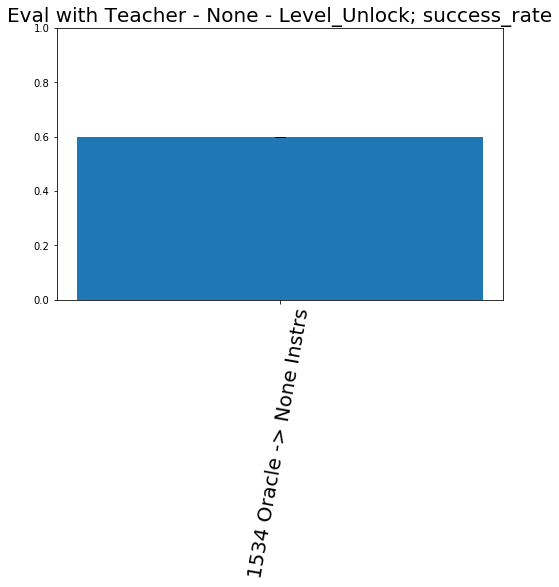

Error on  ['T1567'] index 0 is out of bounds for axis 0 with size 0
Error on  ['T1564'] index 0 is out of bounds for axis 0 with size 0
ENV DICT dict_keys(['Level_Unlock'])


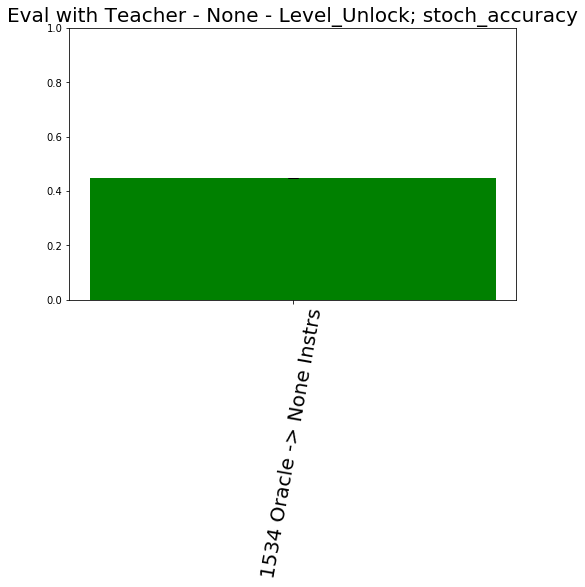

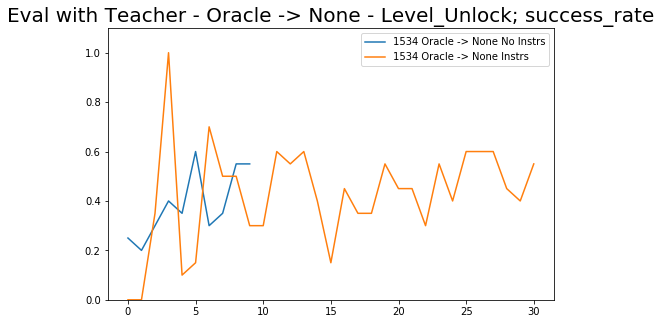

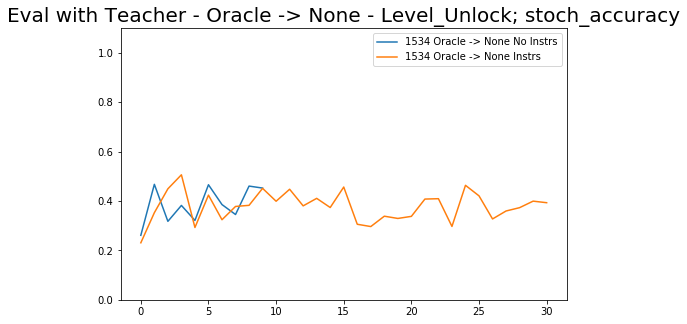

In [154]:
runs = [
    (['T1550'], '1534 Oracle -> None Instrs'),
    (['T1567'], '1567 Oracle -> None Instrs Easy'),
    (['T1564'], '1534 Oracle -> None Instrs'),
]
plot_final_generalization(runs, 'Eval with Teacher - None')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - None', 'stoch_accuracy')



runs = [
#     (['T1530'], '1419 Oracle -> None Instrs'),
#     (['T1531'], '1419 Oracle -> None No Instrs'),
    (['T1550'], '1534 Oracle -> None No Instrs'),
    (['T1564'], '1534 Oracle -> None Instrs'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - Oracle -> None')
plot_finetune_generalization(runs, 'Eval with Teacher - Oracle -> None', 'stoch_accuracy')

### <font color='red'> 0-shot CC3 accuracy </font>

ISSUE: accuracies are all .4ish, way worse than we saw in the TB rollouts.

CONCLUSION: [INSERT]

In [31]:
runs = [
    (['T1496'], '1471 CC1, Instrs'),
    (['T1497'], '1471 CC1, No Instrs'),
]
plot_curriculum_generalization(runs, 'Eval with Teacher')
plot_curriculum_generalization(runs, 'Eval with Teacher', ' stoch_accuracy')

Error on  ['T1496'] No files found with name T1496
Error on  ['T1497'] No files found with name T1497
Error on  ['T1496'] No files found with name T1496
Error on  ['T1497'] No files found with name T1497


## Distill to None, sample efficiency, best so far.
CONCLUSION: [INSERT]

## <font color='purple'> [HELPER] Does removing instructions help generalization?</font>

Conclusion: No significant difference. Even with Subgoals, where it sometimes helped, I think it's just b/c that run went longer! We could continue the existing runs to check that though.

In [32]:

runs = [
    (['EVAL_539', 'EVAL_540'], 'PA'),
    (['EVAL_579', 'EVAL_580'], 'PA_I'),
    (['EVAL_543', 'EVAL_544'], 'CC2'),
    (['EVAL_581', 'EVAL_582'], 'CC2_I'),
    (['EVAL_545', 'EVAL_546'], 'CC3'),
    (['EVAL_597', 'EVAL_598'], 'CC3_I'),
    (['EVAL_547', 'EVAL_548'], 'SUB'),
    (['EVAL_599', 'EVAL_600'], 'SUB_I'),
]

plot_final_generalization(runs, 'Train + Eval with NO INSTRS')

Error on  ['EVAL_539', 'EVAL_540'] No files found with name EVAL_539
Error on  ['EVAL_579', 'EVAL_580'] No files found with name EVAL_579
Error on  ['EVAL_543', 'EVAL_544'] No files found with name EVAL_543
Error on  ['EVAL_581', 'EVAL_582'] No files found with name EVAL_581
Error on  ['EVAL_545', 'EVAL_546'] No files found with name EVAL_545
Error on  ['EVAL_597', 'EVAL_598'] No files found with name EVAL_597
Error on  ['EVAL_547', 'EVAL_548'] No files found with name EVAL_547
Error on  ['EVAL_599', 'EVAL_600'] No files found with name EVAL_599
ENV DICT dict_keys([])


# <font color='green'> Claim 3: Training with teacher + distilling few-shot generalizes to new levels faster. </font> <font color='red'> [TODO: code this up] </font>

## <font color='green'> [Status: Work in Progress. No results yet.] </font>

# <font color='blue'> Claim 4: Lower-level communication is more efficient to ground.</font>

## <font color='blue'> [Status: Definitely true, but no plots to show it yet.] </font>

## <font color='blue'>[STATUS] </font>

The goal is to motivate why we want to bootstrap rather than using the higher-level teachers directly.

This is true from what we've seen so far. We could probably show this in a graph by training an agent (either on the start of the curriculum or on a certain level), and checking periodically whether it can solve the held-out levels. The easy teachers should be able to do this more quickly than the harder teachers.

# <font color='purple'> Claim 5: Higher level communication is most feedback-efficient on new levels once grounded. </font>

## <font color='purple'> [Status: Hints this is true at the end of curriculm learning. We haven't yet seen it in held-out levels.] </font>


The goal is to motivate why we want higher-level teachers at all.

In theory, the generalization exps (claim 3) should show this.

# <font color='green'> Claim 6: We can ground higher-level feedback using lower-level feedback and minimal use of the reward. This is more efficient than grounding the higher-level communication directly. </font>

## <font color='green'> [Status: Self-distill > Bootstrap > Train directly] </font> <font color='red'> </font>


Goal is to show that bootstrapping is a reasonable thing to do.

May also help with grounding harder teachers better.

TODO

## <font color='green'> Comparing the Feedback Efficiency of Bootstrapping vs not (NO distillation) </font>
### (a) Train on higher-level teacher directly
### (b) Train with easy teacher, distill to higher-level teacher
### (c) Start training on easy teacher, then distill from easy to higher-level teacher, than train with higher-level teacher

In all cases, the agent advances to the next curriculum level when it can perform well on the highest-level teacher currently provided.

No files found with name 0540
couldn't plot Train PA Directly
No files found with name 0543
couldn't plot Train CC2 Directly
No files found with name 0557
couldn't plot Train PA, Distill CC2
Length 1201
Length 1081


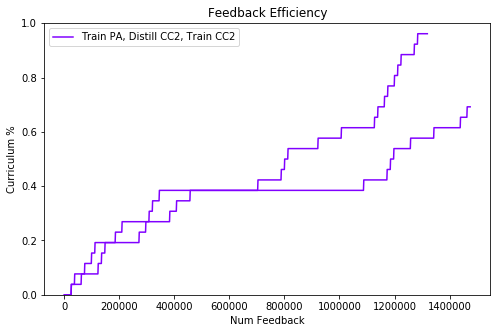

No files found with name 0540
couldn't plot Train PA Directly
No files found with name 0545
couldn't plot Train CC3 Directly
Length 2925
Length 7735
No files found with name 0559
couldn't plot Train PA, Distill CC3
Length 2070
Length 2521


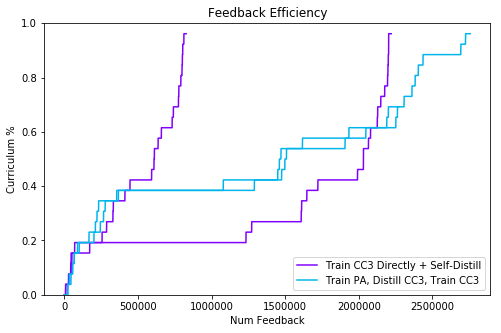

No files found with name 0540
couldn't plot Train PA Directly
No files found with name 0547
couldn't plot Train SUB Directly
Length 16715
Length 45774
No files found with name 0561
couldn't plot Train PA, Distill SUB
Length 9601


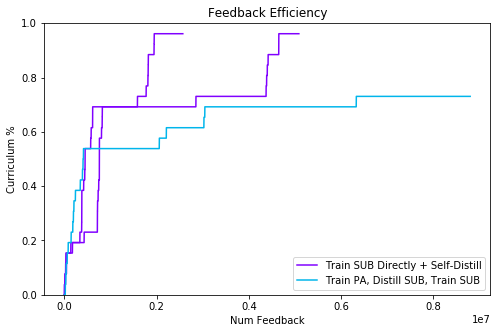

In [33]:
data_names = [
    (['0540'], 'Train PA Directly'),
#     (['0539', '0540'], 'Train PA Directly'),
    (['0543', '0544'], 'Train CC2 Directly'),
    (['0557', '0558'], 'Train PA, Distill CC2'),
    (['637', '638'], 'Train PA, Distill CC2, Train CC2'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0540'], 'Train PA Directly'),
    (['0545', '0546'], 'Train CC3 Directly'),
    (['682', '683'], 'Train CC3 Directly + Self-Distill'),
    (['0559', '0560'], 'Train PA, Distill CC3'),
    (['639', '640'], 'Train PA, Distill CC3, Train CC3'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0540'], 'Train PA Directly'),
    (['0547', '0548'], 'Train SUB Directly'),
    (['684', '685'], 'Train SUB Directly + Self-Distill'),
    (['0561', '0562'], 'Train PA, Distill SUB'),
    (['641'], 'Train PA, Distill SUB, Train SUB'),
]
plot_curriculum(data_names, 'feedback')


## <font color='green'> Comparing the Feedback Efficiency of Bootstrapping vs not (YES distillation) </font>

No files found with name 0631
couldn't plot CC2
No files found with name T0729_PRE_to_CC2
couldn't plot PA->CC2


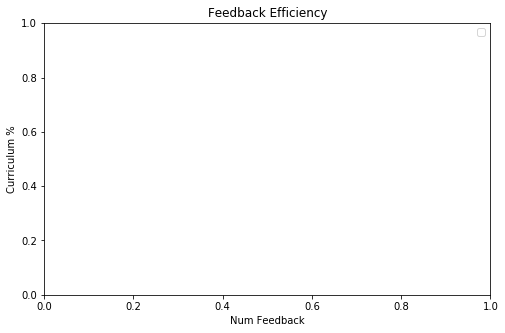

No files found with name 0633
couldn't plot CC3
No files found with name 0666
couldn't plot PA->CC3


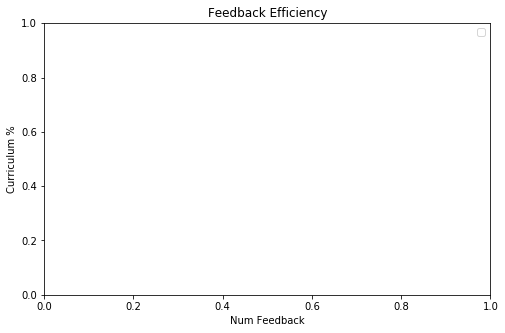

No files found with name 0635
couldn't plot SUB
No files found with name 0668
couldn't plot PA->SUB


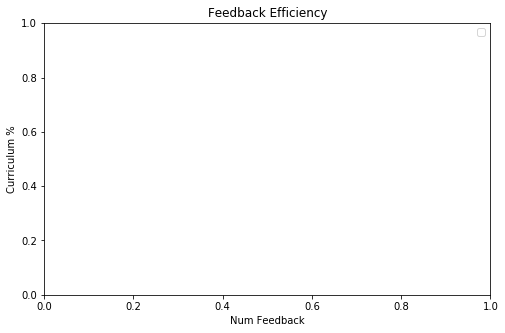

In [34]:
data_names = [
    (['0631', '0632'], 'CC2'),
    (['T0729_PRE_to_CC2', '728'], 'PA->CC2'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0633', '0634'], 'CC3'),
    (['0666', '0667'], 'PA->CC3'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0635', '0636'], 'SUB'),
    (['0668', '0669'], 'PA->SUB'),
]
plot_curriculum(data_names, 'feedback')

# <font color='blue'> Claim 8: we can (largely) remove the reward during training once the first teacher is grounded.  </font> 

## <font color='blue'> [Status: Early results show it helps for PA, not SUB].  </font> 

Let's test this by taking PA (the easiest teacher to learn) and seeing at what point during training it can zero-shot solve the entire curriculum.

## <font color='blue'> [Helper] See how early through the curriculum we can remove the reward. </font>

Currently suggests there's no one point where the reward can be removed; we need to keep checking it it and training if needed.

In [35]:
runs = [
    (['EVAL_ALL_LEVELS_627'], 'PA'),
]
plot_curriculum_generalization(runs, 'Eval with Teacher')

Error on  ['EVAL_ALL_LEVELS_627'] No files found with name EVAL_ALL_LEVELS_627


In [36]:
runs = [
    (['EVAL_PA_EARLY_FINAL_455'], 'PA'),
    (['EVAL_PA_EARLY_455_mid'], 'PA'),
]
plot_curriculum_generalization(runs, 'Eval with Teacher')

Error on  ['EVAL_PA_EARLY_FINAL_455'] No files found with name EVAL_PA_EARLY_FINAL_455
Error on  ['EVAL_PA_EARLY_455_mid'] No files found with name EVAL_PA_EARLY_455_mid


## <font color='blue'> [Helper] See if we can zero-shot some levels. </font>

No files found with name 0540
couldn't plot PA
Length 99


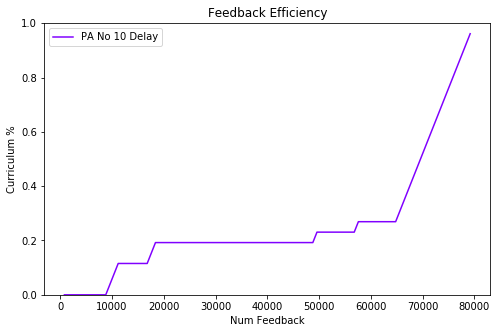

In [37]:
data_names = [
    (['0540'], 'PA'),
    (['676'], 'PA No 10 Delay'),
#     (['677', '678'], "PA Don't train each level"),  # TODO: This one doesn't actually skip training on some levels
]
plot_curriculum(data_names, 'feedback')

## <font color='blue'> [Main] Remove reward during training when possible </font>

Tries reward periodically. If the agent succeeds, we skip training for the next few itrs.

NOTE: Would probably make more sense to separate sparse vs per-timestep rewards. Only provide per-timestep rewards if the agent is failing at getting the sparse rewards.

No files found with name 0729_PA
couldn't plot PA Distill, Sometimes Reward
No files found with name 0627
couldn't plot PA Distill, Always reward


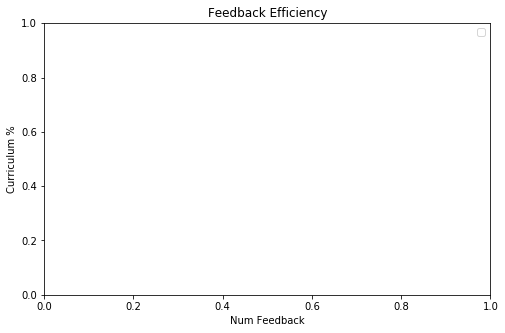

No files found with name 0729_PA
couldn't plot PA Distill, Sometimes Reward
No files found with name 0627
couldn't plot PA Distill, Always reward


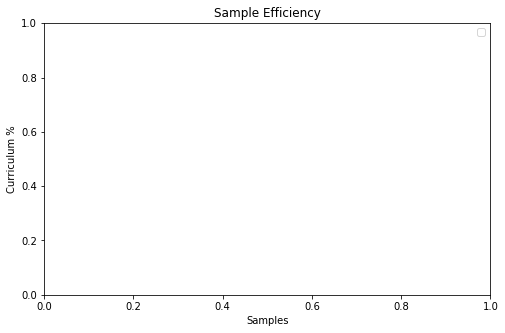

In [38]:
data_names = [
    (['0729_PA', '0730'], 'PA Distill, Sometimes Reward'),
    (['0627', '0628'], 'PA Distill, Always reward'),
]
plot_curriculum(data_names, 'feedback')
plot_curriculum(data_names, 'samples')

No files found with name 735
couldn't plot PA -> Sub Distill, Sometimes Reward
No files found with name 668
couldn't plot PA -> Sub Distill, Always reward


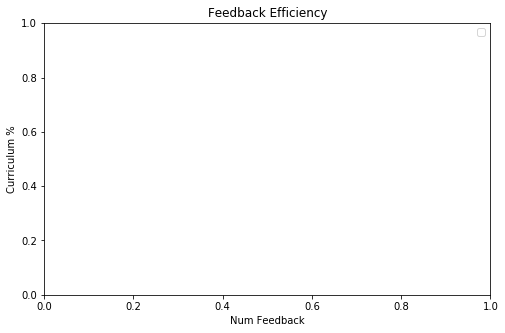

No files found with name 735
couldn't plot PA -> Sub Distill, Sometimes Reward
No files found with name 668
couldn't plot PA -> Sub Distill, Always reward


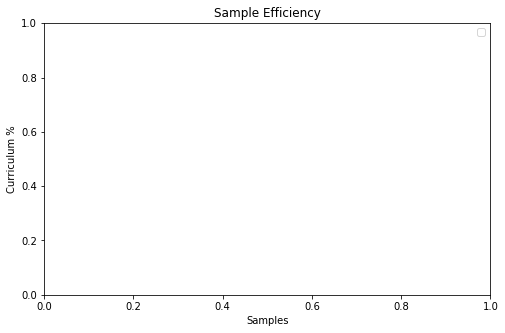

In [39]:
data_names = [
    (['735', '736'], 'PA -> Sub Distill, Sometimes Reward'),
    (['668', '669'], 'PA -> Sub Distill, Always reward'),
]
plot_curriculum(data_names, 'feedback')
plot_curriculum(data_names, 'samples')

# <font color='purple'> Leaderboard - Curriculum Learning  </font>

Keep track of the current best methods of learning a curriculum (ranked by feedback-efficiency).

No files found with name 0437
couldn't plot Distill from PA, Default


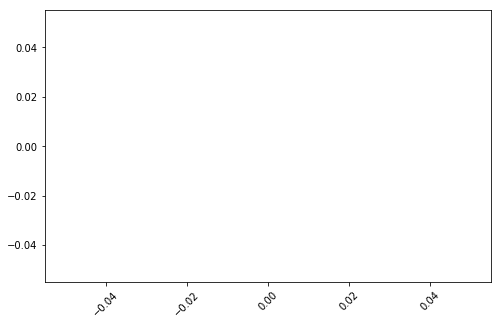

In [40]:
methods = [
    (['0437'], "Distill from PA, Default", "Standard HParams, train PA, distill to powerset"), # TODO: placeholder; hasn't actually succeeded yet
]

plot_leaderboard(methods)


# <font color='green'> Leaderboard - Curriculum Learning (no distillation)  </font>

Keep track of the current best methods of learning a curriculum (ranked by feedback-efficiency).

No files found with name 0539
couldn't plot Train PA, Default
Error tokenizing data. C error: Expected 65 fields in line 3, saw 77

[Errno 2] No such file or directory: 'meta-mb-internal/old_data/T0577_CURRICULUM1_PA_NODISTILL_SPARSE_teacherPreActionAdvice_threshS0.99_threshA0.6_lr0.0001_ent0.001_currfnone_hot_1/new_progress.csv'
couldn't plot Train PA, Sparse


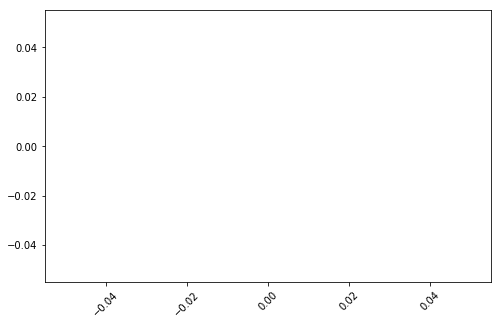

In [41]:
methods = [
    (['0539', '0540'], "Train PA, Default", "Standard HParams, train PA"),
    (['0577', '0578'], "Train PA, Sparse", "Standard HParams, train PA"),
]

plot_leaderboard(methods)


# <font color='blue'> Leaderboard - Few-Shot Generalization </font>


Keep track of the current best methods of few-shot learning heldout levels (ranked by feedback-efficiency).

TODO

# <font color='purple'> Miscellaneous Other Plots </font> <font color='red'> [TODO: plot sweeps] </font>

## <font color='purple'> Does bigger batch size help? </font>

Conclusion: It helps when subgoals not distilling, but doesn't help when distilling. We should check whether this holds for other teachers.

No files found with name 0547
couldn't plot SUB Nodistill, Small batch
No files found with name 0722
couldn't plot SUB Nodistill, Big batch


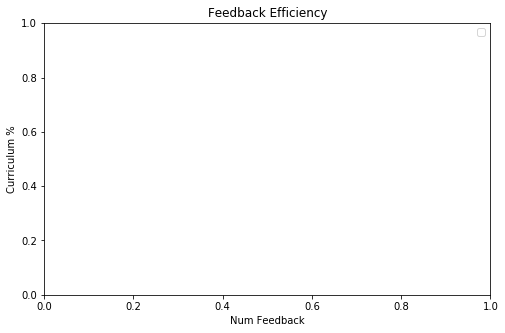

No files found with name 636
couldn't plot SUB Distill, Small batch
No files found with name 690
couldn't plot SUB Distill, Big batch


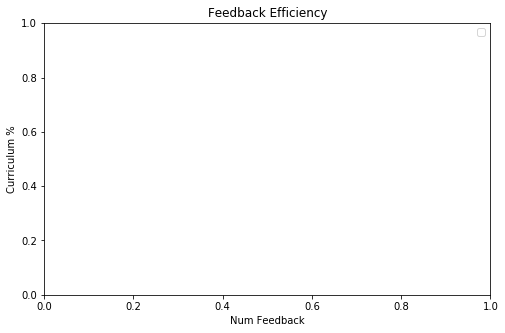

No files found with name 668
couldn't plot PA->SUB Distill, Small batch
No files found with name 726
couldn't plot PA->SUB Distill, Big batch


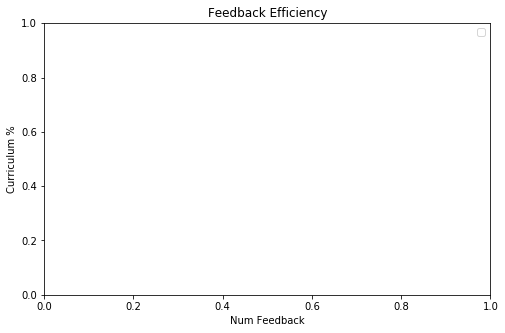

In [42]:
data_names = [
    (['0547', '0548'], 'SUB Nodistill, Small batch'),
    (['0722', '0723', '688'], 'SUB Nodistill, Big batch'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['718', '719', '636', '0635'], 'SUB Distill, Small batch'),
    (['690'], 'SUB Distill, Big batch'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB Distill, Small batch'),
    (['726', '725', '724'], 'PA->SUB Distill, Big batch'),
]
plot_curriculum(data_names, 'feedback')



### No distillation

No files found with name 0540
couldn't plot PA
Length 139
Length 97


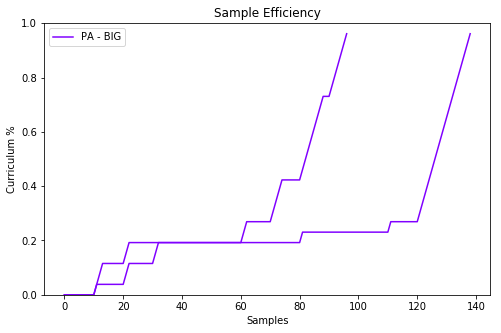

No files found with name 0543
couldn't plot CC2
Length 3472
Length 6984


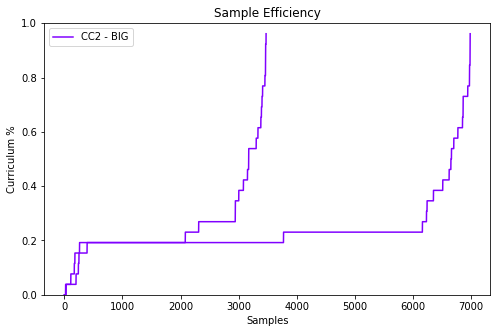

No files found with name 0545
couldn't plot CC3
No files found with name 696
couldn't plot CC3 - BIG


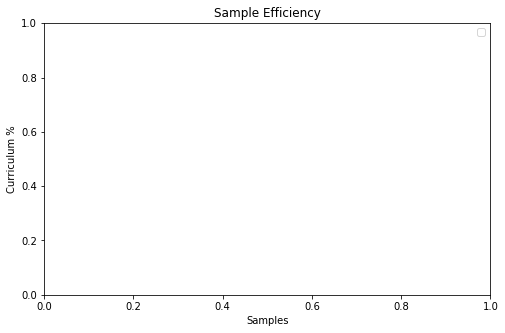

No files found with name 0547
couldn't plot SUB
No files found with name 688
couldn't plot SUB - BIG


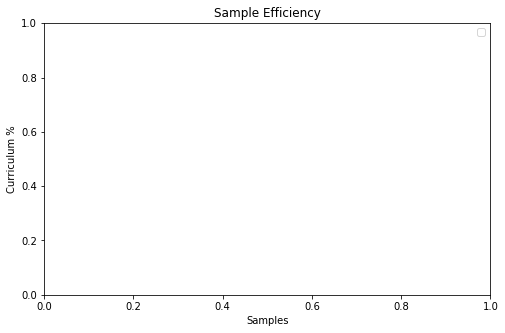

In [43]:
# NO DISTILLATION

data_names = [
    (['0540'], 'PA'),
    (['692', '693'], 'PA - BIG'),
]
plot_curriculum(data_names, 'samples')  # WORSE

data_names = [
    (['0543', '0544'], 'CC2'),
    (['694', '695'], 'CC2 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0545', '0546'], 'CC3'),
    (['696', '697'], 'CC3 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0547', '0548'], 'SUB'),
    (['688'], 'SUB - BIG'),
]
plot_curriculum(data_names, 'samples')


### Distillation

No files found with name 0627
couldn't plot PA
Length 11321
Length 15371


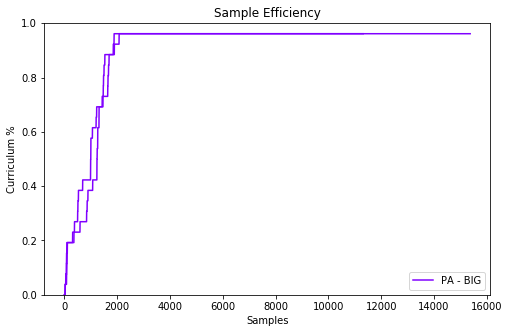

No files found with name 0631
couldn't plot CC2
Length 17330
Length 16310


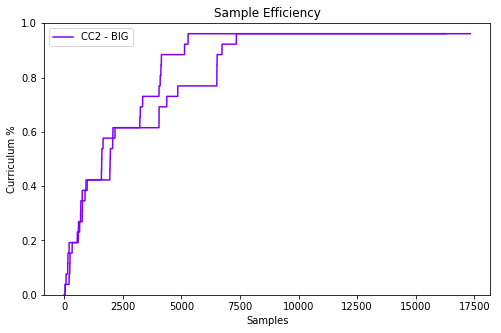

No files found with name 0633
couldn't plot CC3
No files found with name 702
couldn't plot CC3 - BIG


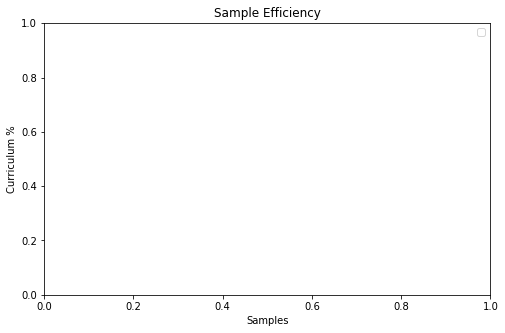

No files found with name 0635
couldn't plot SUB
No files found with name 690
couldn't plot SUB - BIG


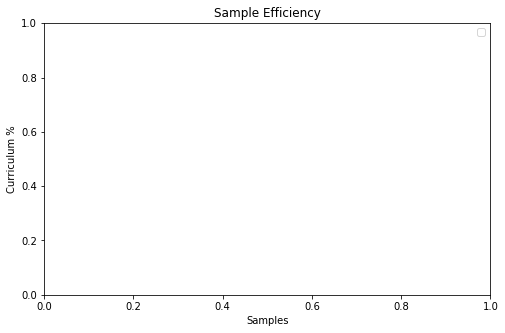

In [44]:
data_names = [  # TODO: re-run these 
    (['0627', '0628'], 'PA'),
    (['698', '699'], 'PA - BIG')
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0631', '0632'], 'CC2'),
    (['700', '701'], 'CC2 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0633', '0634'], 'CC3'),
    (['702', '703'], 'CC3 - BIG')
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0635', '0636'], 'SUB'),
    (['690'], 'SUB - BIG')
]
plot_curriculum(data_names, 'samples')

## <font color='purple'> Does a bigger model help? </font>

Helps a little bit...

No files found with name 636
couldn't plot SUB Distill, Small model
No files found with name 664
couldn't plot SUB Distill, Big model


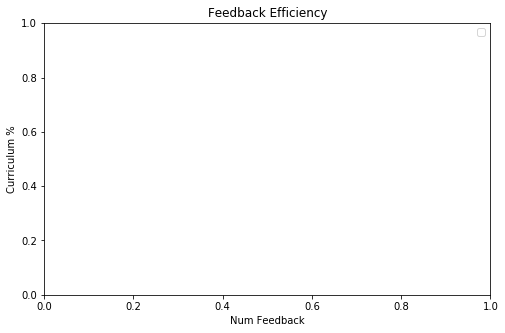

No files found with name 668
couldn't plot PA->SUB Distill, Small model
Length 8756
Length 12646


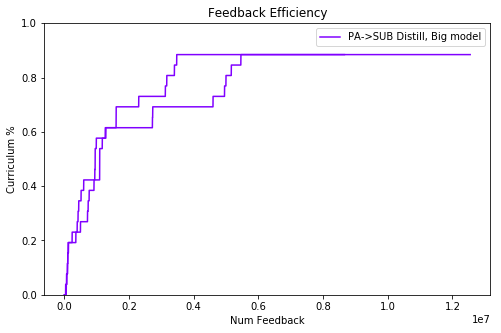

In [45]:
# data_names = [
#     (['0547', '0548'], 'SUB Nodistill, Small model'),
#     (['0722', '0723', '688'], 'SUB Nodistill, Big model'),
# ]
# plot_curriculum(data_names, 'feedback')

data_names = [
    (['718', '719', '636', '0635'], 'SUB Distill, Small model'),
    (['714', '715', '664'], 'SUB Distill, Big model'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB Distill, Small model'),
    (['716', '717'], 'PA->SUB Distill, Big model'),
]
plot_curriculum(data_names, 'feedback')


## <font color='purple'> Does self-distillation help? </font>

Length 139
Length 97
No files found with name 0706
couldn't plot PA Self-Distill


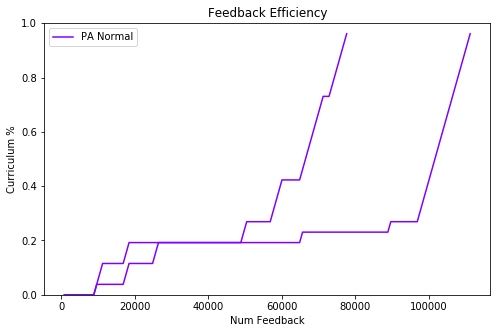

No files found with name 0543
couldn't plot CC2 Normal
No files found with name 0704
couldn't plot CC2 Self-Distill


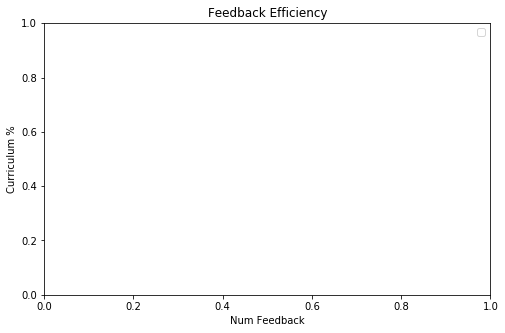

No files found with name 0545
couldn't plot CC3 Normal
Length 2925
Length 7735


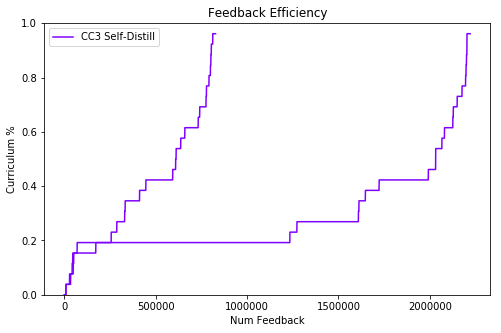

No files found with name 0722
couldn't plot SUB Normal
Length 16715
Length 45774


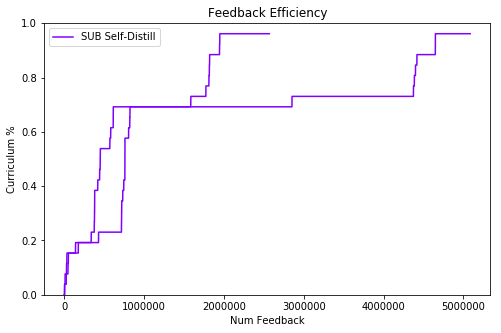

In [46]:
data_names = [
    (['692', '693'], 'PA Normal'),
    (['0706', '0707'], 'PA Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0543', '0544'], 'CC2 Normal'),
    (['0704', '0705'], 'CC2 Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0545', '0546'], 'CC3 Normal'),
    (['682', '683'], 'CC3 Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0722', '0723', '688'], 'SUB Normal'),
    (['684', '685'], 'SUB Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

## <font color='purple'> Does buffer size help?  </font>

## <font color='purple'> Does raising the RL accuracy threshold size help?  </font>

No files found with name 0627
couldn't plot PA Distill, Normal Acc
No files found with name 0737
couldn't plot PA Distill, High Acc


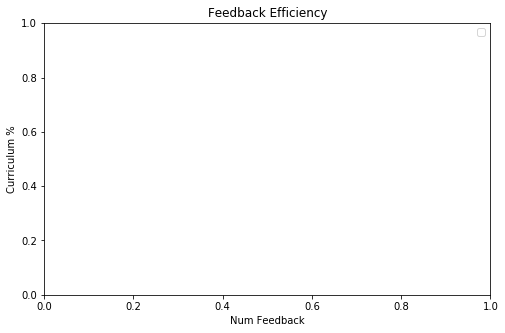

No files found with name 0666
couldn't plot PA->CC3 Distill, Normal Acc
No files found with name 0739
couldn't plot PA->CC3 Distill, High Acc


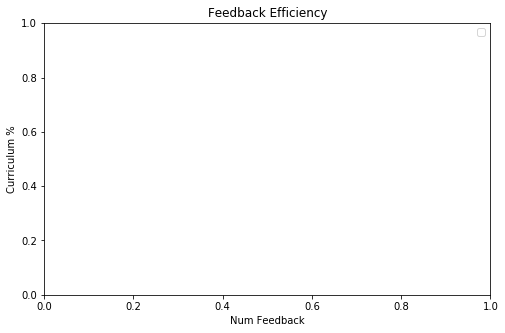

No files found with name 668
couldn't plot PA->SUB, Normal Acc
No files found with name 0741
couldn't plot PA->SUB, High Acc


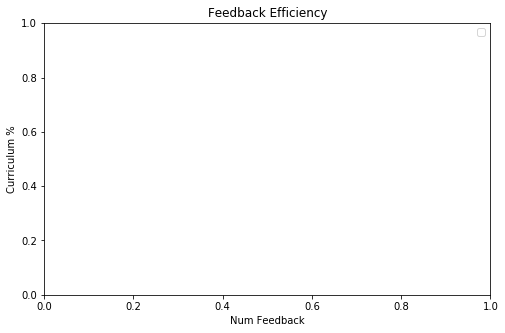

In [47]:
data_names = [
    (['0627', '0628'], 'PA Distill, Normal Acc'),
    (['0737', '0738'], 'PA Distill, High Acc'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0666', '0667'], 'PA->CC3 Distill, Normal Acc'),
    (['0739', '0740'], 'PA->CC3 Distill, High Acc'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB, Normal Acc'),
    (['0741', '0742'], 'PA->SUB, High Acc'),
]
plot_curriculum(data_names, 'feedback')


## <font color='purple'> Does lowering the discount help?  </font>

No files found with name 668
couldn't plot PA->SUB, Normal Discount
Length 3284
Length 2578


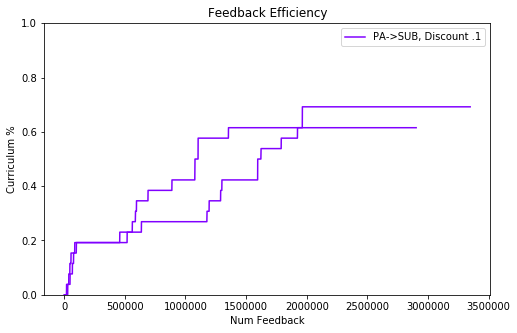

In [48]:
data_names = [
    (['720', '721', '668', '669'], 'PA->SUB, Normal Discount'),
    (['743', '744'], 'PA->SUB, Discount .1'),
]
plot_curriculum(data_names, 'feedback')

## <font color='purple'> Does the way we collect labels matter?  </font>

No files found with name 0821
couldn't plot PA->CC3 Default
Length 1520
Length 1959
No files found with name 835
couldn't plot PA->CC3 Agent dist
Length 1833
Length 2282


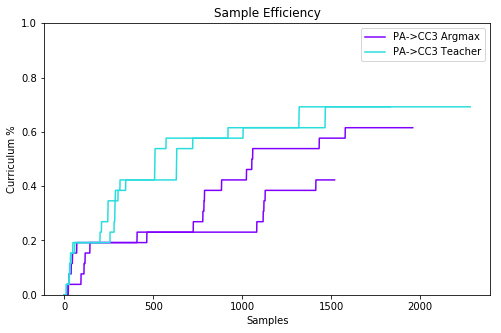

In [49]:
data_names = [
    (['0821', '0822'], 'PA->CC3 Default'),
#     (['0825', '0826'], 'PA->CC3 Big Batch'),
    (['833', '834'], 'PA->CC3 Argmax'),
    (['835', '836'], 'PA->CC3 Agent dist'),
    (['837', '838'], 'PA->CC3 Teacher'),
]
plot_curriculum(data_names, 'samples')

## <font color='purple'> Does DAgger help?  </font>

No files found with name 0943
couldn't plot PA->CC3 Normal
No files found with name 0993
couldn't plot PA->CC3 DAgger


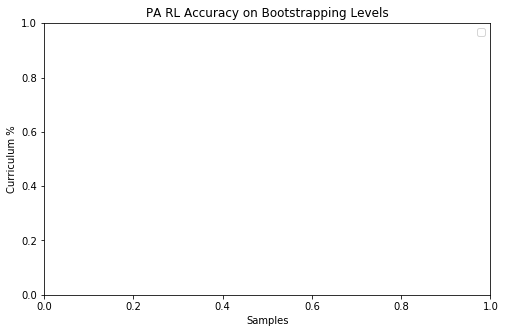

No files found with name 0943
couldn't plot PA->CC3 Normal
No files found with name 0993
couldn't plot PA->CC3 DAgger


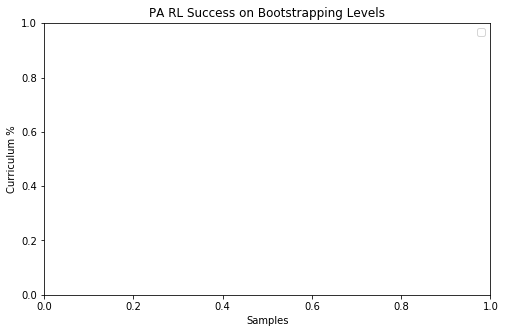

No files found with name 0943
couldn't plot PA->CC3 Normal
No files found with name 0993
couldn't plot PA->CC3 DAgger


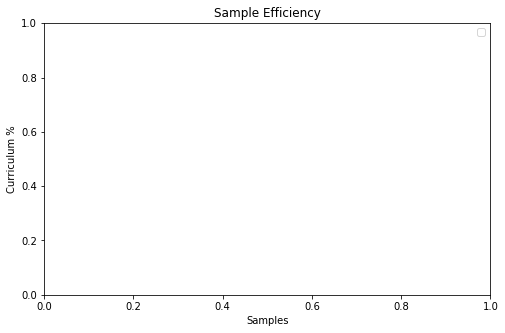

No files found with name 0943
couldn't plot PA->CC3 Normal
No files found with name 0993
couldn't plot PA->CC3 DAgger


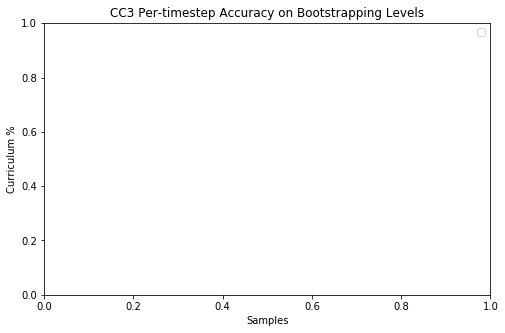

No files found with name 0943
couldn't plot PA->CC3 Normal
No files found with name 0993
couldn't plot PA->CC3 DAgger


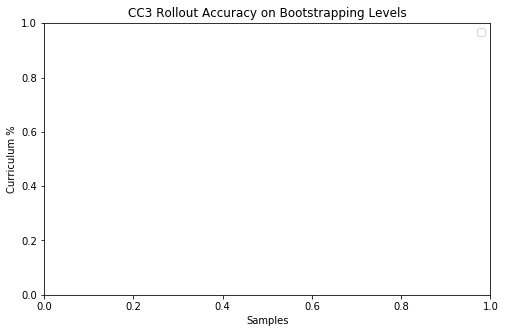

No files found with name 0943
couldn't plot PA->CC3 Normal
No files found with name 0993
couldn't plot PA->CC3 DAgger


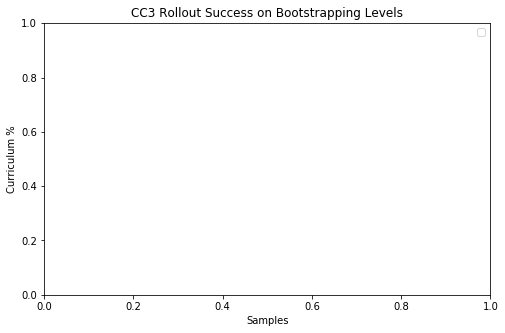

No files found with name 0943
couldn't plot PA->CC3 Normal
No files found with name 0993
couldn't plot PA->CC3 DAgger


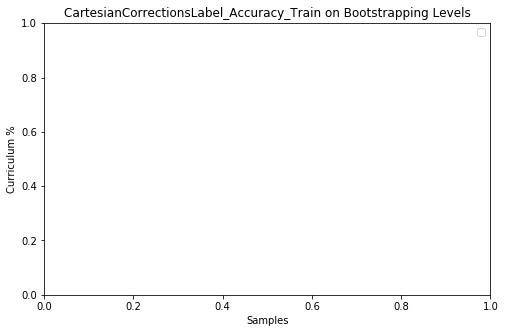

No files found with name 0943
couldn't plot PA->CC3 Normal
No files found with name 0993
couldn't plot PA->CC3 DAgger


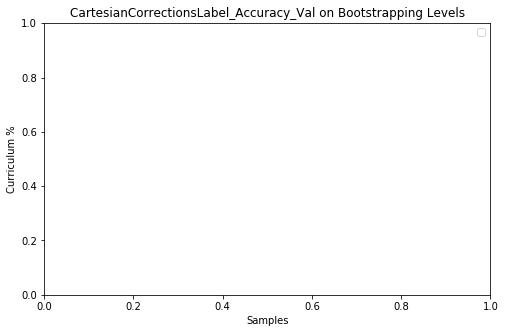

In [50]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0943', '0944'], 'PA->CC3 Normal'),
    (['0993', '0994'], 'PA->CC3 DAgger'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Success', smooth=100, 
                level_start=0, level_end=12, title="PA RL Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Val on Bootstrapping Levels")

## <font color='purple'> Does using a separate model help?  </font>

No files found with name 0825
couldn't plot PA->CC3 NEW3
Length 3510
Length 3866


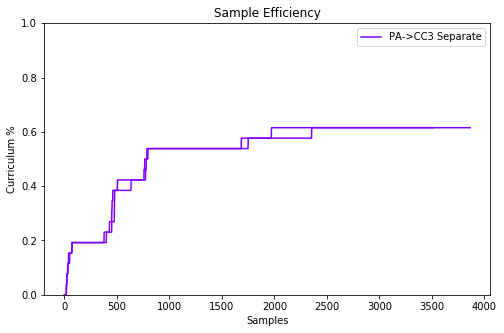

In [51]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['839', '840'], 'PA->CC3 Separate'),
]
plot_curriculum(data_names, 'samples')


## <font color='purple'> Does re-weighting help?  </font>

No files found with name 0825
couldn't plot PA->CC3 NEW3
No files found with name 817
couldn't plot PA->CC3 Re-Weight
No files found with name 813
couldn't plot PA->CC3 Re-Weight Pretrained


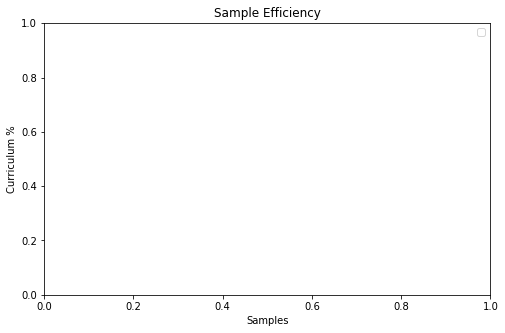

Length 5341
Length 6183
No files found with name 819
couldn't plot PA->SUB Re-Weight
No files found with name 815
couldn't plot PA->SUB Re-Weight Pretrained


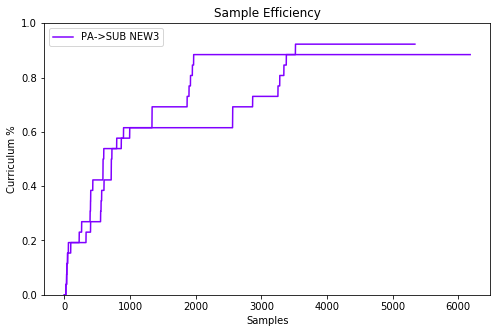

In [52]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['817', '180'], 'PA->CC3 Re-Weight'),
    (['813', '814'], 'PA->CC3 Re-Weight Pretrained'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['827', '828'], 'PA->SUB NEW3'),
    (['819', '820'], 'PA->SUB Re-Weight'),
    (['815', '816'], 'PA->SUB Re-Weight Pretrained'),
]
plot_curriculum(data_names, 'samples')


## <font color='purple'> Hyperparameter tuning (included dropout and pretrained)  </font>

No files found with name 0627
couldn't plot PA
No files found with name 0787
couldn't plot PA NEW2
Length 2261
Length 2417
Length 3960
Length 4068


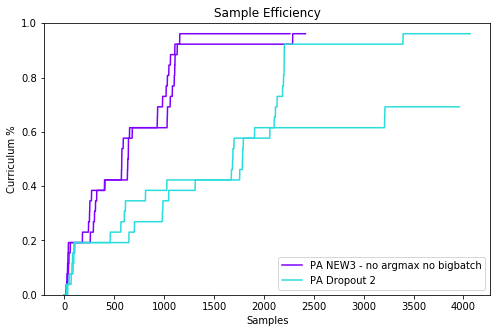

No files found with name 0666
couldn't plot PA->CC3
No files found with name 0789
couldn't plot PA->CC3 NEW2
No files found with name 0825
couldn't plot PA->CC3 NEW3 - no argmax
No files found with name 0821
couldn't plot PA->CC3 NEW3 - no argmax no bigbatch
Length 5135
Length 16711
No files found with name 859
couldn't plot Pretrained CC3 -> None


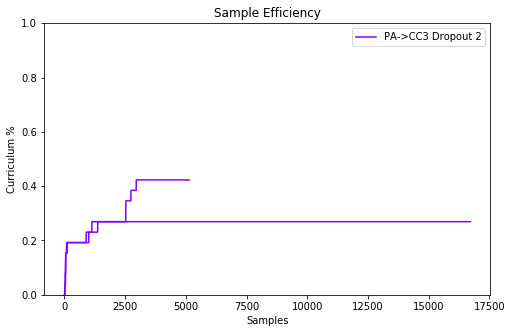

No files found with name 0668
couldn't plot PA->SUB
No files found with name 0791
couldn't plot PA->SUB NEW2
Length 5341
Length 6183
No files found with name 0823
couldn't plot PA->SUB NEW3 - no argmax no bigbatch
Length 3873
Length 5086


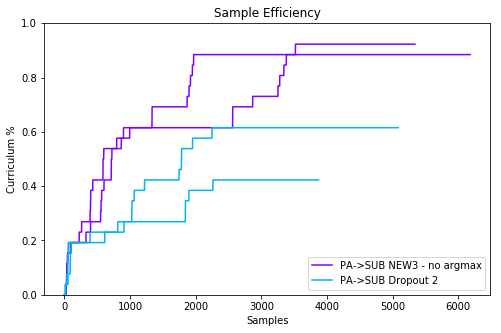

No files found with name 0481
couldn't plot None
No files found with name 0751
couldn't plot None NEW
No files found with name 0785
couldn't plot None NEW2


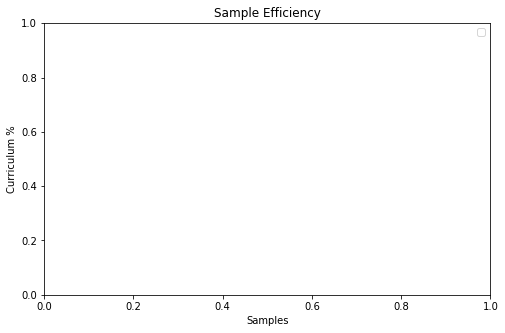

In [53]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0627', '0628'], 'PA'),
#     (['0753', '0754'], 'PA NEW'),
    (['0787', '0788'], 'PA NEW2'),
    (['867', '868'], 'PA NEW3 - no argmax no bigbatch'),
    (['801', '802'], 'PA Dropout 2'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0666', '0667'], 'PA->CC3'),
#     (['0755', '0756'], 'PA->CC3 NEW'),
    (['0789', '0790'], 'PA->CC3 NEW2'),
    (['0825', '0826'], 'PA->CC3 NEW3 - no argmax'),
    (['0821', '0822'], 'PA->CC3 NEW3 - no argmax no bigbatch'),
    (['803', '804'], 'PA->CC3 Dropout 2'),
    (['859', '860'], 'Pretrained CC3 -> None'),
]
plot_curriculum(data_names, 'samples')
data_names = [
    (['0668', '0669'], 'PA->SUB'),
#     (['0757', '0758'], 'PA->SUB NEW'),
    (['0791', '0792'], 'PA->SUB NEW2'),
    (['827', '828'], 'PA->SUB NEW3 - no argmax'),
    (['0823', '0824'], 'PA->SUB NEW3 - no argmax no bigbatch'),
    (['805', '806'], 'PA->SUB Dropout 2'),
]
plot_curriculum(data_names, 'samples')
data_names = [
    (['0481'], 'None'),
    (['0751', '0752'], 'None NEW'),
    (['0785', '0786'], 'None NEW2'),
]
plot_curriculum(data_names, 'samples')




No files found with name 0779
couldn't plot PA (nodistill)
No files found with name 0627
couldn't plot PA
No files found with name 0753
couldn't plot PA NEW
No files found with name 0787
couldn't plot PA NEW2
No files found with name 0759
couldn't plot PA PRETRAINED
No files found with name 0793
couldn't plot PA PRETRAINED2
Length 3960
Length 4068


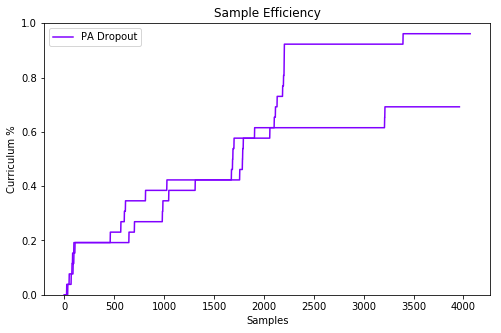

No files found with name 0779
couldn't plot PA (nodistill)
No files found with name 0627
couldn't plot PA
No files found with name 0753
couldn't plot PA NEW
No files found with name 0787
couldn't plot PA NEW2
No files found with name 0759
couldn't plot PA PRETRAINED
No files found with name 0793
couldn't plot PA PRETRAINED2
Length 3960
Length 4068


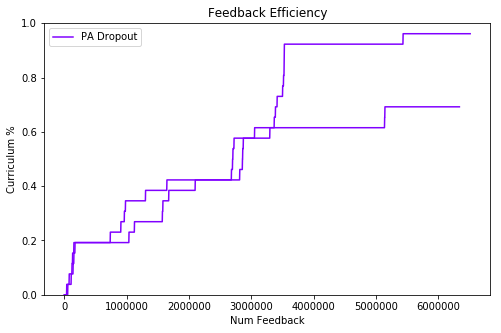

No files found with name 0781
couldn't plot PA->CC3 (nodistill)
No files found with name 0666
couldn't plot PA->CC3
No files found with name 0755
couldn't plot PA->CC3 NEW
No files found with name 0789
couldn't plot PA->CC3 NEW2
No files found with name 0761
couldn't plot CC3 PRETRAINED
No files found with name 0795
couldn't plot CC3 PRETRAINED2
Length 5135
Length 16711


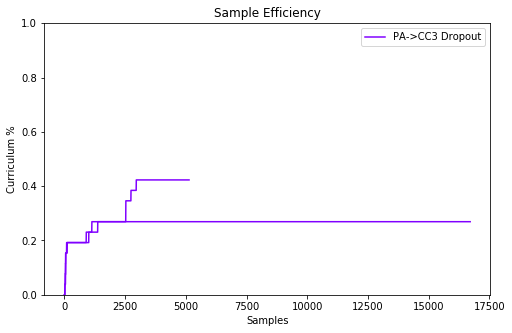

No files found with name 0781
couldn't plot PA->CC3 (nodistill)
No files found with name 0666
couldn't plot PA->CC3
No files found with name 0755
couldn't plot PA->CC3 NEW
No files found with name 0789
couldn't plot PA->CC3 NEW2
No files found with name 0761
couldn't plot CC3 PRETRAINED
No files found with name 0795
couldn't plot CC3 PRETRAINED2
Length 5135
Length 16711


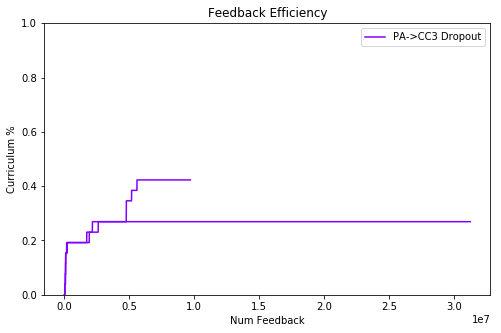

No files found with name 0783
couldn't plot PA->SUB (nodistill)
No files found with name 0668
couldn't plot PA->SUB
No files found with name 0757
couldn't plot PA->SUB NEW
No files found with name 0791
couldn't plot PA->SUB NEW2
No files found with name 0763_SUB_teacherSub
couldn't plot SUB PRETRAINED
No files found with name 0797
couldn't plot SUB PRETRAINED2
Length 3873
Length 5086


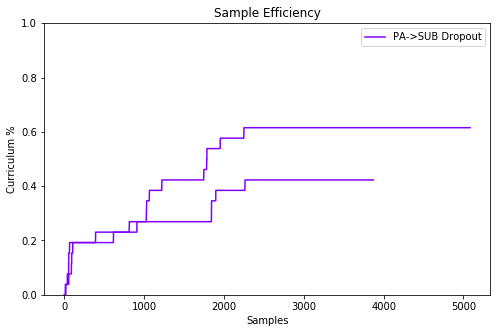

No files found with name 0783
couldn't plot PA->SUB (nodistill)
No files found with name 0668
couldn't plot PA->SUB
No files found with name 0757
couldn't plot PA->SUB NEW
No files found with name 0791
couldn't plot PA->SUB NEW2
No files found with name 0763_SUB_teacherSub
couldn't plot SUB PRETRAINED
No files found with name 0797
couldn't plot SUB PRETRAINED2
Length 3873
Length 5086


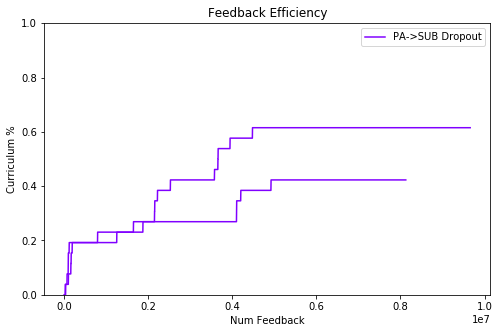

Length 946
Length 1193
No files found with name 0481
couldn't plot None
No files found with name 0751
couldn't plot None NEW
No files found with name 0785
couldn't plot None NEW2


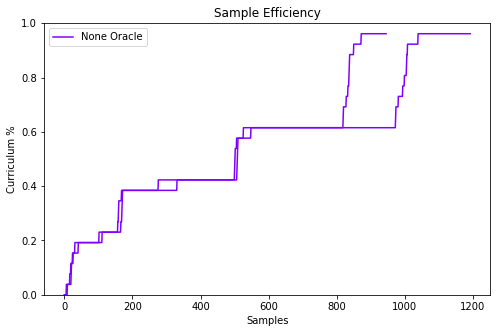

Length 946
Length 1193
No files found with name 0481
couldn't plot None
No files found with name 0751
couldn't plot None NEW
No files found with name 0785
couldn't plot None NEW2


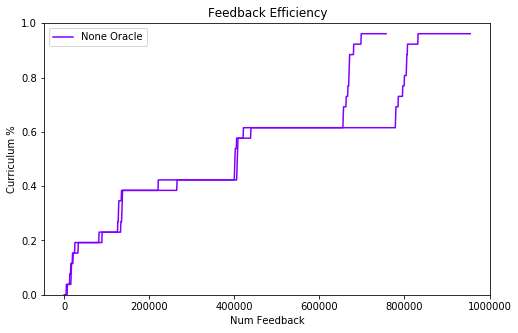

In [54]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [  # TODO: re-run these 
    (['0779', '0780'], 'PA (nodistill)'),
    (['0627', '0628'], 'PA'),
    (['0753', '0754'], 'PA NEW'),
    (['0787', '0788'], 'PA NEW2'),
    (['0759', '0760'], 'PA PRETRAINED'),
    (['0793', '0794'], 'PA PRETRAINED2'),
    (['801', '802'], 'PA Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [  # TODO: re-run these 
    (['0781', '0782'], 'PA->CC3 (nodistill)'),
    (['0666', '0667'], 'PA->CC3'),
    (['0755', '0756'], 'PA->CC3 NEW'),
    (['0789', '0790'], 'PA->CC3 NEW2'),
    (['0761', '0762'], 'CC3 PRETRAINED'),
    (['0795', '0796'], 'CC3 PRETRAINED2'),
    (['803', '804'], 'PA->CC3 Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [  # TODO: re-run these 
    (['0783', '0784'], 'PA->SUB (nodistill)'),
    (['0668', '0669'], 'PA->SUB'),
    (['0757', '0758'], 'PA->SUB NEW'),
    (['0791', '0792'], 'PA->SUB NEW2'),
    (['0763_SUB_teacherSub', '0764_SUB_teacherSub'], 'SUB PRETRAINED'),
    (['0797', '0798'], 'SUB PRETRAINED2'),
    (['805', '806'], 'PA->SUB Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [
    (['799', '800'], 'None Oracle'),
    (['0481'], 'None'),
    (['0751', '0752'], 'None NEW'),
    (['0785', '0786'], 'None NEW2'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')




## <font color='purple'> Trying to get high accuracy  </font>

Distill to no teacher from BCS model

No files found with name 845
couldn't plot PA
No files found with name 847
couldn't plot CC3
No files found with name 849
couldn't plot SUB


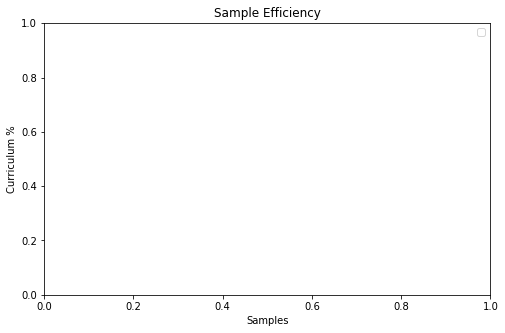

No files found with name 847
couldn't plot BCS CC3 -> None
No files found with name 859
couldn't plot Pretrained CC3 -> None
No files found with name 821
couldn't plot PA -> CC3 -> None


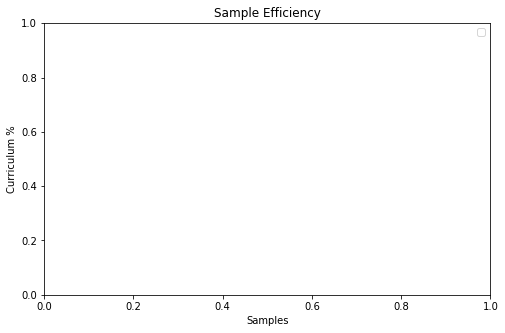

No files found with name 849
couldn't plot BCS SUB -> None
No files found with name 861
couldn't plot Pretrained SUB -> None
No files found with name 823
couldn't plot PA -> SUB -> None


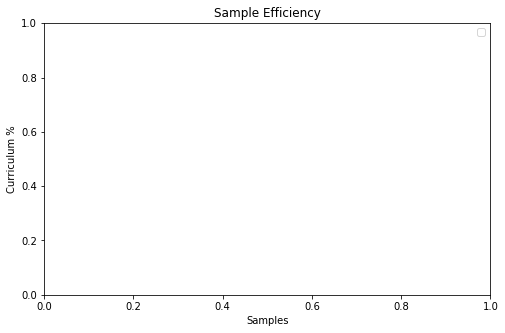

In [55]:
data_names = [ 
    (['845', '846'], 'PA'),
    (['847', '848'], 'CC3'),
    (['849', '850'], 'SUB'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['847', '848'], 'BCS CC3 -> None'),
    (['859', '860'], 'Pretrained CC3 -> None'),
    (['821', '822'], 'PA -> CC3 -> None'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['849', '850'], 'BCS SUB -> None'),
    (['861', '862'], 'Pretrained SUB -> None'),
    (['823', '824'], 'PA -> SUB -> None'),
]
plot_curriculum(data_names, 'samples')

BCS (oracle -> teacher) vs Pseudo-BCS (Pretrained PA --> Teacher) vs Bootstrap (PA --> Teacher)

Takeaway: bootstrapping from PA is almost as good as bootstrapping from the oracle~

No files found with name 659
couldn't plot Oracle -> CC3
No files found with name 851
couldn't plot Pretrained PA -> CC3
No files found with name 855
couldn't plot PA -> CC3


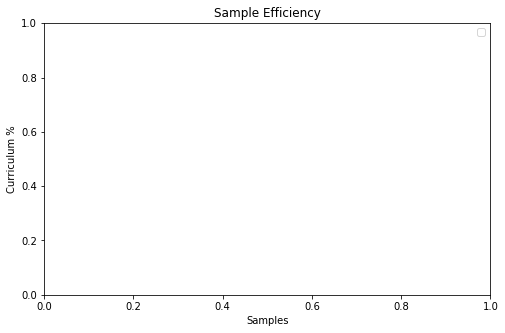

No files found with name 661
couldn't plot Oracle -> SUB
No files found with name 853
couldn't plot Pretrained PA -> SUB
No files found with name 857
couldn't plot PA -> SUB


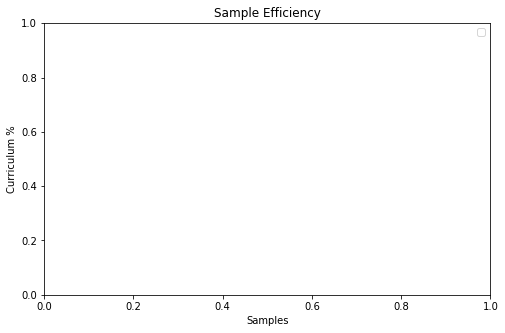

In [56]:
data_names = [ 
    (['659'], 'Oracle -> CC3'),
    (['851'], 'Pretrained PA -> CC3'),
    (['855', '856'], 'PA -> CC3'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['661'], 'Oracle -> SUB'),
    (['853', '854'], 'Pretrained PA -> SUB'),
    (['857', '858'], 'PA -> SUB'),
]
plot_curriculum(data_names, 'samples')


Distill with distribution less biased toward current level

Length 2803
Length 2915
No files found with name 821
couldn't plot CC3 .5 current


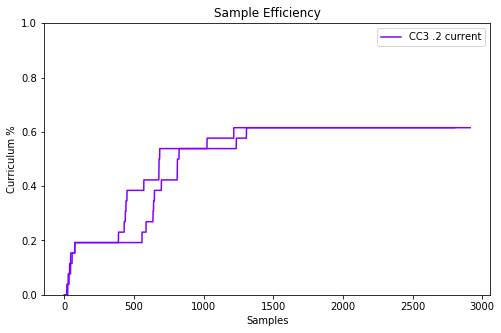

Length 4084
Length 3367
No files found with name 823
couldn't plot SUB .5 current


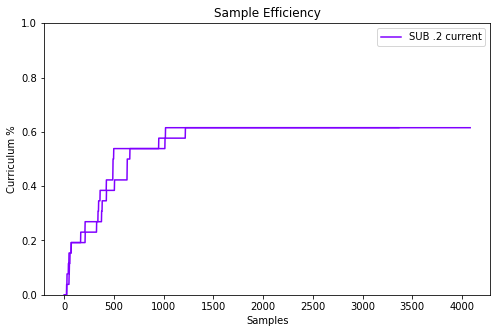

In [57]:

data_names = [ 
    (['863', '864'], 'CC3 .2 current'),
    (['821', '822'], 'CC3 .5 current'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['865', '866'], 'SUB .2 current'),
    (['823', '824'], 'SUB .5 current'),
]
plot_curriculum(data_names, 'samples')

Way more distillation itrs

No files found with name 821
couldn't plot CC3 Normal
Length 3954
Length 4051
No files found with name 899
couldn't plot CC3 Even More Itrs


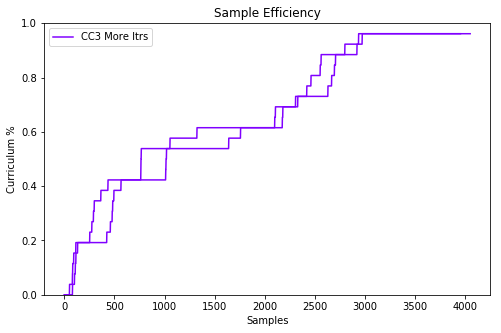

No files found with name 823
couldn't plot SUB Normal
Length 8933
Length 8532
No files found with name 901
couldn't plot SUB Even More Itrs


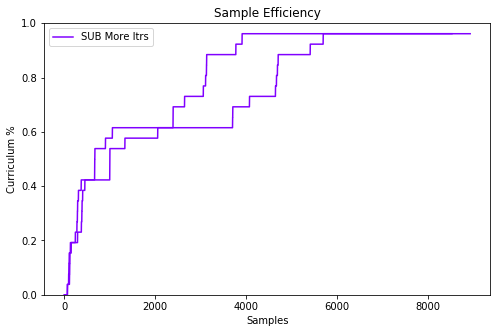

In [58]:

data_names = [ 
    (['821', '822'], 'CC3 Normal'),
    (['869', '870'], 'CC3 More Itrs'),
    (['899', '900'], 'CC3 Even More Itrs'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'SUB Normal'),
    (['871', '872'], 'SUB More Itrs'),
    (['901', '902'], 'SUB Even More Itrs'),
]
plot_curriculum(data_names, 'samples')

High accuracy + run forever (goal is to see if generalization improves)

No files found with name 0821
couldn't plot PA -> CC3 Normal
Length 15447
Length 15352


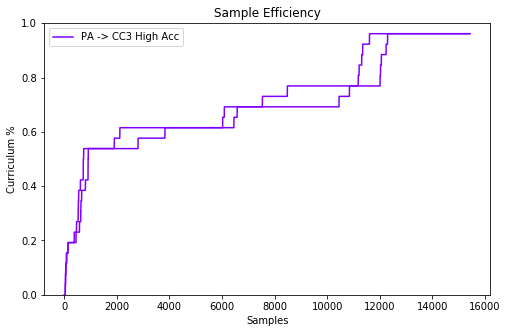

No files found with name 823
couldn't plot PA -> SUB Normal
Length 1263
Length 22


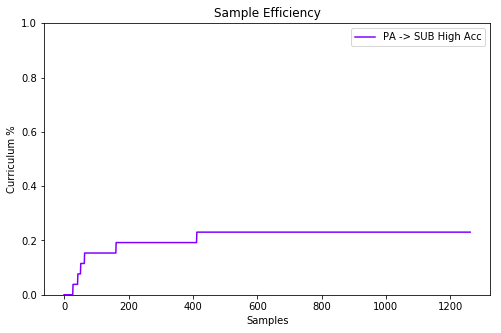

In [59]:
data_names = [ 
    (['0821', '0822'], 'PA -> CC3 Normal'),
    (['0873', '0874'], 'PA -> CC3 High Acc'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['875', '876'], 'PA -> SUB High Acc'),
]
plot_curriculum(data_names, 'samples')

Does increasing the acc threshold when we're using PA help?

No files found with name 821
couldn't plot PA -> CC3 Normal
No files found with name 0903
couldn't plot PA -> CC3 High Acc


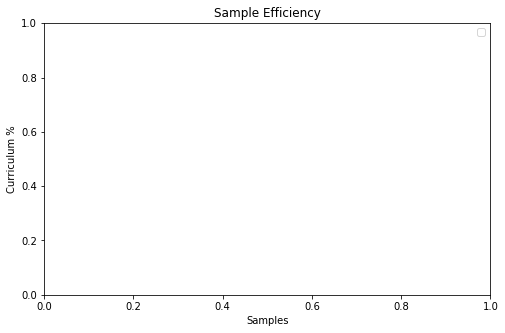

No files found with name 823
couldn't plot PA -> SUB Normal
No files found with name 0905
couldn't plot PA -> SUB High Acc


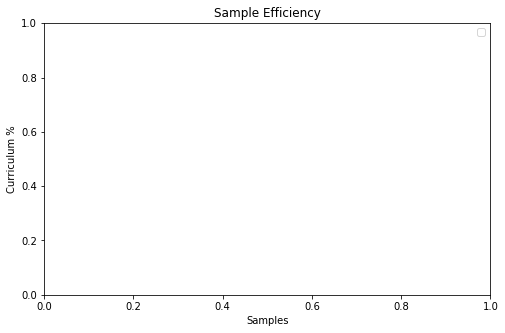

In [60]:
data_names = [ 
    (['821', '822'], 'PA -> CC3 Normal'),
    (['0903', '0904'], 'PA -> CC3 High Acc'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['0905', '0906'], 'PA -> SUB High Acc'),
]
plot_curriculum(data_names, 'samples')

Does increasing LR help?

No files found with name 821
couldn't plot PA -> CC3 Normal
No files found with name 0907
couldn't plot PA -> CC3 High LR
No files found with name 0911
couldn't plot PA -> CC3 High LR2


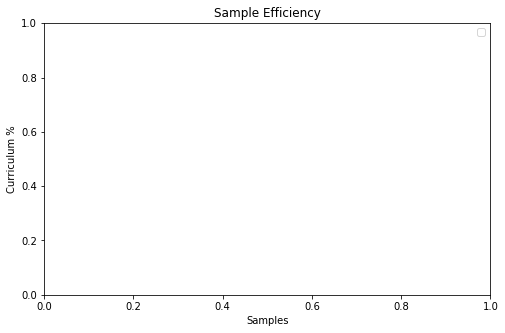

No files found with name 823
couldn't plot PA -> SUB Normal
No files found with name 0909
couldn't plot PA -> SUB High LR
No files found with name 0913
couldn't plot PA -> SUB High LR2


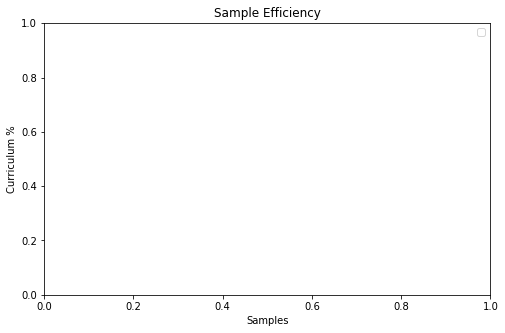

In [61]:
data_names = [ 
    (['821', '822'], 'PA -> CC3 Normal'),
    (['0907', '0908'], 'PA -> CC3 High LR'),
    (['0911', '0912'], 'PA -> CC3 High LR2'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['0909', '0910'], 'PA -> SUB High LR'),
    (['0913', '0914'], 'PA -> SUB High LR2'),
]
plot_curriculum(data_names, 'samples')

Does high acc + low entropy help?

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0955
couldn't plot PA -> CC3  Ent /10


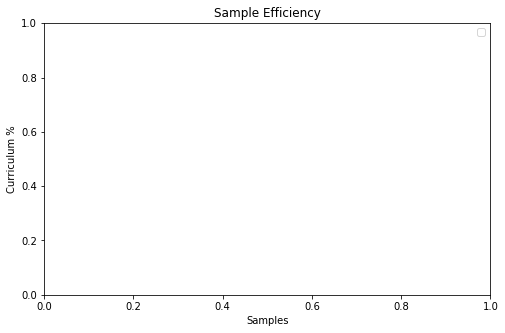

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0955
couldn't plot PA -> CC3  Ent /10


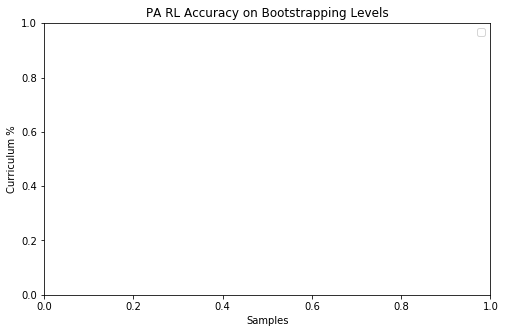

In [62]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
#     (['0931', '0932'], 'PA -> CC3 Help'), # Third best; cheats by using PA a lot
#     (['0933', '0934'], 'PA -> CC3 Help + RL Acc .9'), # Second Best; cheats by using PA a lot
#     (['0935', '0936'], 'PA -> CC3 -> None'), # Not great; stoppable
#     (['0937', '0938'], 'PA -> CC3 -> None + RL Acc .9'), # Best; cheats by using PA a lot
#     (['0939', '0940'], 'PA -> CC3 -> None + High PA Acc'), # Not great; stoppable
    (['0955', '0956'], 'PA -> CC3  Ent /10'),
#     (['0963', '0964'], 'PA -> CC3 -> None + RL Acc .9 Ent /10'), # Bad; stoppable, but we should analyze
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

Length 2261
Length 2417
No files found with name 0953
couldn't plot PA Ent /10, RL Acc .9
No files found with name 0957
couldn't plot PA Ent /100, RL Acc .9


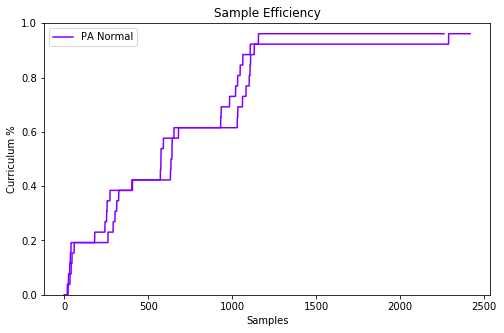

Length 575
Length 635
No files found with name 0953
couldn't plot PA Ent /10, RL Acc .9
No files found with name 0957
couldn't plot PA Ent /100, RL Acc .9


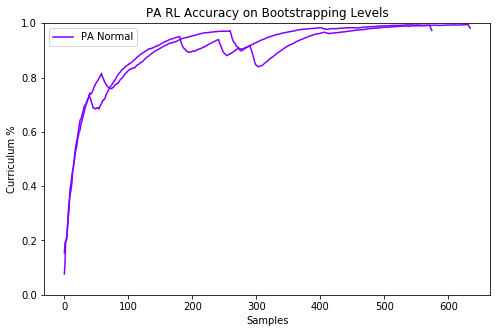

In [63]:
data_names = [ 
    (['867', '868'], 'PA Normal'),
    (['0953', '0954'], 'PA Ent /10, RL Acc .9'),
    (['0957', '0958'], 'PA Ent /100, RL Acc .9'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

Combining argmax, sample, logits

No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 0971
couldn't plot PA -> CC3 Sample + Sep Models
No files found with name 0973
couldn't plot PA -> CC3 Argmax + no self-distill
No files found with name 0975
couldn't plot PA -> CC3 Logits + no self-distill
No files found with name 977
couldn't plot PA -> CC3 Logits


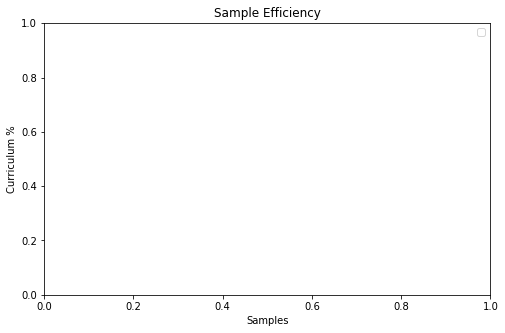

In [64]:
data_names = [ # TODO: GENERALIZATION!!!
#     (['0967', '0968'], 'PA -> CC3 Argmax'), # BAD; all others are basically the same
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['0971', '0972'], 'PA -> CC3 Sample + Sep Models'),
    (['0973', '0974'], 'PA -> CC3 Argmax + no self-distill'),
    (['0975', '976'], 'PA -> CC3 Logits + no self-distill'),
    (['977', '978'], 'PA -> CC3 Logits'),
]
plot_curriculum(data_names, 'samples')

Higher entropy first 10 itrs

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0951
couldn't plot CC3 Normal
No files found with name 0967
couldn't plot PA -> CC3 Argmax Normal
No files found with name 0981
couldn't plot PA -> CC3 Sample ent / 10
No files found with name 0983
couldn't plot PA -> CC3 Argmax


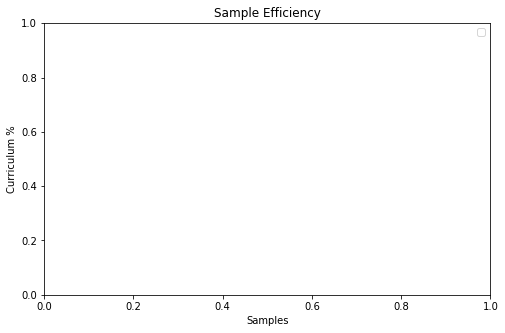

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0951
couldn't plot CC3 Normal
No files found with name 0981
couldn't plot PA -> CC3 Sample ent / 10


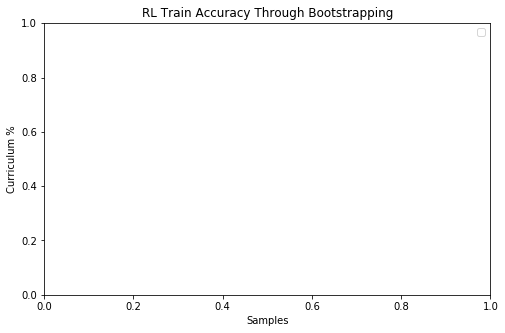

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0951
couldn't plot CC3 Normal
No files found with name 0981
couldn't plot PA -> CC3 Sample ent / 10


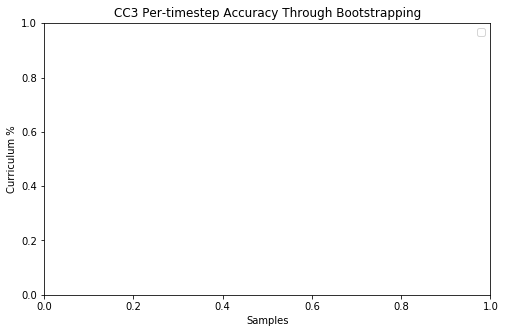

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0951
couldn't plot CC3 Normal
No files found with name 0981
couldn't plot PA -> CC3 Sample ent / 10


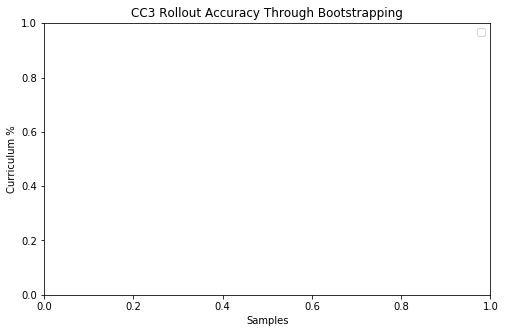

In [65]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0967', '0968'], 'PA -> CC3 Argmax Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
    (['0983', '0984'], 'PA -> CC3 Argmax'),
]
plot_curriculum(data_names, 'samples')
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
]

plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="RL Train Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy Through Bootstrapping")

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0951
couldn't plot CC3 Normal
No files found with name 0967
couldn't plot PA -> CC3 Argmax Normal
No files found with name 0981
couldn't plot PA -> CC3 Sample ent / 10
No files found with name 0983
couldn't plot PA -> CC3 Argmax


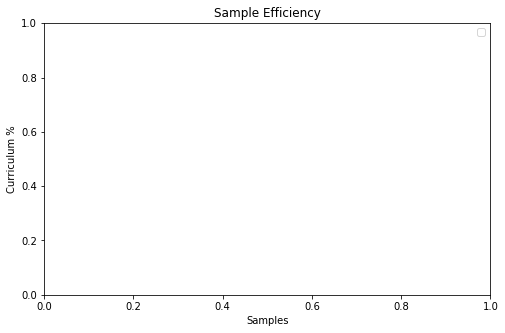

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0951
couldn't plot CC3 Normal
No files found with name 0981
couldn't plot PA -> CC3 Sample ent / 10


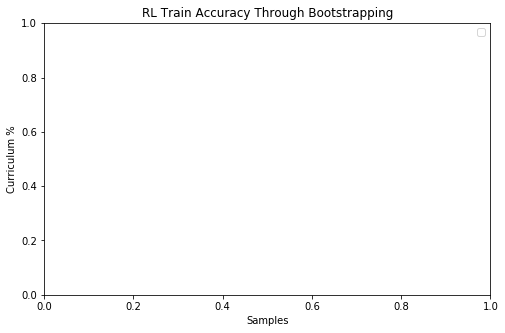

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0951
couldn't plot CC3 Normal
No files found with name 0981
couldn't plot PA -> CC3 Sample ent / 10


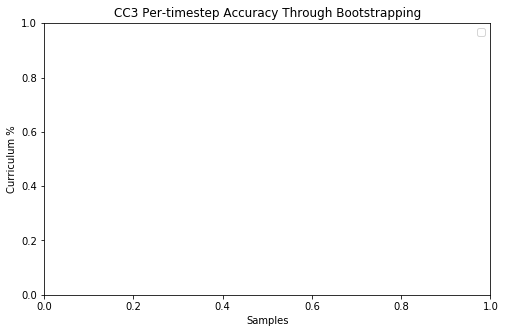

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0951
couldn't plot CC3 Normal
No files found with name 0981
couldn't plot PA -> CC3 Sample ent / 10


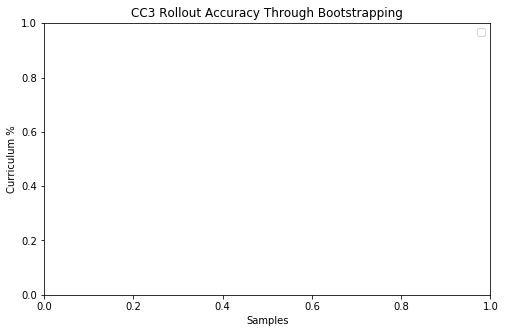

In [66]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0967', '0968'], 'PA -> CC3 Argmax Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
    (['0983', '0984'], 'PA -> CC3 Argmax'),
]
plot_curriculum(data_names, 'samples')
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
]

plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="RL Train Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy Through Bootstrapping")

Fake CC3 labels

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0985
couldn't plot PA -> CC3 Fake CC3 labels + self-distill
No files found with name 0986
couldn't plot PA -> CC3 Fake CC3 labels no self-distill
No files found with name 0995
couldn't plot PA -> CC3 Fake CC3 labels logits


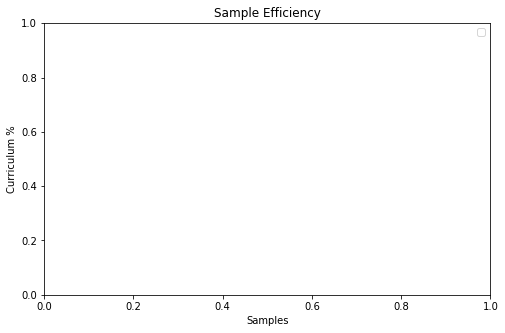

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0985
couldn't plot PA -> CC3 Fake CC3 labels + self-distill
No files found with name 0986
couldn't plot PA -> CC3 Fake CC3 labels no self-distill
No files found with name 0995
couldn't plot PA -> CC3 Fake CC3 labels logits


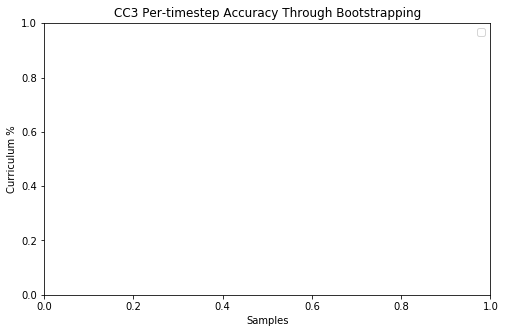

No files found with name 0943
couldn't plot PA -> CC3 Normal
No files found with name 0985
couldn't plot PA -> CC3 Fake CC3 labels + self-distill
No files found with name 0986
couldn't plot PA -> CC3 Fake CC3 labels no self-distill
No files found with name 0995
couldn't plot PA -> CC3 Fake CC3 labels logits


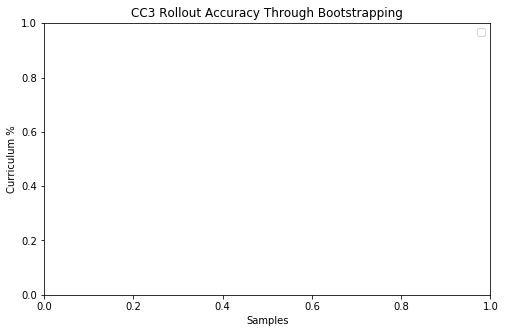

In [67]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0985', '0986'], 'PA -> CC3 Fake CC3 labels + self-distill'),
    (['0986', '0987'], 'PA -> CC3 Fake CC3 labels no self-distill'),
    (['0995', '0996'], 'PA -> CC3 Fake CC3 labels logits'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy Through Bootstrapping")

Length 2756
Length 2596
No files found with name 0975
couldn't plot PA -> CC3 sampling
No files found with name 0991
couldn't plot PA -> CC3 Source Teacher
No files found with name 0985
couldn't plot PA -> CC3 Fake CC3 Feedback sampling
No files found with name 0995
couldn't plot PA -> CC3 Fake CC3 labels logits
No files found with name 0997
couldn't plot Distill from  oracle


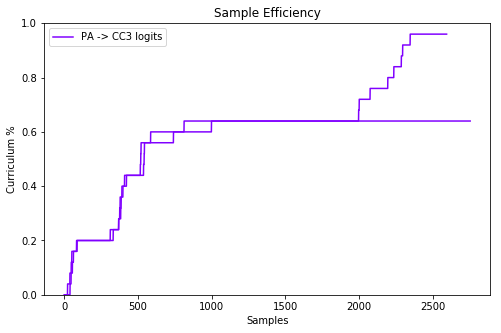

Length 519
Length 542
No files found with name 0975
couldn't plot PA -> CC3 sampling
No files found with name 0991
couldn't plot PA -> CC3 Source Teacher
No files found with name 0985
couldn't plot PA -> CC3 Fake CC3 Feedback sampling
No files found with name 0995
couldn't plot PA -> CC3 Fake CC3 labels logits
No files found with name 0997
couldn't plot Distill from  oracle


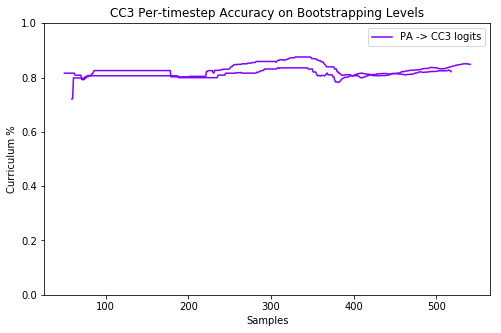

Length 519
Length 542
No files found with name 0975
couldn't plot PA -> CC3 sampling
No files found with name 0991
couldn't plot PA -> CC3 Source Teacher
No files found with name 0985
couldn't plot PA -> CC3 Fake CC3 Feedback sampling
No files found with name 0995
couldn't plot PA -> CC3 Fake CC3 labels logits
No files found with name 0997
couldn't plot Distill from  oracle


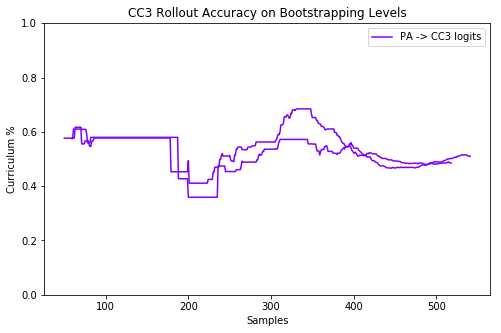

Length 519
Length 542
No files found with name 0975
couldn't plot PA -> CC3 sampling
No files found with name 0991
couldn't plot PA -> CC3 Source Teacher
No files found with name 0985
couldn't plot PA -> CC3 Fake CC3 Feedback sampling
No files found with name 0995
couldn't plot PA -> CC3 Fake CC3 labels logits
No files found with name 0997
couldn't plot Distill from  oracle


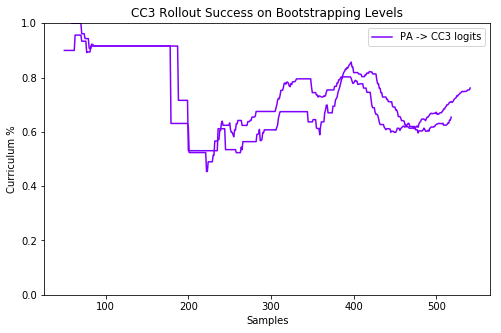

Length 519
Length 542
No files found with name 0975
couldn't plot PA -> CC3 sampling
No files found with name 0991
couldn't plot PA -> CC3 Source Teacher
No files found with name 0985
couldn't plot PA -> CC3 Fake CC3 Feedback sampling
No files found with name 0995
couldn't plot PA -> CC3 Fake CC3 labels logits
No files found with name 0997
couldn't plot Distill from  oracle


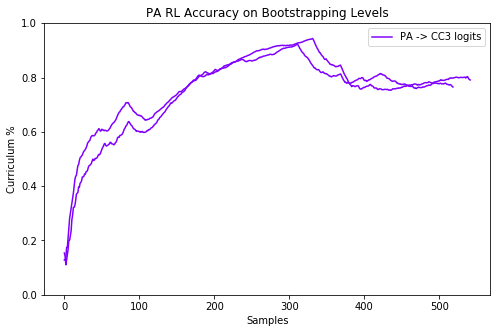

Length 519
Length 542
No files found with name 0975
couldn't plot PA -> CC3 sampling
No files found with name 0991
couldn't plot PA -> CC3 Source Teacher
No files found with name 0985
couldn't plot PA -> CC3 Fake CC3 Feedback sampling
No files found with name 0995
couldn't plot PA -> CC3 Fake CC3 labels logits
No files found with name 0997
couldn't plot Distill from  oracle


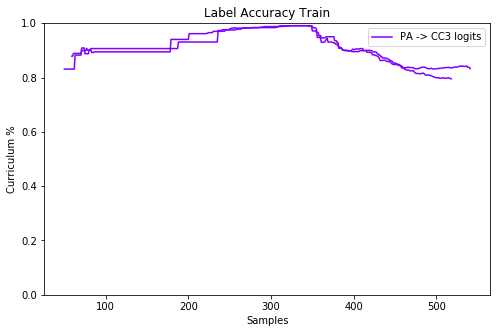

Length 519
Length 542
No files found with name 0975
couldn't plot PA -> CC3 sampling
No files found with name 0991
couldn't plot PA -> CC3 Source Teacher
No files found with name 0985
couldn't plot PA -> CC3 Fake CC3 Feedback sampling
No files found with name 0995
couldn't plot PA -> CC3 Fake CC3 labels logits
No files found with name 0997
couldn't plot Distill from  oracle


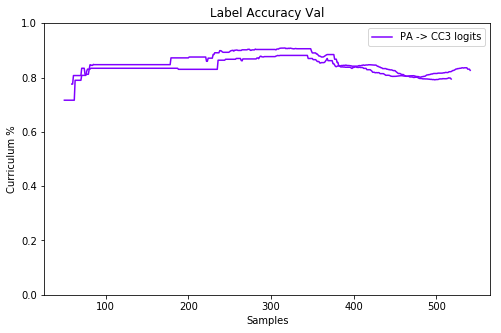

In [68]:
data_names = [ 
    (['979', '980'], 'PA -> CC3 logits'),
#     (['967', '968'], 'PA -> CC3 Argmax'),
#     (['977', '978'], 'PA -> CC3 Normal (logits, no self-distill)'),
    (['0975', '0976'], 'PA -> CC3 sampling'),
    (['0991', '0992'], 'PA -> CC3 Source Teacher'),
    (['0985', '0986'], 'PA -> CC3 Fake CC3 Feedback sampling'),
    (['0995', '0996'], 'PA -> CC3 Fake CC3 labels logits'),
#     (['867', '868'], 'PA'),
    (['0997', '0998', '1033'], 'Distill from  oracle'),
]


# self-dsitill is good!

plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Train")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Val")

No files found with name 1033
couldn't plot Distill from  oracle


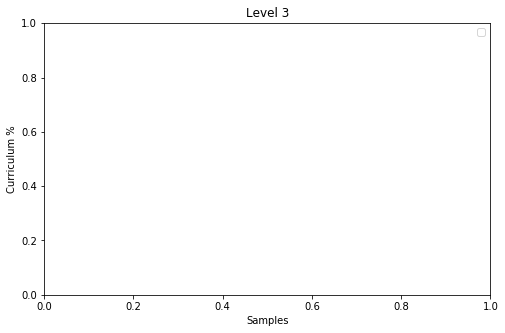

No files found with name 1033
couldn't plot Distill from  oracle


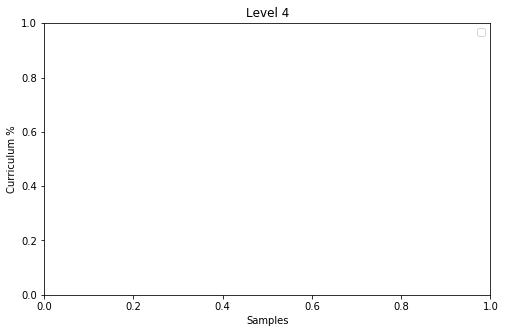

No files found with name 1033
couldn't plot Distill from  oracle


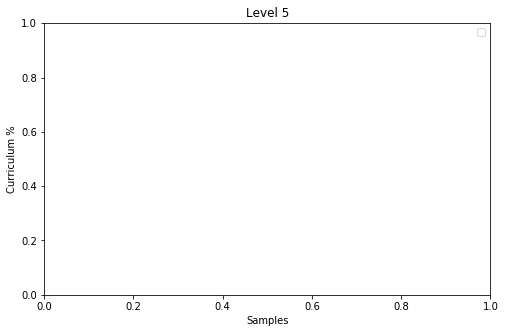

No files found with name 1033
couldn't plot Distill from  oracle


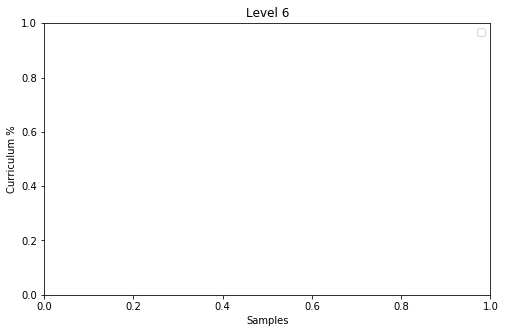

No files found with name 1033
couldn't plot Distill from  oracle


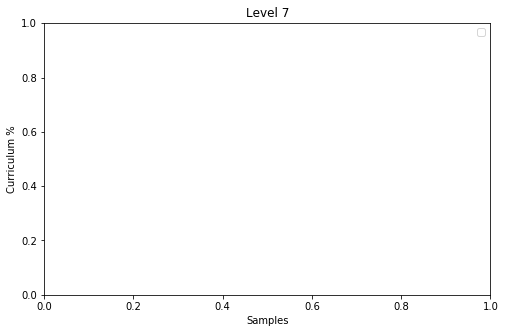

No files found with name 1033
couldn't plot Distill from  oracle


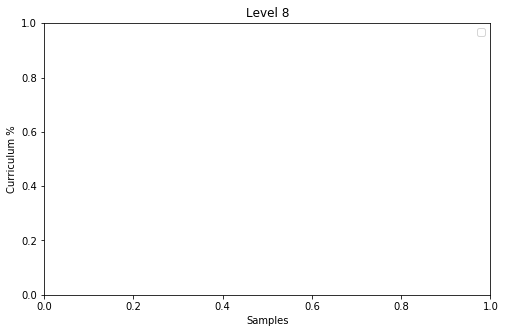

No files found with name 1033
couldn't plot Distill from  oracle


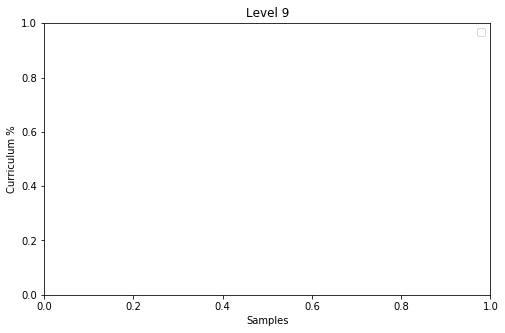

No files found with name 1033
couldn't plot Distill from  oracle


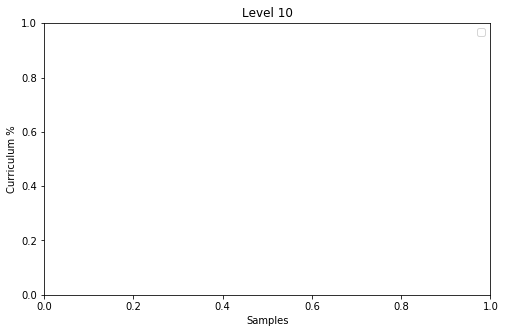

No files found with name 1033
couldn't plot Distill from  oracle


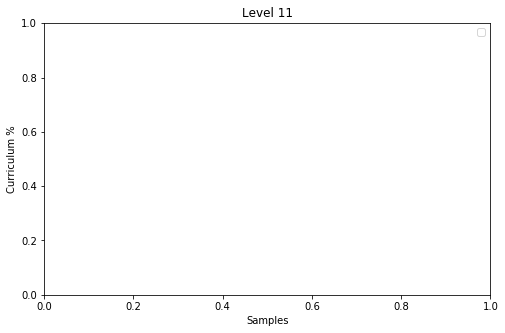

In [69]:
data_names = [ 
    (['1033'], 'Distill from  oracle'),
] # kangaroo

for i in range(3, 12):
    plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=1, 
                level_start=i, level_end=i, title=f"Level {i}")

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle
No files found with name 1145
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .9
No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


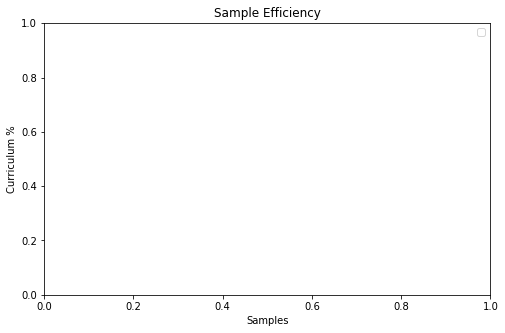

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle
No files found with name 1145
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .9
No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


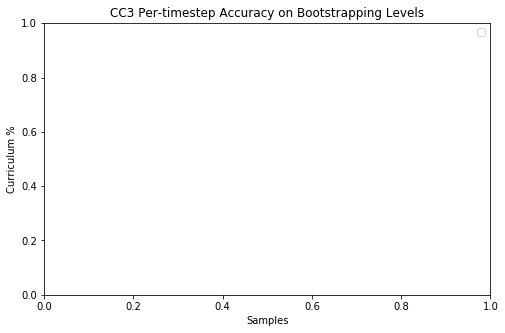

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle
No files found with name 1145
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .9
No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


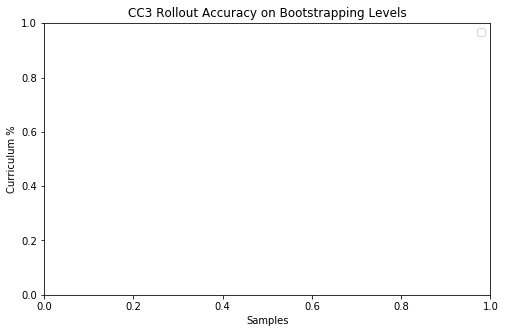

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle
No files found with name 1145
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .9
No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


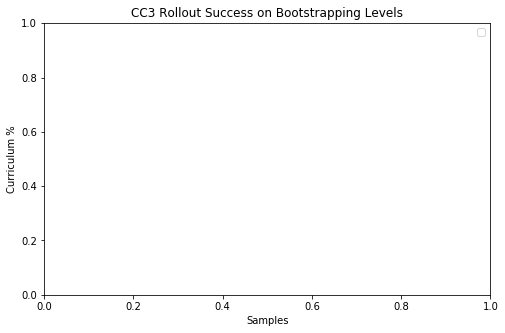

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle
No files found with name 1145
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .9
No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


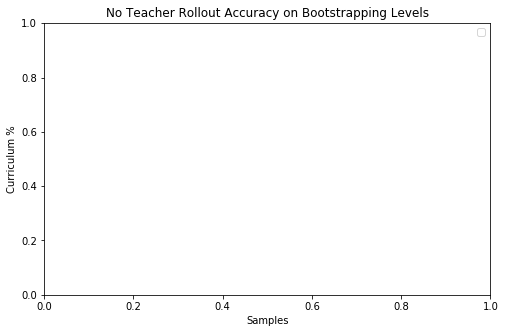

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle
No files found with name 1145
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .9
No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


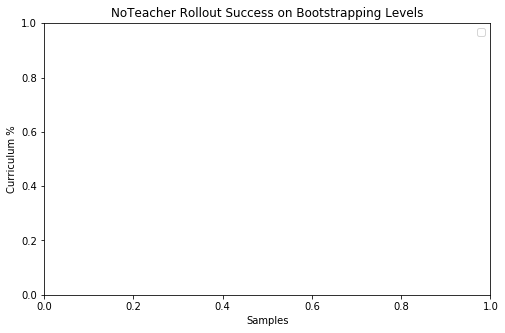

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle
No files found with name 1145
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .9
No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


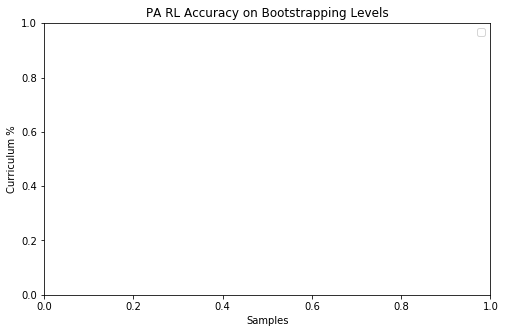

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle
No files found with name 1145
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .9
No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


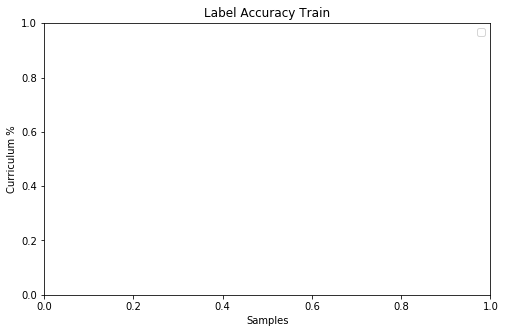

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle
No files found with name 1145
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .9
No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


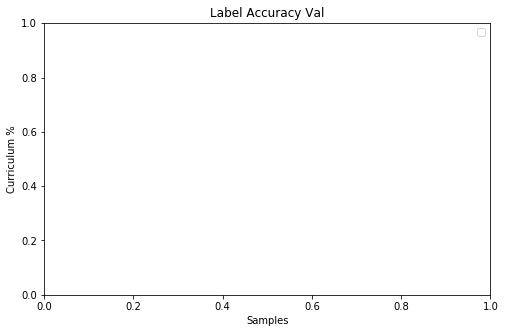

In [70]:
data_names = [ 
#     (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
    (['1072'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8'),
    (['1073'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9'),
    (['0997', '0998'], 'Distill from  oracle'),
    (['1145'], 'PA -> CC3 easy_swap_harder logits threshold_distill .9'),
    (['1146'], 'PA -> Distill from  oracle threshold_distill .9'),
]


# self-dsitill is good!

plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=10, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=10, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='DRollout/AvgAccuracy', smooth=10, 
                level_start=0, level_end=12, title="No Teacher Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='DRollout/AverageSuccess', smooth=10, 
                level_start=0, level_end=12, title="NoTeacher Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Train")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Val")

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle


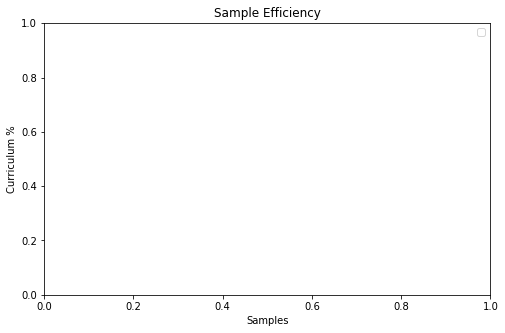

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle


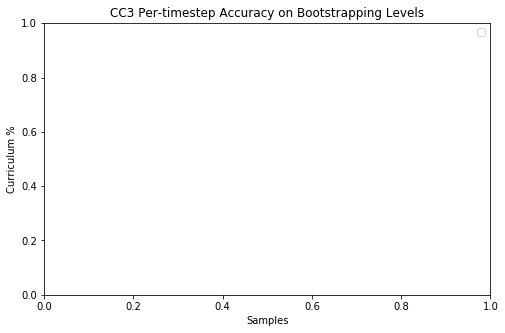

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle


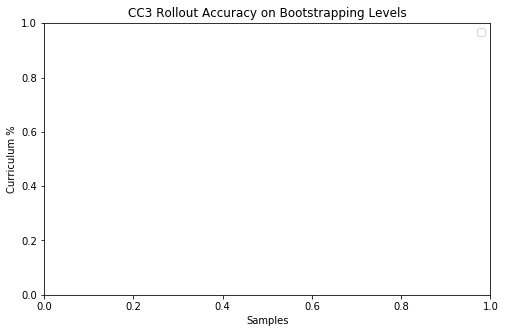

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle


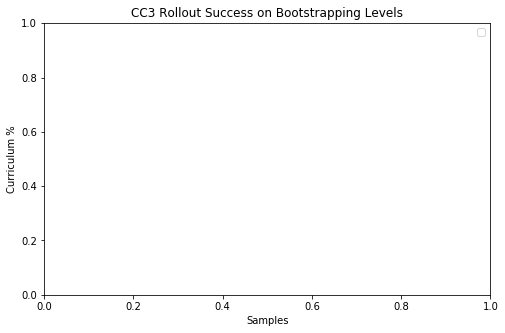

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle


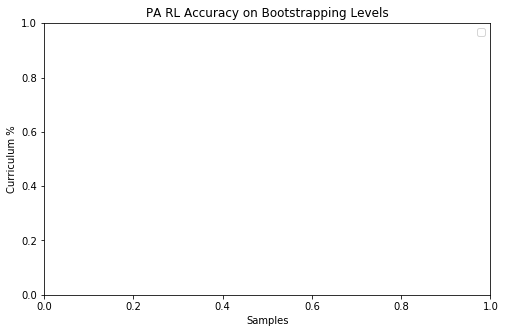

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle


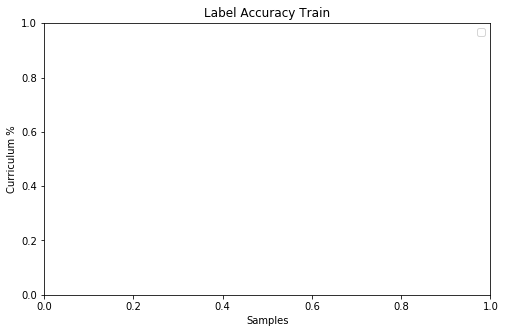

No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8
No files found with name 1072
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8
No files found with name 1073
couldn't plot PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9
No files found with name 0997
couldn't plot Distill from  oracle


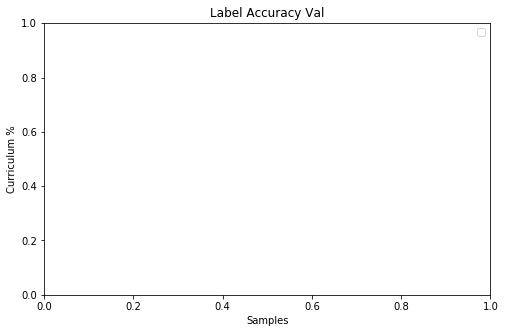

In [71]:
data_names = [ 
#     (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
    (['1072'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8'),
    (['1073'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9'),
    (['0997', '0998'], 'Distill from  oracle'),
]


# self-dsitill is good!

plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Train")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Val")

## How can we get good PA accuracy?

No files found with name 0953
couldn't plot PA Ent /10, RL Acc .9
No files found with name 0895
couldn't plot PA -> CC3 Nodistill
Length 519
Length 542
Length 575
Length 635
No files found with name 0971
couldn't plot PA -> CC3 Sample + Sep Models
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 0877
couldn't plot PA Nodistill


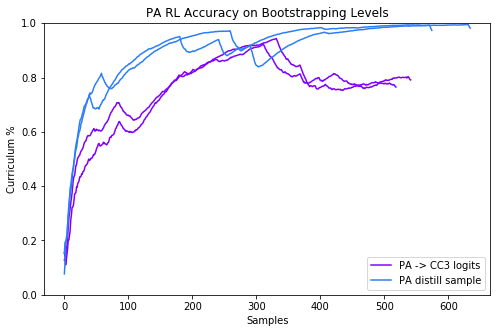

No files found with name 0953
couldn't plot PA Ent /10, RL Acc .9
No files found with name 0895
couldn't plot PA -> CC3 Nodistill
Length 2756
Length 2596
Length 2261
Length 2417
No files found with name 0971
couldn't plot PA -> CC3 Sample + Sep Models
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 0877
couldn't plot PA Nodistill


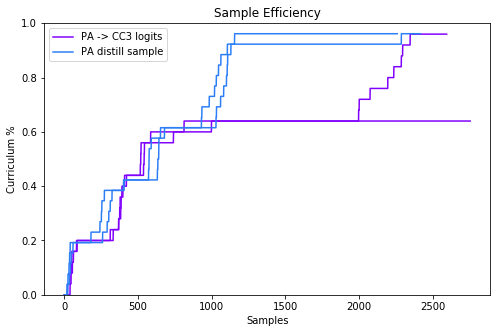

No files found with name 0953
couldn't plot PA Ent /10, RL Acc .9
No files found with name 0895
couldn't plot PA -> CC3 Nodistill
Length 519
Length 542
'Distill/CartesianCorrectionsLabel_Accuracy_Train'
couldn't plot PA distill sample
No files found with name 0971
couldn't plot PA -> CC3 Sample + Sep Models
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 0877
couldn't plot PA Nodistill


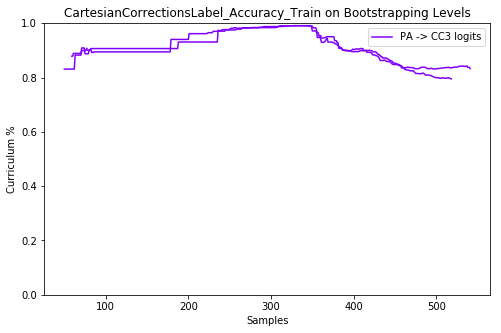

In [72]:
data_names = [ 
#     (['867', '868'], 'PA Normal'),
    (['0953', '0954'], 'PA Ent /10, RL Acc .9'),
#     (['0957', '0958'], 'PA Ent /100, RL Acc .9'),
#     (['0943', '0944'], 'PA -> CC3 Normal'),
#     (['0931', '0932'], 'PA -> CC3 Help'), # Third best; cheats by using PA a lot
#     (['0933', '0934'], 'PA -> CC3 Help + RL Acc .9'), # Second Best; cheats by using PA a lot
#     (['0935', '0936'], 'PA -> CC3 -> None'), # Not great; stoppable
#     (['0937', '0938'], 'PA -> CC3 -> None + RL Acc .9'), # Best; cheats by using PA a lot
#     (['0939', '0940'], 'PA -> CC3 -> None + High PA Acc'), # Not great; stoppable
#     (['0955', '0956'], 'PA -> CC3  Ent /10'),
#     (['0963', '0964'], 'PA -> CC3 -> None + RL Acc .9 Ent /10'), # Bad; stoppable, but we should analyze
    (['0895', '0896'], 'PA -> CC3 Nodistill'), # Bad; stoppable, but we should analyze
#     (['0943', '0944'], 'PA -> CC3 Normal'),
#     (['0951', '0952'], 'CC3 Normal'),
#     (['0967', '0968'], 'PA -> CC3 Argmax Normal'),
#     (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
#     (['0983', '0984'], 'PA -> CC3 Argmax'),
    (['979', '980'], 'PA -> CC3 logits'),
#     (['967', '968'], 'PA -> CC3 Argmax'),
#     (['977', '978'], 'PA -> CC3 Normal (logits, no self-distill)'),
#     (['0975', '0976'], 'PA -> CC3 sampling'),
#     (['0991', '0992'], 'PA -> CC3 Source Teacher'),
#     (['0985', '0986'], 'PA -> CC3 Fake CC3 Feedback sampling'),
    (['867', '868'], 'PA distill sample'),
    
    (['0971', '0972'], 'PA -> CC3 Sample + Sep Models'),
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['0877', '0878'], 'PA Nodistill'),
#     (['0919', '0920'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")

 Can we get good PA Acc?

No files found with name 0999
couldn't plot PA -> PA logits
No files found with name 1000
couldn't plot PA -> PA distill logits
No files found with name 1003
couldn't plot PA -> CC3 easy_swap_harder_noselfdistill logits
No files found with name 1006
couldn't plot PA -> CC3 easy_swap_harder logits nodistill
No files found with name 1007
couldn't plot PA -> CC3 easy_swap_harder logits ent / 10
No files found with name 1008
couldn't plot PA -> CC3 easy_swap_harder logits ent / 100
No files found with name 1009
couldn't plot PA -> CC3 easy_swap_harder logits ent 0
No files found with name 1001
couldn't plot PA -> CC3 easy_swap_harder logits
No files found with name 1067
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .6
No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8


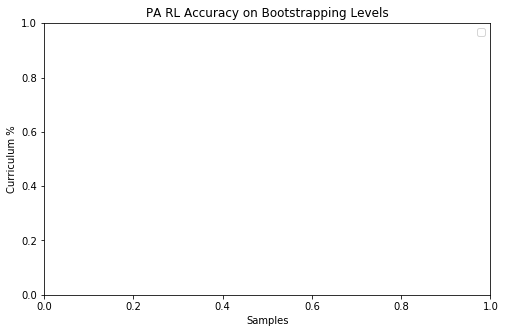

No files found with name 0999
couldn't plot PA -> PA logits
No files found with name 1000
couldn't plot PA -> PA distill logits
No files found with name 1003
couldn't plot PA -> CC3 easy_swap_harder_noselfdistill logits
No files found with name 1006
couldn't plot PA -> CC3 easy_swap_harder logits nodistill
No files found with name 1007
couldn't plot PA -> CC3 easy_swap_harder logits ent / 10
No files found with name 1008
couldn't plot PA -> CC3 easy_swap_harder logits ent / 100
No files found with name 1009
couldn't plot PA -> CC3 easy_swap_harder logits ent 0
No files found with name 1001
couldn't plot PA -> CC3 easy_swap_harder logits
No files found with name 1067
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .6
No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8


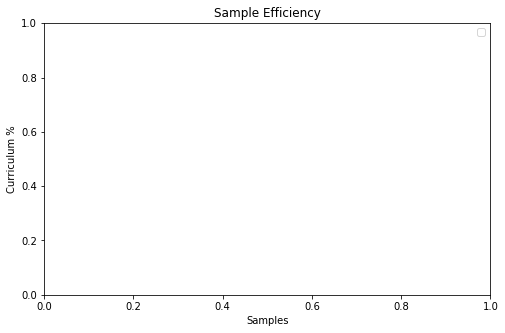

No files found with name 0999
couldn't plot PA -> PA logits
No files found with name 1000
couldn't plot PA -> PA distill logits
No files found with name 1003
couldn't plot PA -> CC3 easy_swap_harder_noselfdistill logits
No files found with name 1006
couldn't plot PA -> CC3 easy_swap_harder logits nodistill
No files found with name 1007
couldn't plot PA -> CC3 easy_swap_harder logits ent / 10
No files found with name 1008
couldn't plot PA -> CC3 easy_swap_harder logits ent / 100
No files found with name 1009
couldn't plot PA -> CC3 easy_swap_harder logits ent 0
No files found with name 1001
couldn't plot PA -> CC3 easy_swap_harder logits
No files found with name 1067
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .6
No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8


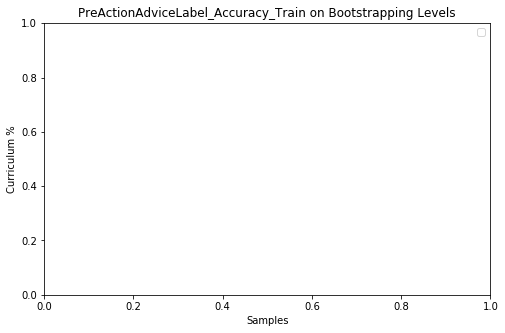

No files found with name 0999
couldn't plot PA -> PA logits
No files found with name 1000
couldn't plot PA -> PA distill logits
No files found with name 1003
couldn't plot PA -> CC3 easy_swap_harder_noselfdistill logits
No files found with name 1006
couldn't plot PA -> CC3 easy_swap_harder logits nodistill
No files found with name 1007
couldn't plot PA -> CC3 easy_swap_harder logits ent / 10
No files found with name 1008
couldn't plot PA -> CC3 easy_swap_harder logits ent / 100
No files found with name 1009
couldn't plot PA -> CC3 easy_swap_harder logits ent 0
No files found with name 1001
couldn't plot PA -> CC3 easy_swap_harder logits
No files found with name 1067
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .6
No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8


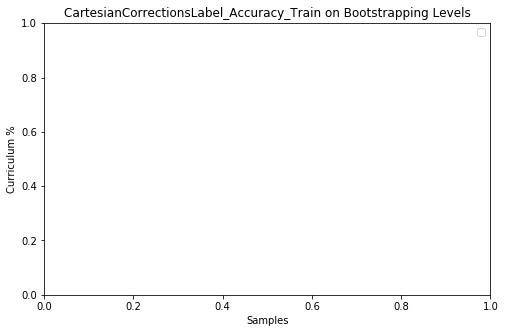

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
No files found with name 1004
couldn't plot PA -> CC3 easy_swap_harder logits, half distillation itrs
No files found with name 1010
couldn't plot PA -> CC3 easy_swap_harder logits ent / 10 sep models
No files found with name 1011
couldn't plot PA -> CC3 easy_swap_harder logits ent / 100 sep models
No files found with name 1012
couldn't plot PA -> CC3 easy_swap_harder logits ent 0 sep models
No files found with name 0971
couldn't plot PA -> CC3 Sample + Sep Models
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 1067
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .6
No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8


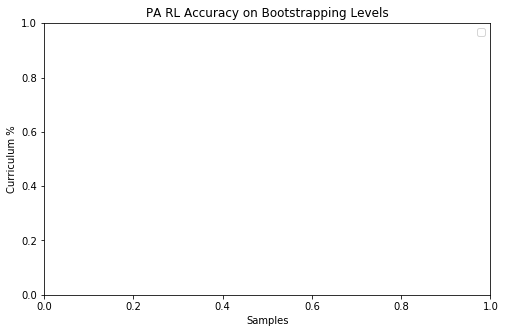

No files found with name 1004
couldn't plot PA -> CC3 easy_swap_harder logits, half distillation itrs
No files found with name 1010
couldn't plot PA -> CC3 easy_swap_harder logits ent / 10 sep models
No files found with name 1011
couldn't plot PA -> CC3 easy_swap_harder logits ent / 100 sep models
No files found with name 1012
couldn't plot PA -> CC3 easy_swap_harder logits ent 0 sep models
No files found with name 0971
couldn't plot PA -> CC3 Sample + Sep Models
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 1067
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .6
No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8


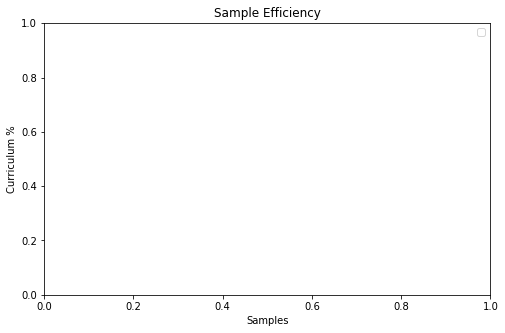

No files found with name 1004
couldn't plot PA -> CC3 easy_swap_harder logits, half distillation itrs
No files found with name 1010
couldn't plot PA -> CC3 easy_swap_harder logits ent / 10 sep models
No files found with name 1011
couldn't plot PA -> CC3 easy_swap_harder logits ent / 100 sep models
No files found with name 1012
couldn't plot PA -> CC3 easy_swap_harder logits ent 0 sep models
No files found with name 0971
couldn't plot PA -> CC3 Sample + Sep Models
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 1067
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .6
No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8


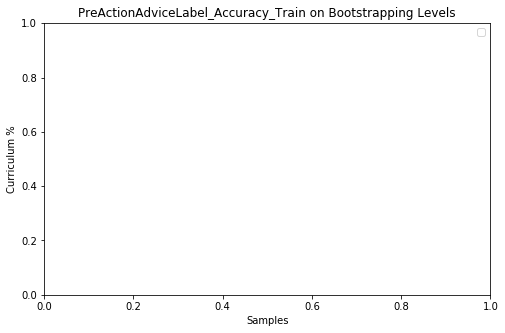

No files found with name 1004
couldn't plot PA -> CC3 easy_swap_harder logits, half distillation itrs
No files found with name 1010
couldn't plot PA -> CC3 easy_swap_harder logits ent / 10 sep models
No files found with name 1011
couldn't plot PA -> CC3 easy_swap_harder logits ent / 100 sep models
No files found with name 1012
couldn't plot PA -> CC3 easy_swap_harder logits ent 0 sep models
No files found with name 0971
couldn't plot PA -> CC3 Sample + Sep Models
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 1067
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .6
No files found with name 1068
couldn't plot PA -> CC3 easy_swap_harder logits threshold_distill .8


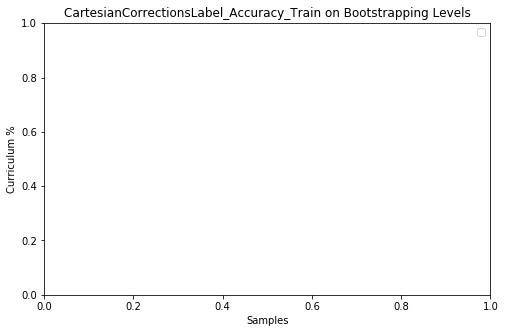

In [73]:
data_names = [ 
    (['0999'], 'PA -> PA logits'),
    (['1000'], 'PA -> PA distill logits'),
    (['1003'], 'PA -> CC3 easy_swap_harder_noselfdistill logits'),
    (['1006'], 'PA -> CC3 easy_swap_harder logits nodistill'),
    (['1007'], 'PA -> CC3 easy_swap_harder logits ent / 10'),
    (['1008'], 'PA -> CC3 easy_swap_harder logits ent / 100'),
    (['1009'], 'PA -> CC3 easy_swap_harder logits ent 0'),
    (['1001'], 'PA -> CC3 easy_swap_harder logits'),
    (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', level_start=0, level_end=12)
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
# plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
#                 level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Val on Bootstrapping Levels")

print("/" * 200)

data_names = [ 
    (['1004'], 'PA -> CC3 easy_swap_harder logits, half distillation itrs'),
    (['1010'], 'PA -> CC3 easy_swap_harder logits ent / 10 sep models'),
    (['1011'], 'PA -> CC3 easy_swap_harder logits ent / 100 sep models'),
    (['1012'], 'PA -> CC3 easy_swap_harder logits ent 0 sep models'),
    (['0971', '0972'], 'PA -> CC3 Sample + Sep Models'),
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
#     (['0877', '0878'], 'PA Nodistill'),
#     (['867', '868'], 'PA distill sample'),
#     (['0895', '0896'], 'PA -> CC3 Nodistill sample'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', level_start=0, level_end=12)
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
# plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
#                 level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Val on Bootstrapping Levels")

How many distillation steps should we use?

No files found with name 1001
couldn't plot PA -> CC3 easy_swap_harder logits
No files found with name 1004
couldn't plot PA -> CC3 easy_swap_harder logits, half distillation itrs
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 1012
couldn't plot PA -> CC3 easy_swap_harder logits ent 0 sep models
No files found with name 0997
couldn't plot Distill from  oracle


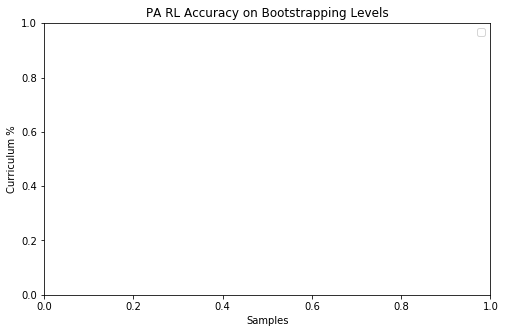

No files found with name 1001
couldn't plot PA -> CC3 easy_swap_harder logits
No files found with name 1004
couldn't plot PA -> CC3 easy_swap_harder logits, half distillation itrs
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 1012
couldn't plot PA -> CC3 easy_swap_harder logits ent 0 sep models
No files found with name 0997
couldn't plot Distill from  oracle


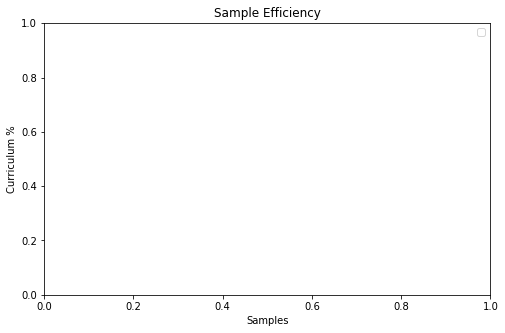

No files found with name 1001
couldn't plot PA -> CC3 easy_swap_harder logits
No files found with name 1004
couldn't plot PA -> CC3 easy_swap_harder logits, half distillation itrs
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 1012
couldn't plot PA -> CC3 easy_swap_harder logits ent 0 sep models
No files found with name 0997
couldn't plot Distill from  oracle


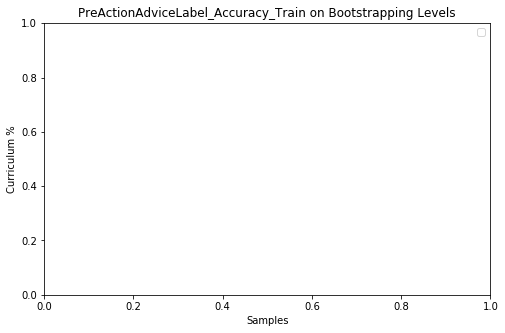

No files found with name 1001
couldn't plot PA -> CC3 easy_swap_harder logits
No files found with name 1004
couldn't plot PA -> CC3 easy_swap_harder logits, half distillation itrs
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 1012
couldn't plot PA -> CC3 easy_swap_harder logits ent 0 sep models
No files found with name 0997
couldn't plot Distill from  oracle


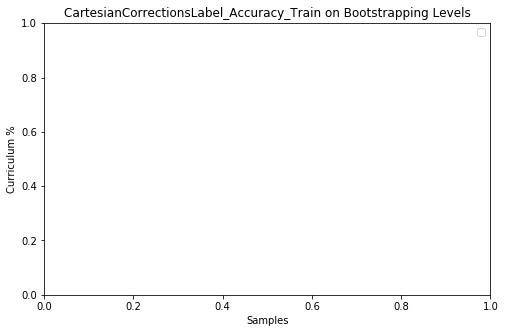

No files found with name 1001
couldn't plot PA -> CC3 easy_swap_harder logits
No files found with name 1004
couldn't plot PA -> CC3 easy_swap_harder logits, half distillation itrs
No files found with name 0969
couldn't plot PA -> CC3 Argmax + Sep Models
No files found with name 1012
couldn't plot PA -> CC3 easy_swap_harder logits ent 0 sep models
No files found with name 0997
couldn't plot Distill from  oracle


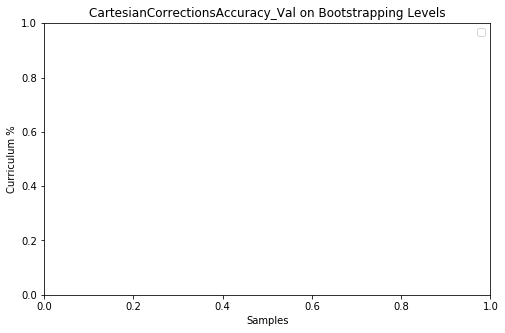

In [74]:
data_names = [ 
    (['1001'], 'PA -> CC3 easy_swap_harder logits'),
    (['1004'], 'PA -> CC3 easy_swap_harder logits, half distillation itrs'),
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['1012'], 'PA -> CC3 easy_swap_harder logits ent 0 sep models'),
    (['0997', '0998'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsAccuracy_Val on Bootstrapping Levels")


Best entropy rate?

No files found with name T1004
couldn't plot PA -> CC3 Ent / 1
No files found with name T1022
couldn't plot PA -> CC3 Ent / 10
No files found with name T1023
couldn't plot PA -> CC3  Ent / 100
No files found with name T1024
couldn't plot Pa -> CC3 Ent 0
No files found with name T1025
couldn't plot PA -> CC3  Ent / -100
No files found with name T1026
couldn't plot PA -> CC3 Ent / -10
No files found with name T1027
couldn't plot PA -> CC3 Ent / -1
No files found with name 0997
couldn't plot Distill from  oracle


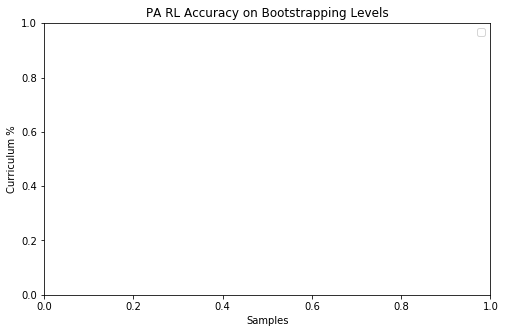

No files found with name T1004
couldn't plot PA -> CC3 Ent / 1
No files found with name T1022
couldn't plot PA -> CC3 Ent / 10
No files found with name T1023
couldn't plot PA -> CC3  Ent / 100
No files found with name T1024
couldn't plot Pa -> CC3 Ent 0
No files found with name T1025
couldn't plot PA -> CC3  Ent / -100
No files found with name T1026
couldn't plot PA -> CC3 Ent / -10
No files found with name T1027
couldn't plot PA -> CC3 Ent / -1
No files found with name 0997
couldn't plot Distill from  oracle


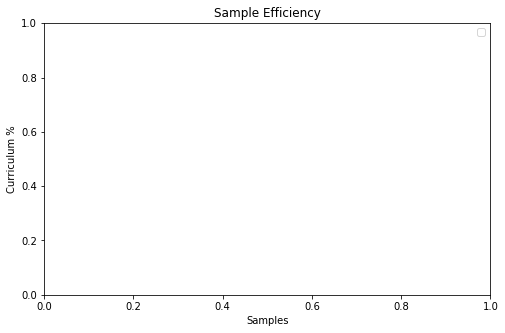

No files found with name T1004
couldn't plot PA -> CC3 Ent / 1
No files found with name T1022
couldn't plot PA -> CC3 Ent / 10
No files found with name T1023
couldn't plot PA -> CC3  Ent / 100
No files found with name T1024
couldn't plot Pa -> CC3 Ent 0
No files found with name T1025
couldn't plot PA -> CC3  Ent / -100
No files found with name T1026
couldn't plot PA -> CC3 Ent / -10
No files found with name T1027
couldn't plot PA -> CC3 Ent / -1
No files found with name 0997
couldn't plot Distill from  oracle


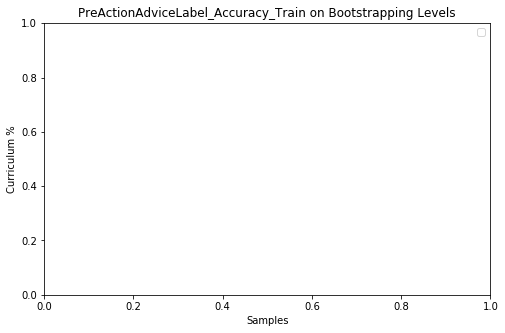

No files found with name T1004
couldn't plot PA -> CC3 Ent / 1
No files found with name T1022
couldn't plot PA -> CC3 Ent / 10
No files found with name T1023
couldn't plot PA -> CC3  Ent / 100
No files found with name T1024
couldn't plot Pa -> CC3 Ent 0
No files found with name T1025
couldn't plot PA -> CC3  Ent / -100
No files found with name T1026
couldn't plot PA -> CC3 Ent / -10
No files found with name T1027
couldn't plot PA -> CC3 Ent / -1
No files found with name 0997
couldn't plot Distill from  oracle


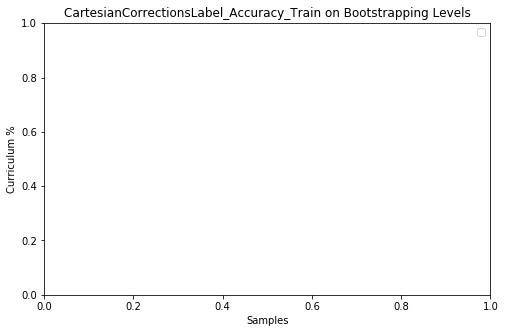

No files found with name T1004
couldn't plot PA -> CC3 Ent / 1
No files found with name T1022
couldn't plot PA -> CC3 Ent / 10
No files found with name T1023
couldn't plot PA -> CC3  Ent / 100
No files found with name T1024
couldn't plot Pa -> CC3 Ent 0
No files found with name T1025
couldn't plot PA -> CC3  Ent / -100
No files found with name T1026
couldn't plot PA -> CC3 Ent / -10
No files found with name T1027
couldn't plot PA -> CC3 Ent / -1
No files found with name 0997
couldn't plot Distill from  oracle


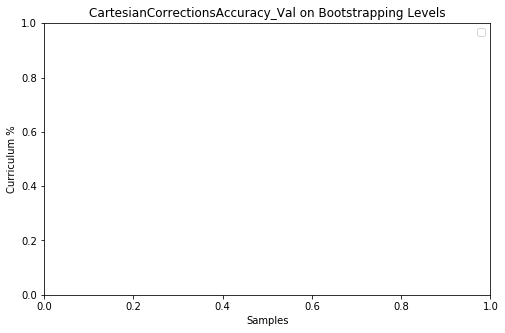

In [75]:
data_names = [ 
    (['T1004'], 'PA -> CC3 Ent / 1'),
    (['T1022'], 'PA -> CC3 Ent / 10'),
    (['T1023'], 'PA -> CC3  Ent / 100'),
    (['T1024'], 'Pa -> CC3 Ent 0'),
    (['T1025'], 'PA -> CC3  Ent / -100'),
    (['T1026'], 'PA -> CC3 Ent / -10'),
    (['T1027'], 'PA -> CC3 Ent / -1'),
    
    (['0997', '0998'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsAccuracy_Val on Bootstrapping Levels")


Best distillation steps?

No files found with name T1015
couldn't plot PA -> CC3 D1
No files found with name T1016
couldn't plot PA -> CC3 D5
No files found with name T1017
couldn't plot PA -> CC3 D10
No files found with name T1004
couldn't plot PA -> CC3 D15
No files found with name T1018
couldn't plot Pa -> CC3 D20
No files found with name T1019
couldn't plot PA -> CC3 D30
No files found with name T1020
couldn't plot PA -> CC3 D40
No files found with name T1021
couldn't plot PA -> CC3 D50
No files found with name 0997
couldn't plot Distill from  oracle


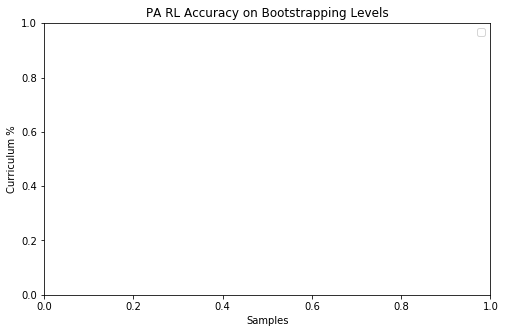

No files found with name T1015
couldn't plot PA -> CC3 D1
No files found with name T1016
couldn't plot PA -> CC3 D5
No files found with name T1017
couldn't plot PA -> CC3 D10
No files found with name T1004
couldn't plot PA -> CC3 D15
No files found with name T1018
couldn't plot Pa -> CC3 D20
No files found with name T1019
couldn't plot PA -> CC3 D30
No files found with name T1020
couldn't plot PA -> CC3 D40
No files found with name T1021
couldn't plot PA -> CC3 D50
No files found with name 0997
couldn't plot Distill from  oracle


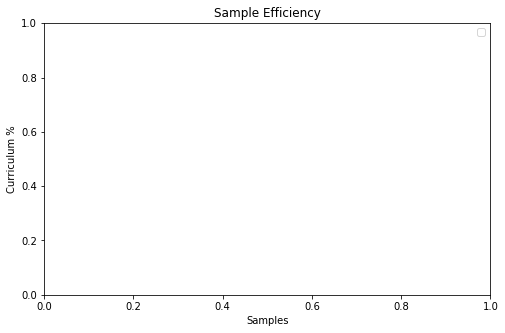

No files found with name T1015
couldn't plot PA -> CC3 D1
No files found with name T1016
couldn't plot PA -> CC3 D5
No files found with name T1017
couldn't plot PA -> CC3 D10
No files found with name T1004
couldn't plot PA -> CC3 D15
No files found with name T1018
couldn't plot Pa -> CC3 D20
No files found with name T1019
couldn't plot PA -> CC3 D30
No files found with name T1020
couldn't plot PA -> CC3 D40
No files found with name T1021
couldn't plot PA -> CC3 D50
No files found with name 0997
couldn't plot Distill from  oracle


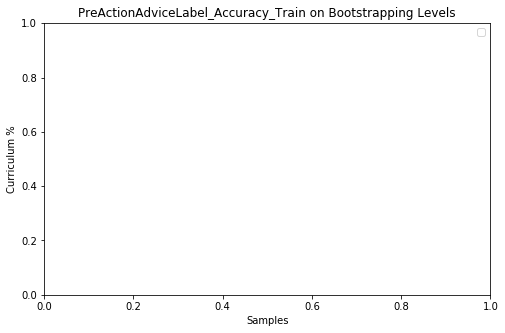

No files found with name T1015
couldn't plot PA -> CC3 D1
No files found with name T1016
couldn't plot PA -> CC3 D5
No files found with name T1017
couldn't plot PA -> CC3 D10
No files found with name T1004
couldn't plot PA -> CC3 D15
No files found with name T1018
couldn't plot Pa -> CC3 D20
No files found with name T1019
couldn't plot PA -> CC3 D30
No files found with name T1020
couldn't plot PA -> CC3 D40
No files found with name T1021
couldn't plot PA -> CC3 D50
No files found with name 0997
couldn't plot Distill from  oracle


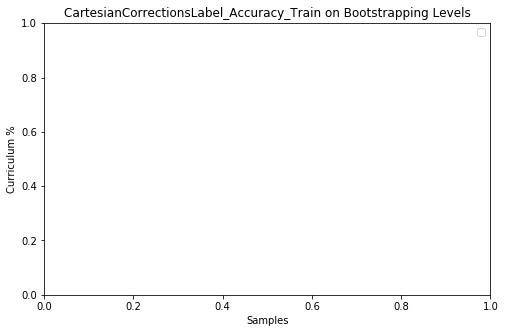

No files found with name T1015
couldn't plot PA -> CC3 D1
No files found with name T1016
couldn't plot PA -> CC3 D5
No files found with name T1017
couldn't plot PA -> CC3 D10
No files found with name T1004
couldn't plot PA -> CC3 D15
No files found with name T1018
couldn't plot Pa -> CC3 D20
No files found with name T1019
couldn't plot PA -> CC3 D30
No files found with name T1020
couldn't plot PA -> CC3 D40
No files found with name T1021
couldn't plot PA -> CC3 D50
No files found with name 0997
couldn't plot Distill from  oracle


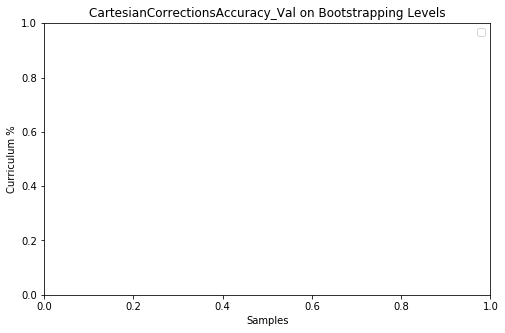

In [76]:
data_names = [ 
    (['T1015'], 'PA -> CC3 D1'),
    (['T1016'], 'PA -> CC3 D5'),
    (['T1017'], 'PA -> CC3 D10'),
    (['T1004'], 'PA -> CC3 D15'),
    (['T1018'], 'Pa -> CC3 D20'),
    (['T1019'], 'PA -> CC3 D30'),
    (['T1020'], 'PA -> CC3 D40'),
    (['T1021'], 'PA -> CC3 D50'),
    
    (['0997', '0998'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsAccuracy_Val on Bootstrapping Levels")


# End

No files found with name 1022
couldn't plot PA -> CC3 Normal
No files found with name 1032
couldn't plot DAgger


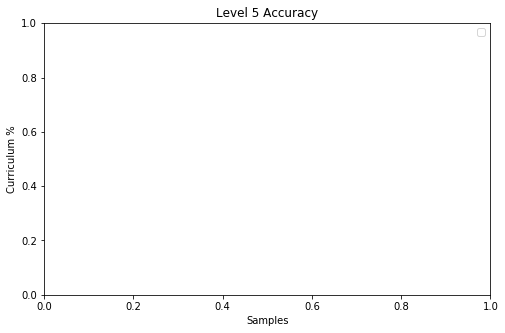

No files found with name 1022
couldn't plot PA -> CC3 Normal
No files found with name 1032
couldn't plot DAgger


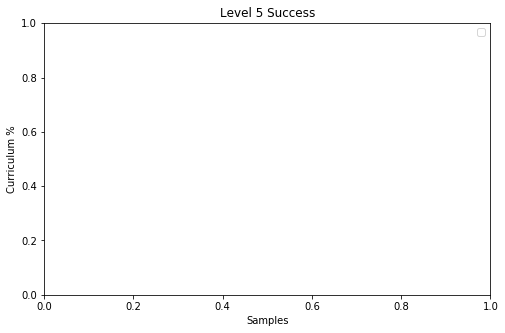

No files found with name 1022
couldn't plot PA -> CC3 Normal
No files found with name 1032
couldn't plot DAgger


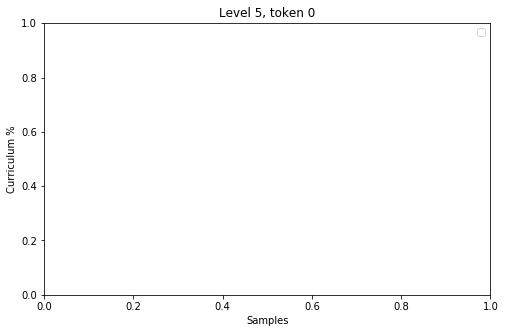

No files found with name 1022
couldn't plot PA -> CC3 Normal
No files found with name 1032
couldn't plot DAgger


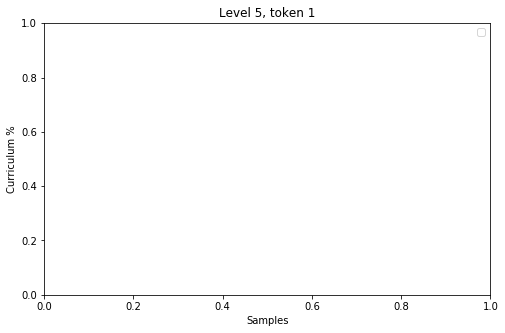

No files found with name 1022
couldn't plot PA -> CC3 Normal
No files found with name 1032
couldn't plot DAgger


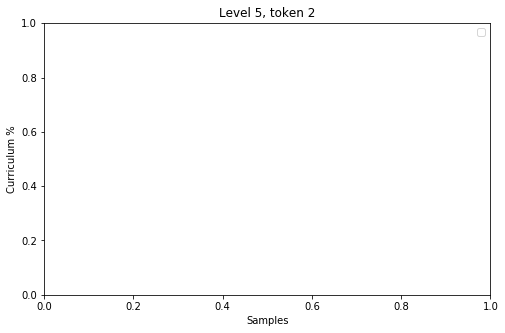

No files found with name 1022
couldn't plot PA -> CC3 Normal
No files found with name 1032
couldn't plot DAgger


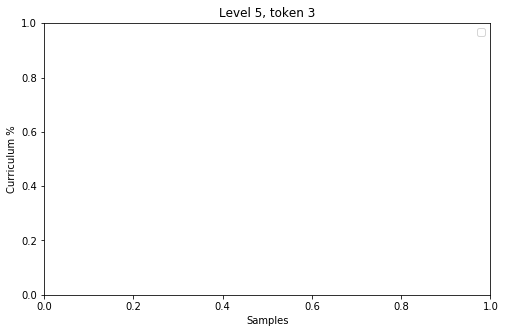

No files found with name 1022
couldn't plot PA -> CC3 Normal
No files found with name 1032
couldn't plot DAgger


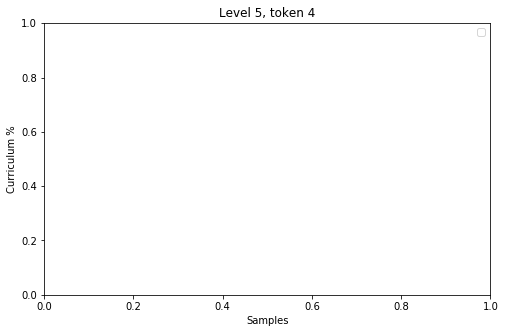

In [77]:
data_names = [ 
    (['1022'], 'PA -> CC3 Normal'),
    (['1032'], 'DAgger'),
] # kangaroo

plot_curriculum(data_names, 'samples', y=f'Train/Accuracy', smooth=100, 
                level_start=5, level_end=5, title=f"Level 5 Accuracy")
plot_curriculum(data_names, 'samples', y=f'Train/Success', smooth=100, 
                level_start=5, level_end=5, title=f"Level 5 Success")


for i in range(5):
    plot_curriculum(data_names, 'samples', y=f'Train/Accuracy{i}', smooth=100, 
                level_start=5, level_end=5, title=f"Level 5, token {i}")

No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


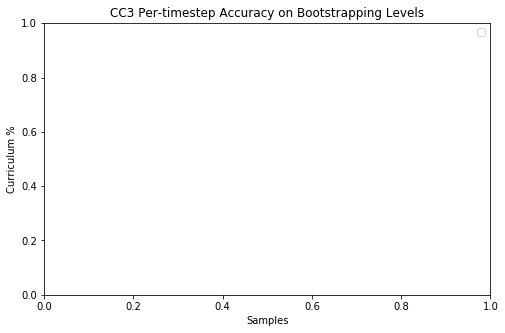

No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


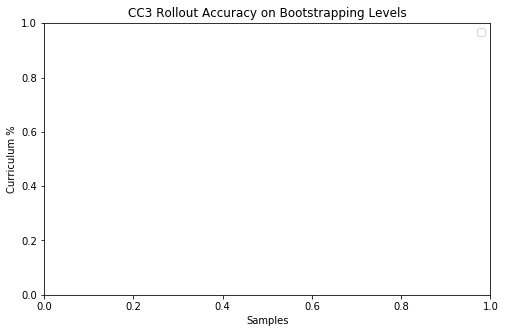

No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


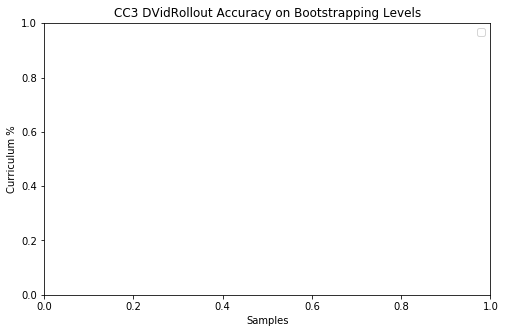

No files found with name 1146
couldn't plot PA -> Distill from  oracle threshold_distill .9


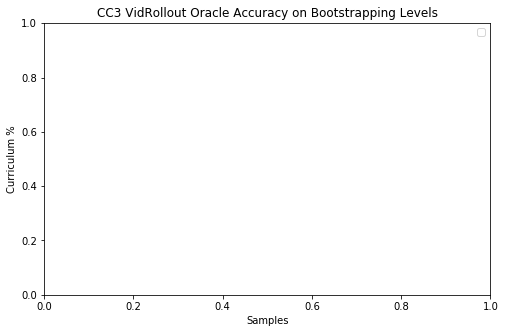

In [78]:
data_names = [ 
    (['1146'], 'PA -> Distill from  oracle threshold_distill .9'),
]

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=10, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='DVidRollout/StochAcc', smooth=10, 
                level_start=0, level_end=12, title="CC3 DVidRollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='VidRollout/OracleCCAcc', smooth=10, 
                level_start=0, level_end=12, title="CC3 VidRollout Oracle Accuracy on Bootstrapping Levels")